# Initial Supervised Learning Analysis for the HR Separation (hrsepara) project
## Start with output from initialEDA v0.6
### Identify the correct working directory for source data
* '/data/discovery/hrsepara/core/'
### Identify the correct working directory for the analysis (both HDFS and LFS)
* '/data/discovery/hrsepara/staging/eda' and  '/home/kesj/working/hrsepara/eda/'
## 


In [1]:
coredir = '/data/discovery/hrsepara/core/'
stgdir1 = '/data/discovery/hrsepara/staging/eda'
stgdir1local = '/home/kesj/work/hrsepara/eda'


In [2]:
import os,subprocess
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from itertools import chain
from random import random

In [3]:
plt.style.use('fivethirtyeight') # Good looking plots
import seaborn as sns

In [4]:
# check if the path exists
os.path.exists(stgdir1local)

True

In [5]:
def hdfs_path_doesnt_exist(path):
    return subprocess.call(['hdfs','dfs','-ls',path])
    # returns 0 if doesnt_exist; 1 otherwise
    

In [6]:
# make the remote directory
if not hdfs_path_doesnt_exist(stgdir1):
    !hdfs dfs -mkdir {stgdir1}

In [7]:
# check if the path exists
if not os.path.exists(stgdir1local):
    # make the local directory
    !mkdir {stgdir1local}
    #'/home/kesj/work/hrsepara/eda'


%pwd

u'/home/kesj/ipynb/HRsepara'

In [8]:
%cd {stgdir1local}

/home/kesj/work/hrsepara/eda


In [9]:
#define the currentworking directory:
cwd = os.path.abspath(os.curdir)
print cwd

/home/kesj/work/hrsepara/eda


In [10]:
def summarize_dataframe2(df,show_example=False,verbose=False):
    nrow = len(df)
    summary_df = pd.DataFrame(columns = ['Column','datatype','nmissing','arity','accepted values'])
    len_df = len(summary_df)
    for col in df.columns:
        nmiss = nrow - df[col].value_counts().sum()
        narity = len(df[col].unique())
        if show_example:
            print col, df[col].dtype,nmiss, "\t", narity,":\t", df[col].ix[8320]
        elif verbose:
            print col, df[col].dtype,nmiss, "\t", narity
        accept_val = None
        if narity < 20:
            accept_val = df[col].unique()
        summary_df.loc[len_df] = [col,df[col].dtype,nmiss,narity,accept_val]
        len_df+=1
    # assing fraction of missing
    summary_df['x_missing'] = summary_df['nmissing']/float(nrow)
    
    return summary_df

### READ the data May 5, 2015

In [11]:
new_read_dict = {'KEY':np.str,'LOCATION':np.str,'EEO1CODE':np.str,'SKEY':np.str,'JOBCODE':np.str,'EMPL_CLASS':np.str, 
                        'COMPANY':np.str,'EXT_FUNC_ID_SFI':np.str,'FUNC_ID_SFI':np.str,
                          'DIVISION_CODE_SFI':np.str,'JOB_FAMILY':np.str,'JOB_FUNCTION':np.str,'ACTRES1':np.str,
                          'ACTRES2':np.str,'ACTRES3':np.str,'ACTRES4':np.str,'ACTRES5':np.str,'ACTRES6':np.str,
                          'ACTRES7':np.str,'ACTRES8':np.str,'ACTRES9':np.str,'ACTRES10':np.str,'zip5':np.str}
empl = pd.read_csv('employee_dataframe8.tsv',sep='\t',dtype={'KEY':np.str,'SKEY':np.str,'zip5':np.str})#,dtype=new_read_dict)
empl.head(), empl.shape

(                                             ACTRES1  \
 0               MERIT;WINDOW 2 - EARLY RET INCENTIVE   
 1  MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA C...   
 2  DISSATISFACTION;COMPANY WIDE CONVERSION;REGION...   
 3               MERIT;WINDOW 4 - EARLY RET INCENTIVE   
 4  MISCELLANEOUS DATA CHANGE;SALARY ADJUSTMENT;TR...   
 
                                             ACTRES10  \
 0                                              MERIT   
 1                                            MISSING   
 2  TRANSFER W/O JOB NUMBER CHANGE;MERIT;COLA INDI...   
 3  MERIT;RRTR W/JOB NUMBER CHANGE;COLA INDICATOR ...   
 4                                            MISSING   
 
                                              ACTRES2  \
 0  MERIT;MISCELLANEOUS DATA CHANGE;JOB RECLASSIFI...   
 1                                            MISSING   
 2                                              MERIT   
 3                    MERIT;MISCELLANEOUS DATA CHANGE   
 4  MISCELLANEOUS DATA CHAN

### Replace mising values of floats with median

In [12]:
## Look at medians of SAL*
empl.SAL2.describe(), np.median(empl.SAL2)

(count     167884.000000
 mean       43299.389978
 std        39803.960684
 min            0.000000
 25%            0.000000
 50%        38257.205000
 75%        65219.230000
 max      1750000.000000
 dtype: float64, 45885.389999999999)

In [13]:
sdf = summarize_dataframe2(empl)

In [14]:
missing_float_columns = list(sdf[(sdf.datatype=='float64')& (sdf.nmissing>0)].Column.values)
len(missing_float_columns)

29

In [15]:
replace_float_cols = ['MERIT1', 'MERIT10', 'MERIT2', 'MERIT3', 'MERIT4', 'MERIT5', 'MERIT6', 'MERIT7', 'MERIT8', 'MERIT9', 
                      'PERF1','PERF2','PERF3','PERF4', 'PERF5','PERF6','PERF7','PERF8', 'PERF9', 'PERF10',
                      'SAL10', 'SAL2', 'SAL3', 'SAL4', 'SAL5', 'SAL6', 'SAL7', 'SAL8', 'SAL9']
len(replace_float_cols)

29

In [16]:
## replace by medians -- overal
col_float_medians ={}
for c in missing_float_columns:
    col_float_medians[c] = np.median(empl[c])
    empl[c].fillna(col_float_medians[c],inplace=True)

#col_float_medians


## remove high-dimensional categorical data

In [18]:
other_categorical_cols = list(sdf[(sdf.datatype == 'object') & (sdf.arity >19)].sort('arity').Column)
other_categorical_cols

['LOC_TYPE_DESCR_SFI',
 'LOC_STATE',
 'GRADE',
 'JOB_FAMILY',
 'LOC_CITY',
 'TERMINATION_DT',
 'ACTRES8',
 'LAST_HIRE_DT',
 'ACTRES9',
 'ACTRES6',
 'HIRE_DT',
 'ACTRES10',
 'ACTRES7',
 'LOCATION',
 'ACTRES5',
 'SKEY',
 'Tenure_tdelta',
 'zip5',
 'SERVICE_DT',
 'ACTRES4',
 'Age_tdelta',
 'ACTRES3',
 'ACTRES2',
 'BIRTHDATE',
 'ACTRES1',
 'LEGACY_DEPT_SFI',
 'ADDRESS1',
 'KEY']

In [19]:
cols_to_encode = other_categorical_cols[:6]
cols_to_encode.append('JOBCODE')
cols_to_encode

['LOC_TYPE_DESCR_SFI',
 'LOC_STATE',
 'GRADE',
 'JOB_FAMILY',
 'LOC_CITY',
 'TERMINATION_DT',
 'JOBCODE']

In [20]:
cols_to_ignore = other_categorical_cols[8:]
cols_to_ignore.append('LOC_CITY')
cols_to_ignore

['ACTRES9',
 'ACTRES6',
 'HIRE_DT',
 'ACTRES10',
 'ACTRES7',
 'LOCATION',
 'ACTRES5',
 'SKEY',
 'Tenure_tdelta',
 'zip5',
 'SERVICE_DT',
 'ACTRES4',
 'Age_tdelta',
 'ACTRES3',
 'ACTRES2',
 'BIRTHDATE',
 'ACTRES1',
 'LEGACY_DEPT_SFI',
 'ADDRESS1',
 'KEY',
 'LOC_CITY']

# Transform to categorical if <= 19 in arity
* one-hot encoding

In [22]:
#cols_to_cat = ['FULL_PART_TIME','EMPL_TYPE','COMPANY','EEO1CODE','EMPL_CLASS','JOB_FUNCTION']
cols_to_cat = list(sdf[(sdf.datatype == 'object') & (sdf.arity <=19)].sort('arity').Column)
cols_to_cat

['FULL_PART_TIME', 'EMPL_TYPE', 'EEO1CODE', 'EMPL_CLASS', 'JOB_FUNCTION']

In [80]:
cols_to_cat.remove('DIVISION_CODE_SFI')

## Drop Tenure Months because redundant with Tenure Years.

In [23]:
[x for x in empl.columns if x.startswith('Tenure')]

['Tenure_months', 'Tenure_tdelta', 'Tenure_years']

## per email from Ron Davis, REMOVE COMPANY from analysis

In [25]:
cols_to_ignore.append('Tenure_months')
cols_to_ignore.append('COMPANY')
#cols_to_cat.remove('COMPANY')

In [26]:
empl.drop(cols_to_ignore,inplace=True,axis=1)
empl.shape

(199419, 161)

In [27]:
#[(c,len(empl[c].unique())) for c in cols_to_cat]
cols_to_cat

['FULL_PART_TIME', 'EMPL_TYPE', 'EEO1CODE', 'EMPL_CLASS', 'JOB_FUNCTION']

In [28]:
print "base_categories"
print "------------------------"
[(a,len(empl[a].unique()),empl[a].value_counts().head(1)) for a in cols_to_cat]

base_categories
------------------------


[('FULL_PART_TIME', 4, F    171554
  dtype: int64), ('EMPL_TYPE', 5, E    116476
  dtype: int64), ('EEO1CODE', 11, 5    93585
  dtype: int64), ('EMPL_CLASS', 12, 1    194163
  dtype: int64), ('JOB_FUNCTION', 19, XXX    68899
  dtype: int64)]

In [29]:
def create_factorized_df(input_df,column_name):
    tmp_df = pd.get_dummies(input_df[column_name],prefix=column_name)
    # now drop the largest category
    lgst_category = input_df[column_name].value_counts().index[0]
    #print tmp_df.shape, tmp_df.columns
    #print lgst_category
    base_category = column_name+'_'+str(lgst_category)
    tmp_df.drop(base_category,axis=1,inplace=True)
    print tmp_df.shape, base_category
    return tmp_df,base_category
    

In [30]:
# create a dummified dataframe.
base_category_list =[]
print empl.shape
for acol in cols_to_cat:
    print acol
    t_df,bc1 = create_factorized_df(empl,acol)
    # drop the original column
    empl.drop(acol,inplace=True,axis=1)
    # append the factorized categories
    empl = pd.concat([empl,t_df],axis=1)
    base_category_list.append(bc1)

print empl.shape,len(base_category_list)

(199419, 161)
FULL_PART_TIME
(199419, 3) FULL_PART_TIME_F
EMPL_TYPE
(199419, 4) EMPL_TYPE_E
EEO1CODE
(199419, 10) EEO1CODE_5
EMPL_CLASS
(199419, 11) EMPL_CLASS_1
JOB_FUNCTION
(199419, 18) JOB_FUNCTION_XXX
(199419, 202) 5


In [170]:
acol='EMPL_TYPE'
t_df,bc1 = create_factorized_df(empl,acol)
    # drop the original column
empl.drop(acol,inplace=True,axis=1)
# append the factorized categories
empl = pd.concat([empl,t_df],axis=1)
base_category_list.append(bc1)

(199419, 4) EMPL_TYPE_E


## just use label_encoding -- need to improve this later


In [33]:
cols_to_encode
cols_to_encode.remove('LOC_CITY')

In [35]:
cols_to_encode.remove('TERMINATION_DT')
#cols_to_encode.append('FUNC_ID_SFI')
#cols_to_encode.append('FUNC_ID

In [36]:
[(x,len(empl[x].unique()),empl[x].ix[0]) for x in cols_to_encode]

[('LOC_TYPE_DESCR_SFI', 34, 'OPERATIONS CENTER'),
 ('LOC_STATE', 52, 'AL'),
 ('GRADE', 164, 'RB2'),
 ('JOB_FAMILY', 1456, 'FCLMRP'),
 ('JOBCODE', 3791, 167)]

In [89]:
[(x,len(empl[x].unique()),empl[x].ix[0]) for x in cols_to_encode]

[('LOC_TYPE_DESCR_SFI', 34, 'OPERATIONS CENTER'),
 ('LOC_STATE', 52, 'AL'),
 ('FUNC_ID_SFI', 64, 14),
 ('GRADE', 164, 'RB2'),
 ('EXT_FUNC_ID_SFI', 422, 315),
 ('JOB_FAMILY', 1456, 'FCLMRP'),
 ('JOBCODE', 3791, 167)]

## I need to encode the location description, state, grade and job_family since these are character strings.

In [37]:
label_encoder = preprocessing.LabelEncoder()

In [38]:
empl2 = empl.copy()
for col in cols_to_encode:
    if col == 'LOC_TYPE_DESCR_SFI':
        empl2['loc_descr'] = label_encoder.fit_transform(empl[col])
    elif col == 'LOC_STATE':
        empl2['state_code'] = label_encoder.fit_transform(empl[col])
    elif col == 'GRADE':
        empl2['grade_code'] = label_encoder.fit_transform(empl[col])
    elif col == 'JOB_FAMILY':
        empl2['job_fcode']= label_encoder.fit_transform(empl[col])
    
empl2.drop(['LOC_TYPE_DESCR_SFI','GRADE','LOC_STATE','JOB_FAMILY'],axis=1,inplace=True)

In [ ]:
#for col in cols_to_encode:
#    empl[col] = label_encoder.fit_transform(empl[col]) # use sklearn.preprocesing.LabelEncoder()

In [39]:
empl2.shape

(199419, 202)

### look at EXT_FUNC_ID_SFI and FUNC_ID_SFI
* change max value to something closer to the other range

                 FUNC_ID_SFI  EXT_FUNC_ID_SFI
FUNC_ID_SFI         1.000000         0.376745
EXT_FUNC_ID_SFI     0.376745         1.000000


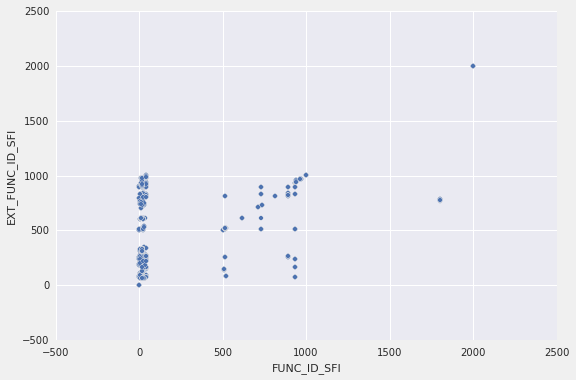

In [40]:
## replace '99999' in EXT_FUNC_ID_SFI and FUNC_ID_SFI by 2000
empl2.replace({'FUNC_ID_SFI':{99999:2000},'EXT_FUNC_ID_SFI':{99999:2000}},inplace=True)
#pd.crosstab(empl2.FUNC_ID_SFI,empl2.EXT_FUNC_ID_SFI)
empl2.plot(kind='scatter',x='FUNC_ID_SFI',y='EXT_FUNC_ID_SFI')
print empl2[['FUNC_ID_SFI','EXT_FUNC_ID_SFI']].corr()

# Now it is ready to use as input into scikitLearn as a matrix
The standard notation is to define this as X and save it as a float type
Don't forget to create a response variable, y

## I should begin to see if there are columns that have strong correlations.


In [41]:
full_empl2_df_correlation = empl2.corr()

In [42]:
arank = full_empl2_df_correlation.apply(np.argsort, axis=1)
ranked_cols = full_empl2_df_correlation.columns.to_series()[arank.values[:,::-1][:,:2]]

In [43]:
new_frame = pd.DataFrame(ranked_cols,index=full_empl2_df_correlation.index)
new_frame

,0,1
ADDRCNT1,ADDRCNT1,ADDRCNT3
ADDRCNT10,ADDRCNT10,ADDRCNT5
ADDRCNT3,ADDRCNT3,ADDRCNT5
ADDRCNT5,ADDRCNT5,ADDRCNT3
ANNUAL_RT,SAL1,ANNUAL_RT
Age_years,Age_years,Tenure_years
BOX1,BOX1,RATE1
BOX10,BOX10,RATE10
BOX2,BOX2,RATE2
BOX3,BOX3,RATE3


0.939663066841


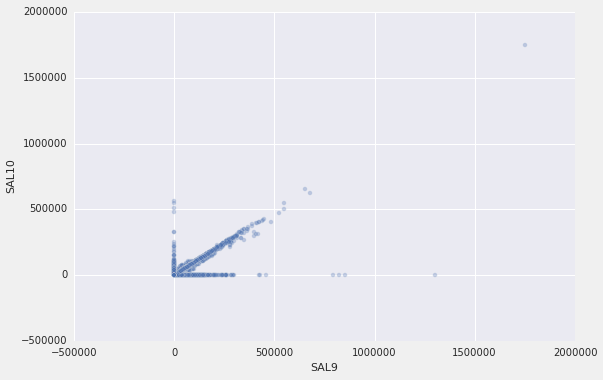

In [46]:
print full_empl2_df_correlation.loc['SAL9','SAL10']
empl2.plot(kind='scatter',x='SAL9',y='SAL10',alpha=0.3)

In [47]:
xcol = new_frame[0].values
ycol = new_frame[1].values
for id in xrange(0,len(xcol)):
    #print xcol[id],ycol[id]
    max_pair_corr = full_empl2_df_correlation.loc[xcol[id],ycol[id]]
    if max_pair_corr > 0.95:
        print max_pair_corr, xcol[id],ycol[id]
#full_empl2_df_correlation.loc[new_frame[0],new_frame[1]]

1.0 SAL1 ANNUAL_RT
0.989415243741 BOX1 RATE1
0.999983183637 BOX10 RATE10
0.999376363207 BOX2 RATE2
0.999508135212 BOX3 RATE3
0.999700241188 BOX4 RATE4
0.9937930924 BOX5 RATE5
0.99996696194 BOX6 RATE6
0.999982584773 BOX7 RATE7
0.999982219434 BOX8 RATE8
1.0 RATE9 BOX9
0.999164092215 FTPTCNT1 FULLPART1
0.971779494665 FTPTCNT10 FULLPART10
0.992404090845 FTPTCNT3 FULLPART3
0.984057846912 FTPTCNT5 FULLPART5
0.999164092215 FULLPART1 FTPTCNT1
0.971779494665 FULLPART10 FTPTCNT10
0.992404090845 FULLPART3 FTPTCNT3
0.984057846912 FULLPART5 FTPTCNT5
0.999439566712 PARTFULL1 PTFTCNT1
0.980538324225 PARTFULL10 PTFTCNT10
0.994825467016 PARTFULL3 PTFTCNT3
0.988920810081 PARTFULL5 PTFTCNT5
0.999439566712 PTFTCNT1 PARTFULL1
0.980538324225 PTFTCNT10 PARTFULL10
0.994825467016 PTFTCNT3 PARTFULL3
0.988920810081 PTFTCNT5 PARTFULL5
0.989415243741 RATE1 BOX1
0.999983183637 RATE10 BOX10
0.999376363207 RATE2 BOX2
0.999508135212 RATE3 BOX3
0.999700241188 RATE4 BOX4
0.9937930924 RATE5 BOX5
0.99996696194 RATE6 BOX6


In [48]:
len(full_empl2_df_correlation), len(empl2.columns)

(199, 202)

In [49]:
set(empl2.columns) - set(full_empl2_df_correlation.index)

{'ACTRES8', 'LAST_HIRE_DT', 'TERMINATION_DT'}

In [51]:
empl2.drop(['ACTRES8','LAST_HIRE_DT','TERMINATION_DT'],axis=1,inplace=True)

### some more cleaning of the data from this:
0. 'fix' encoding of FUNC_ID_SFI and EXT_FUNC_ID_SFI (see below)
1. drop ANNUAL_RT in favor of SAL1
2. keep only RATE* or BOX*
3. keep only PTFTCNT* or PARTFULL*
4. keep only FTCNT* or FULLPART*

(0, 1000)

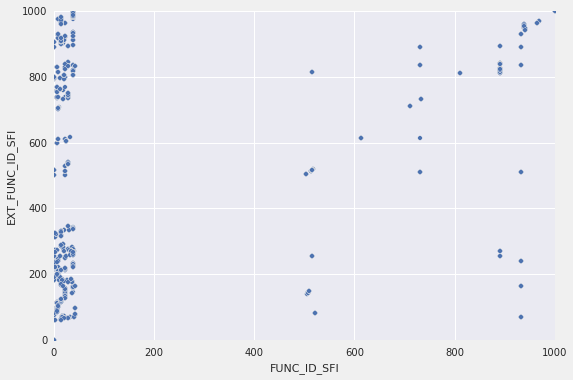

In [180]:
#pd.crosstab(empl2.FUNC_ID_SFI,empl2.EXT_FUNC_ID_SFI)
empl2.plot(kind='scatter',x='FUNC_ID_SFI',y='EXT_FUNC_ID_SFI')
plt.xlim(0,1000)
plt.ylim(0,1000)

In [52]:
[x for x in empl2.FUNC_ID_SFI.unique() if x > 1000]

[2000, 1800]

In [53]:
#empl2.plot(kind='scatter',x='EEO1CODE_4',y='EMPL_CLASS_D',alpha=0.3)
pd.crosstab(empl2.RATE8,empl2.BOX8)
pd.crosstab(empl2.FULLPART1,empl2.FTPTCNT1)

FTPTCNT1,0,1,2
FULLPART1,,,
0,198223,0,0
1,0,1194,2


In [54]:
#empl2.plot(kind='scatter',x='EEO1CODE_4',y='EMPL_CLASS_D',alpha=0.3)
pd.crosstab(empl2.RATE7,empl2.BOX7)
#pd.crosstab(empl2.PARTFULL3,empl2.PTFTCNT3)

BOX7,0,1,2,3
RATE7,,,,
0,110834,0,0,0
1,0,1852,0,0
2,0,0,66433,0
3,1,0,0,20299


In [140]:
pd.crosstab(empl2.RELOCATE_ALL_SFI,empl2.RELO_STATE_CNT_SFI)

RELO_STATE_CNT_SFI,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
RELOCATE_ALL_SFI,,,,,,,,,,,,,,,,,,,,,
0,122834,25735,6464,4630,3578,2508,1924,1396,1057,839,...,21,26,26,43,28,30,45,4,2,10
1,0,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,22913


In [55]:
correlated_columns_to_drop = [x for x in empl2.columns if x.startswith('RATE')]
correlated_columns_to_drop.append('ANNUAL_RT')
b = [x for x in empl2.columns if x.startswith('PARTFULL')]
c = [x for x in empl2.columns if x.startswith('FULLPART')]
extra = b+c
print extra
correlated_columns_to_drop+=extra
print correlated_columns_to_drop

['PARTFULL1', 'PARTFULL10', 'PARTFULL3', 'PARTFULL5', 'FULLPART1', 'FULLPART10', 'FULLPART3', 'FULLPART5']
['RATE1', 'RATE10', 'RATE2', 'RATE3', 'RATE4', 'RATE5', 'RATE6', 'RATE7', 'RATE8', 'RATE9', 'ANNUAL_RT', 'PARTFULL1', 'PARTFULL10', 'PARTFULL3', 'PARTFULL5', 'FULLPART1', 'FULLPART10', 'FULLPART3', 'FULLPART5']


In [56]:
#full_empl2_df_correlation.rank()
empl2.drop(correlated_columns_to_drop,axis=1,inplace=True)
empl2.shape

(199419, 180)

In [57]:
[a for a in empl2.columns if a.startswith('re')]

['retired']

In [60]:
## save the file for input into h2o
empl2.to_csv('employee_df_1.csv',index=False)

## Begin prediction of tenure year

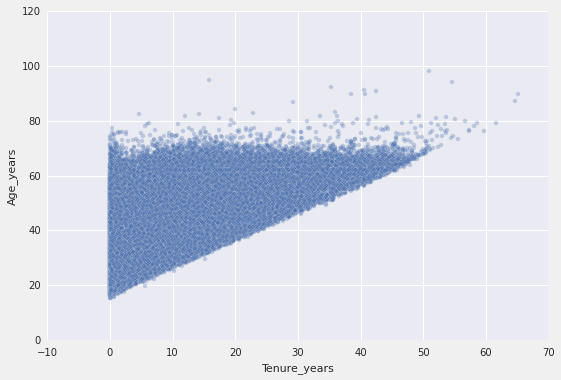

In [62]:
empl2.plot(kind='scatter', x = 'Tenure_years',y = 'Age_years', alpha=0.3)

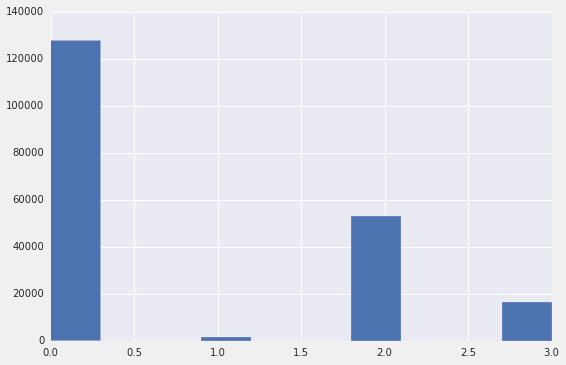

In [63]:
empl2.BOX10.hist()

#### how do the various tenures depend on Box10 values?


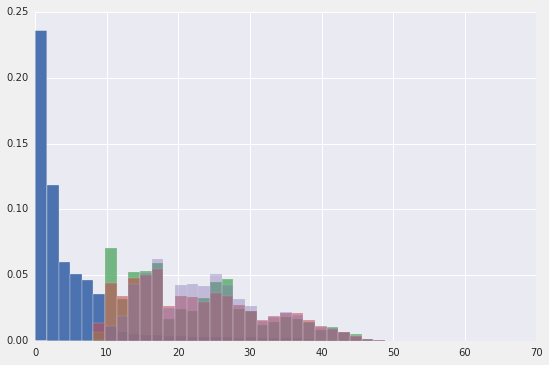

In [66]:
my_range = [empl2.Tenure_years.min(),empl2.Tenure_years.max()]
nbins = 40
empl2[empl2.BOX10==0].Tenure_years.hist(normed=True,range=my_range,bins=nbins)
empl2[empl2.BOX10==1].Tenure_years.hist(normed=True,alpha=0.8,range=my_range,bins=nbins)
empl2[empl2.BOX10==2].Tenure_years.hist(normed=True,alpha=0.6,range=my_range,bins=nbins)
empl2[empl2.BOX10==3].Tenure_years.hist(normed=True,alpha=0.4,range=my_range,bins=nbins)

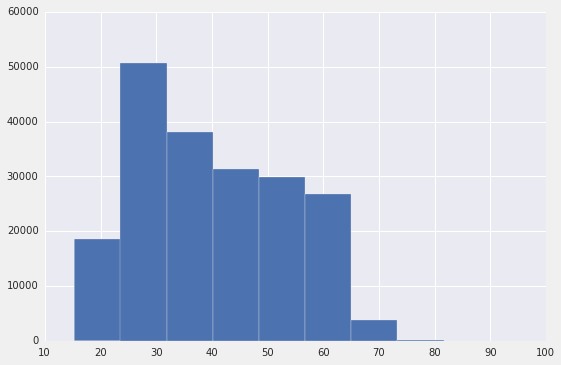

In [64]:
empl2.Age_years.hist()

In [67]:
col_list = empl2.columns.tolist()
col_list

['ADDRCNT1',
 'ADDRCNT10',
 'ADDRCNT3',
 'ADDRCNT5',
 'Age_years',
 'BOX1',
 'BOX10',
 'BOX2',
 'BOX3',
 'BOX4',
 'BOX5',
 'BOX6',
 'BOX7',
 'BOX8',
 'BOX9',
 'COMP_FREQUENCY',
 'CUR_DEPT_MOS',
 'CUR_EFUNC_MOS',
 'CUR_FUNC_MOS',
 'CUR_GRADE_MOS',
 'CUR_JOB_MOS',
 'CUR_LOC_MOS',
 'DEPTCNT1',
 'DEPTCNT10',
 'DEPTCNT3',
 'DEPTCNT5',
 'DIRECT_RPT_CNT',
 'DIVISION_CODE_SFI',
 'EFUNCCNT1',
 'EFUNCCNT10',
 'EFUNCCNT3',
 'EFUNCCNT5',
 'ETHNIC_GROUP',
 'EXTFUNC_CNT',
 'EXT_FUNC_ID_SFI',
 'FLOORCNT1',
 'FLOORCNT10',
 'FLOORCNT3',
 'FLOORCNT5',
 'FLOR_SFI',
 'FLSA_STATUS',
 'FTE',
 'FTPTCNT1',
 'FTPTCNT10',
 'FTPTCNT3',
 'FTPTCNT5',
 'FUNCCNT1',
 'FUNCCNT10',
 'FUNCCNT3',
 'FUNCCNT5',
 'FUNC_CNT',
 'FUNC_ID_SFI',
 'GRADECNT1',
 'GRADECNT10',
 'GRADECNT3',
 'GRADECNT5',
 'HUBIND',
 'INTERN',
 'JOBCNT1',
 'JOBCNT10',
 'JOBCNT3',
 'JOBCNT5',
 'JOBCODE',
 'LOCCNT1',
 'LOCCNT10',
 'LOCCNT3',
 'LOCCNT5',
 'LOCSTCNT1',
 'LOCSTCNT10',
 'LOCSTCNT3',
 'LOCSTCNT5',
 'MAX_RT_ANNUAL',
 'MERIT1',
 'MERIT10',
 

In [69]:
three_cols = [x for x in col_list if x.endswith('CNT3')]
five_cols = [x for x in col_list if x.endswith('CNT5')]
ten_cols = [x for x in col_list if x.endswith('CNT10')]
# drop all BOX, MERIT, SAL, PERF and add back in those from last year
to_drop_cols = [x for x in col_list if x.startswith('PERF')]
to_drop_cols+= [x for x in col_list if x.startswith('SAL')]
to_drop_cols += [x for x in col_list if x.startswith('MERIT')]
to_drop_cols += [x for x in col_list if x.startswith('BOX')]
to_drop_cols+=three_cols
to_drop_cols+=five_cols
to_drop_cols+=ten_cols
to_add_cols = ['BOX1','SAL1','MERIT1','PERF1']
empl3 = empl2.copy()
empl3.drop(to_drop_cols,inplace=True,axis=1)
empl3[to_add_cols] = empl2[to_add_cols].copy()
print empl3.shape

(199419, 108)


In [71]:
empl3.columns.tolist()

['ADDRCNT1',
 'Age_years',
 'COMP_FREQUENCY',
 'CUR_DEPT_MOS',
 'CUR_EFUNC_MOS',
 'CUR_FUNC_MOS',
 'CUR_GRADE_MOS',
 'CUR_JOB_MOS',
 'CUR_LOC_MOS',
 'DEPTCNT1',
 'DIRECT_RPT_CNT',
 'DIVISION_CODE_SFI',
 'EFUNCCNT1',
 'ETHNIC_GROUP',
 'EXTFUNC_CNT',
 'EXT_FUNC_ID_SFI',
 'FLOORCNT1',
 'FLOR_SFI',
 'FLSA_STATUS',
 'FTE',
 'FTPTCNT1',
 'FUNCCNT1',
 'FUNC_CNT',
 'FUNC_ID_SFI',
 'GRADECNT1',
 'HUBIND',
 'INTERN',
 'JOBCNT1',
 'JOBCODE',
 'LOCCNT1',
 'LOCSTCNT1',
 'MAX_RT_ANNUAL',
 'MIN_RT_ANNUAL',
 'PTFTCNT1',
 'REH_CNT',
 'RELOCATE_ALL_SFI',
 'RELO_STATE_CNT_SFI',
 'REMOTE',
 'REMOTE_SUPV',
 'SEX',
 'SHIFT',
 'STD_HOURS',
 'SUPVCNT1',
 'SUPV_DIFF_LOC',
 'TELE_MOS',
 'TOTAL_RPT_CNT',
 'status',
 'Tenure_years',
 'HAVE_INS',
 'HAVE_DEP',
 'DEP_COUNT',
 'sep_status',
 'mar_status',
 'retired',
 'FULL_PART_TIME_N',
 'FULL_PART_TIME_P',
 'FULL_PART_TIME_X',
 'EMPL_TYPE_H',
 'EMPL_TYPE_N',
 'EMPL_TYPE_S',
 'EMPL_TYPE_X',
 'EEO1CODE_1',
 'EEO1CODE_2',
 'EEO1CODE_3',
 'EEO1CODE_4',
 'EEO1CODE_6',
 

In [72]:
empl3.to_csv('employee_df_2.csv',index=False)

### try RF regression

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation

In [74]:
y = empl3['Tenure_years'].values.astype(np.float)
df = empl3.drop(['Tenure_years','status','sep_status','retired'],axis=1).copy()
X = df.as_matrix().astype(np.float)
y.shape, X.shape

((199419,), (199419, 104))

In [85]:
#y_tenure_class = pd.cut(empl3.Tenure_years,np.arange(0,empl3.Tenure_years.max()+1,1))
y_tenure_class = pd.cut(empl2.Tenure_years,[0,1,3,5,10,15,25,200],labels=False,right=False)#,labels=[1,2,3,4,5,6,7,8])#.values
#y_tenure_class

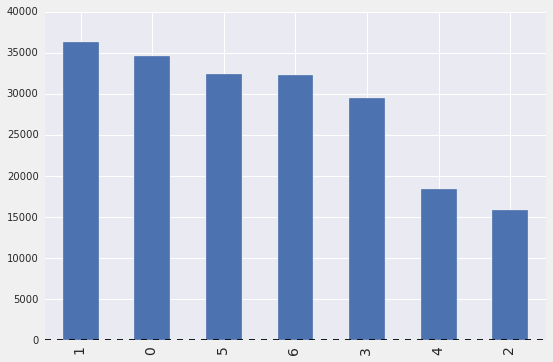

In [86]:
pd.value_counts(y_tenure_class).plot(kind='bar')#.reindex(y_tenure_class.levels)

### tenure_years classes = {0:[0,1),1:[1,3),2:[3,5),3:[5,10),4:[10,15),5:[15,25),6:[25,end)}

In [90]:
%%time
print('RF Classifier: {:.2f}'.format(metrics.accuracy_score(y_tenure_class, kfold_cv(X, y_tenure_class, ensemble.RandomForestClassifier))))

RF Classifier: 0.75
CPU times: user 1min 33s, sys: 2.27 s, total: 1min 35s
Wall time: 1min 35s


In [91]:
rfc_conf_matrix = metrics.confusion_matrix(y_tenure_class, kfold_cv(X, y_tenure_class, ensemble.RandomForestClassifier))

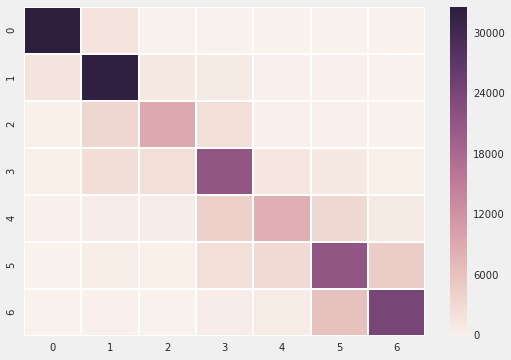

In [92]:
sns.heatmap(rfc_conf_matrix, annot=False)

In [96]:
rfc_conf_matrix

array([[32666,  1671,    98,    94,    20,    15,     7],
       [ 1785, 32079,  1120,   997,   144,   151,    50],
       [  386,  3489,  9278,  2358,   206,   176,    35],
       [  310,  2499,  2428, 21345,  1465,  1153,   336],
       [  152,   710,   577,  4258,  8550,  3242,   910],
       [  109,   508,   305,  2322,  3007, 21292,  4844],
       [   33,   135,    84,   604,   865,  6213, 24338]])

In [99]:
%%time 
forest = ensemble.ExtraTreesClassifier(n_jobs=20)
forest.fit(X,y_tenure_class)
importances= forest.feature_importances_

CPU times: user 13 s, sys: 619 ms, total: 13.6 s
Wall time: 1.84 s


In [102]:
forest_std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]


In [107]:
feature_names = df.columns[indices].tolist()

([<matplotlib.axis.YTick at 0x7fa653c00e50>,
 <a list of 30 Text yticklabel objects>)

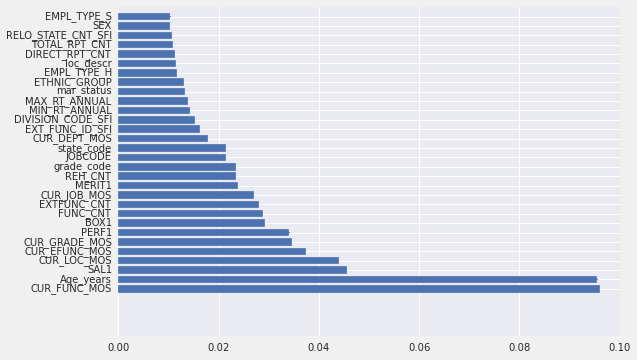

In [116]:
#for f in range(20):
nfeat = 30
plt.barh(range(nfeat),importances[indices[:nfeat]],yerr=forest_std[indices[:nfeat]],align="center")
plt.yticks(range(nfeat),feature_names[:nfeat])


## Now take this model and predict into the future:
* first define set of currently employeed (not-separated) employees
* augment time_sensitive measures

In [110]:
empl_active = empl3[empl3.status == 0].copy()
empl_active.shape

(69806, 108)

In [114]:
### get time_sensitive measures
temporal_cols = [x for x in empl_active.columns if x.endswith('MOS')]
temporal_cols.append('Age_years')
temporal_cols.append('Tenure_years')
temporal_cols#.tolist()

['CUR_DEPT_MOS',
 'CUR_EFUNC_MOS',
 'CUR_FUNC_MOS',
 'CUR_GRADE_MOS',
 'CUR_JOB_MOS',
 'CUR_LOC_MOS',
 'TELE_MOS',
 'Age_years',
 'Tenure_years']

In [118]:
empl3[temporal_cols[:-3]].apply(lambda x: x+12.0)

,CUR_DEPT_MOS,CUR_EFUNC_MOS,CUR_FUNC_MOS,CUR_GRADE_MOS,CUR_JOB_MOS,CUR_LOC_MOS
0,39.677419,204.838710,204.838710,27.709677,37.387097,39.677419
1,18.709677,18.709677,18.709677,18.709677,18.709677,18.709677
2,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
3,40.193548,40.193548,40.193548,47.225806,60.935484,115.612903
4,22.967742,22.967742,22.967742,22.967742,22.967742,22.967742
5,71.483871,122.000000,122.000000,71.483871,71.483871,71.483871
6,26.903226,30.677419,90.000000,30.677419,30.677419,26.903226
7,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
8,30.225807,30.225807,30.225807,30.225807,30.225807,30.225807
9,27.967742,27.967742,27.967742,27.967742,27.967742,27.967742


In [ ]:
df = empl3.drop(['Tenure_years','status','sep_status','retired'],axis=1).copy()
X = df.as_matrix().astype(np.float)
y.shape, X.shape

CUR_DEPT_MOS     323.709677
CUR_EFUNC_MOS    323.967742
CUR_FUNC_MOS     323.967742
CUR_GRADE_MOS    303.000000
CUR_JOB_MOS      323.709677
CUR_LOC_MOS      323.935484
TELE_MOS         180.645161
Age_years         98.197773
Tenure_years      65.126594
dtype: float64

In [134]:
active_tenure_class = y_tenure_class[empl_active.index]

In [126]:
empl_active[empl_active.REMOTE==0].TELE_MOS.values.min()


0.0

In [129]:
def prep_for_prediction(df,time_columns,delta_time=0.0,cols_to_drop = ['Tenure_years','status','sep_status','retired']):
    monthly_cols = [x for x in time_columns if x.endswith('MOS')]
    d2 = df.copy()
    d2[monthly_cols[:-1]]= df[monthly_cols[:-1]].apply(lambda x: x+12.0*delta_time)
    # special column is TELE_MOS
    d2[d2.REMOTE==1][monthly_cols[-1]] = df[df.REMOTE==1][monthly_cols[-1]].apply(lambda x:x+delta_time*12.0)
    
    annual_cols = [x for x in time_columns if x.endswith('years')]
    d2[annual_cols]=df[annual_cols].apply(lambda x: x+1.0*delta_time)
    d2.drop(cols_to_drop,axis=1,inplace=True)
    X = d2.as_matrix().astype(np.float)
    print X.shape
    return X,df.Tenure_years.values+1.0*delta_time

In [135]:
myX,myY = prep_for_prediction(empl_active,temporal_cols,delta_time=0)

(69806, 104)


/opt/anaconda/2.1.0/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


In [136]:
myY[:3]

array([ 0.56400884,  2.05890607,  2.57637049])

In [138]:
active_tenure_class

array([0, 1, 1, ..., 6, 6, 1])

In [137]:
forest.predict(myX)

array([1, 1, 1, ..., 6, 6, 1])

In [139]:
forest.predict_proba(myX)

array([[ 0.2,  0.8,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0.7,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0.4,  0.3, ...,  0. ,  0. ,  0. ],
       ..., 
       [ 0. ,  0. ,  0. , ...,  0. ,  0.2,  0.8],
       [ 0. ,  0. ,  0. , ...,  0. ,  0.1,  0.9],
       [ 0. ,  0.7,  0.1, ...,  0.1,  0. ,  0. ]])

In [141]:
empl_active['Tenure_years'].head()

1      0.564009
4      2.058906
8      2.576370
11    39.332772
12    20.074334
Name: Tenure_years, dtype: float64

## May 12, 2015 
### Attempt RandomForest Regressor (of Tenure Years)
1. use all data --> simple test-train split

In [142]:

test_fraction = 0.3
X_train, X_test , y_train, y_test = cross_validation.train_test_split(X,y,test_size=test_fraction)

In [144]:
%%time 
RFR = ensemble.RandomForestRegressor(n_estimators=200,max_features="sqrt",n_jobs=30)
RFR.fit(X_train,y_train)
RFR_importances= RFR.feature_importances_

CPU times: user 2min 34s, sys: 2.09 s, total: 2min 36s
Wall time: 7.88 s


In [145]:
RFR.score(X_test,y_test)

0.87305244679150662

In [151]:
RFR_importances_std = np.std([tree.feature_importances_ for tree in RFR.estimators_], axis=0)
RFR_indices = np.argsort(RFR_importances)[::-1]
RFR_feature_names = df.columns[RFR_indices].tolist()

([<matplotlib.axis.YTick at 0x7fa6539afbd0>,
 <a list of 30 Text yticklabel objects>)

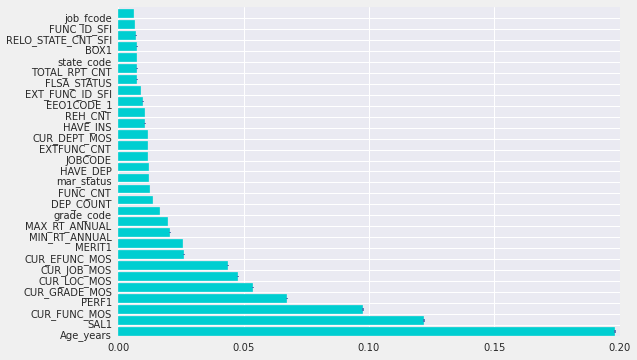

In [152]:
#for f in range(20):
nfeat = 30
plt.barh(range(nfeat),RFR_importances[RFR_indices[:nfeat]],yerr=RFR_importances_std[RFR_indices[:nfeat]],color='darkturquoise')#align="center")
plt.yticks(range(nfeat),RFR_feature_names[:nfeat])


In [ ]:
def obtain_feature_importances(classifier,plot_flag=True):
    

### make a scatter plot of the prediction and actual

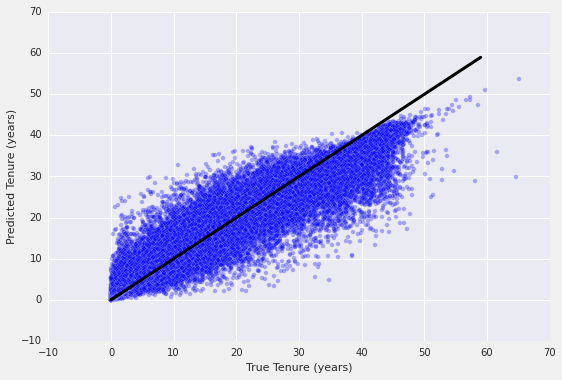

In [155]:
y_prediction = RFR.predict(X)
plt.scatter(y,y_prediction,alpha=0.3)
plt.xlabel('True Tenure (years)')
plt.ylabel('Predicted Tenure (years)')
x_line_val = np.arange(0,60)
plt.plot(x_line_val,x_line_val,lw=3,color='k')

(0, 10)

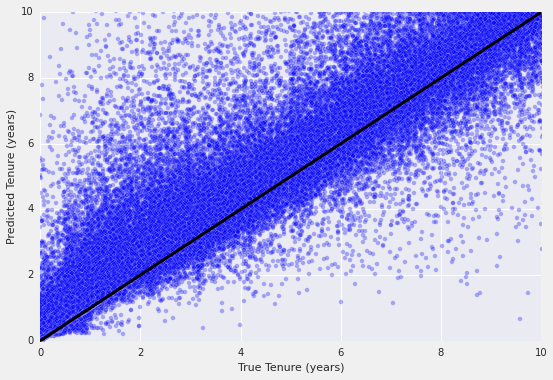

In [158]:
#zoom in on <=10 years
y_prediction = RFR.predict(X)
plt.scatter(y,y_prediction,alpha=0.3)
plt.xlabel('True Tenure (years)')
plt.ylabel('Predicted Tenure (years)')
x_line_val = np.arange(0,11)
plt.plot(x_line_val,x_line_val,lw=3,color='k')
plt.xlim(0,10)
plt.ylim(0,10)

In [160]:
# look at current employees.
np.shape(y[empl_active.index]), np.shape(X[empl_active.index,:])

((69806,), (69806, 104))

(0, 10)

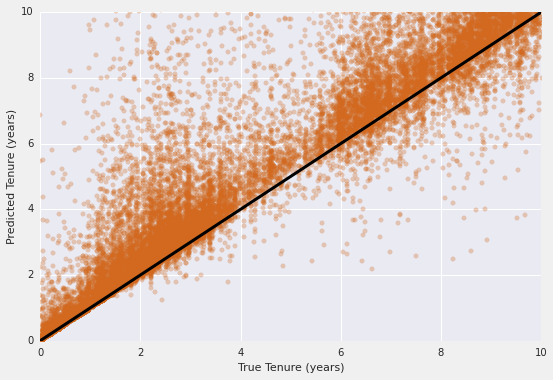

In [161]:
y_active_pred = RFR.predict(X[empl_active.index,:])
plt.scatter(y[empl_active.index],y_active_pred,alpha=0.3,color='chocolate')
plt.xlabel('True Tenure (years)')
plt.ylabel('Predicted Tenure (years)')
x_line_val = np.arange(0,11)
plt.plot(x_line_val,x_line_val,lw=3,color='k')
plt.xlim(0,10)
plt.ylim(0,10)

In [129]:
def prep_for_prediction(df,time_columns,delta_time=0.0,cols_to_drop = ['Tenure_years','status','sep_status','retired']):
    monthly_cols = [x for x in time_columns if x.endswith('MOS')]
    d2 = df.copy()
    d2[monthly_cols[:-1]]= df[monthly_cols[:-1]].apply(lambda x: x+12.0*delta_time)
    # special column is TELE_MOS
    d2[d2.REMOTE==1][monthly_cols[-1]] = df[df.REMOTE==1][monthly_cols[-1]].apply(lambda x:x+delta_time*12.0)
    
    annual_cols = [x for x in time_columns if x.endswith('years')]
    d2[annual_cols]=df[annual_cols].apply(lambda x: x+1.0*delta_time)
    d2.drop(cols_to_drop,axis=1,inplace=True)
    X = d2.as_matrix().astype(np.float)
    print X.shape
    return X,df.Tenure_years.values+1.0*delta_time

In [171]:
RFR.score(X[empl_active.index,:],y[empl_active.index])

0.94800644795269073

## what about applying this model to a future workforce?

In [166]:
def create_future_workforce(df,time_columns,delta_time=0.0,cols_to_drop = ['Tenure_years','status','sep_status','retired']):
    # deal with monthly columns
    monthly_cols = [x for x in time_columns if x.endswith('MOS')]
    d2 = df.copy()
    d2[monthly_cols[:-1]]= df[monthly_cols[:-1]].apply(lambda x: x+12.0*delta_time)
    # special column is TELE_MOS
    d2.loc[d2.REMOTE==1,monthly_cols[-1]] = df[df.REMOTE==1][monthly_cols[-1]].apply(lambda x:x+delta_time*12.0)
    #deal with annual columns
    annual_cols = [x for x in time_columns if x.endswith('years')]
    d2[annual_cols]=df[annual_cols].apply(lambda x: x+1.0*delta_time)
    d2.drop(cols_to_drop,axis=1,inplace=True)
    X = d2.as_matrix().astype(np.float)
    print X.shape
    return X,df.Tenure_years.values+1.0*delta_time

In [169]:
myX,future_y = create_future_workforce(empl_active,temporal_cols,delta_time=1.0)

(69806, 104)


In [170]:
future_y[:4], y[empl_active.index[:4]]

(array([  1.56400884,   3.05890607,   3.57637049,  40.33277206]),
 array([  0.56400884,   2.05890607,   2.57637049,  39.33277206]))

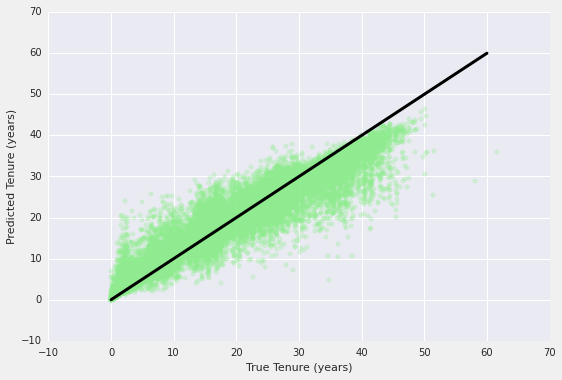

In [174]:
y_active_pred = RFR.predict(X[empl_active.index,:])
plt.scatter(y[empl_active.index],y_active_pred,alpha=0.3,color='lightgreen')
plt.xlabel('True Tenure (years)')
plt.ylabel('Predicted Tenure (years)')
x_line_val = np.arange(0,61)
plt.plot(x_line_val,x_line_val,lw=3,color='k')
#plt.xlim(0,10)
#plt.ylim(0,10)

4.13662856594
[ 0.79801615  0.        ]
 R^2 is 0.881403849156 and MSE is 15.0007167278


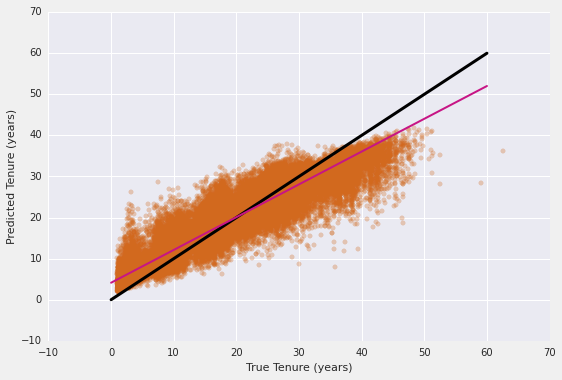

In [203]:
y_active_pred_one = RFR.predict(myX)
plt.scatter(future_y,y_active_pred_one,alpha=0.3,color='chocolate')
plt.xlabel('True Tenure (years)')
plt.ylabel('Predicted Tenure (years)')
x_line_val = np.arange(0,61)
plt.plot(x_line_val,x_line_val,lw=3,color='k')
#plt.xlim(0,10) 
#plt.ylim(0,10)
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
y_temp = (np.vstack([future_y, np.ones(len(future_y))])).T
#np.shape(y_temp)
lm.fit(y_temp,y_active_pred_one)

# print intercept and coefficients
print lm.intercept_
print lm.coef_
xx = np.linspace(0,60,120)
yy = lm.intercept_+lm.coef_[0]*xx
plt.plot(xx,yy,lw=2,color='mediumvioletred')
r2 = metrics.r2_score(future_y,y_active_pred_one)
mse = np.mean((y_active_pred_one- future_y)**2)
print " R^2 is {0} and MSE is {1}".format(r2, mse)
# plot an interval around this of 1 year
ci_alpha = 0.95


In [184]:
np.shape(y_active_pred_one), np.shape(future_y)

((69806,), (69806,))

(69806, 2)

In [191]:
import statsmodels.api as sm

model = sm.OLS(y_active_pred_one,future_y)
results = model.fit()
print " Parameters are: "
print results.params

 Parameters are: 
[ 0.97147625]


0.832448484428 15.0007167278


In [188]:
pred_one_mat = np.array(y_active_pred_one)
np.shape(pred_one_mat)

(69806,)

In [198]:
lm.fit(y_temp
       ,future_y)

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

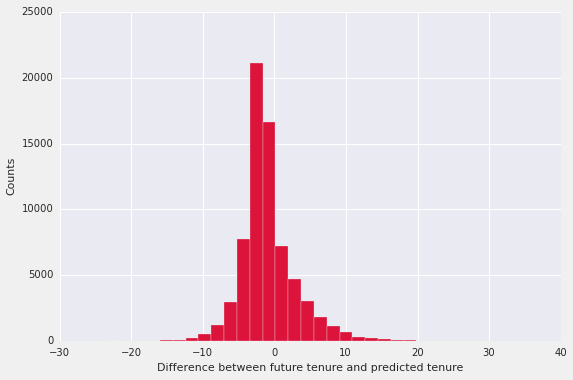

In [178]:
plt.hist(future_y - y_active_pred_one,color='crimson',bins=30)
plt.xlabel('Difference between future tenure and predicted tenure')
plt.ylabel('Counts')

### compare to ExtraTreesRegressor and Gradient Boosted Trees

In [ ]:
## so next question is whether or not there are differences in terms of the individuals 

{'bootstrap': True,
 'compute_importances': None,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_density': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200,
 'n_jobs': 30,
 'oob_score': False,
 'random_state': None,
 'verbose': 0}

## Alternative approach:
### Simply classify as separated or not --> status is target variable
* use reduced dataset
* whiten the data

In [256]:
y = empl3['status'].values.astype(np.float)
df = empl3.drop(['sep_status','retired','status'],axis=1).copy()
X = df.as_matrix().astype(np.float)
y.shape, X.shape

((199419,), (199419, 105))

In [257]:
"Fraction of separated: {0}".format(sum(y)/float(len(y)) )

'Fraction of separated: 0.649953113796'

In [258]:
# preprocess this data set (whiten it)
X = preprocessing.StandardScaler().fit_transform(X)


In [220]:
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics

In [228]:
## define my classifiers
classifiers_list = [
    linear_model.PassiveAggressiveClassifier,
    linear_model.LogisticRegression,
    neighbors.KNeighborsClassifier,
    svm.SVC,
    tree.DecisionTreeClassifier,
    ensemble.RandomForestClassifier,
    ensemble.GradientBoostingClassifier]

#neighbors.KNeighborsClassifier(n_neighbors=3),
#    svm.SVC(kernel="linear", C=0.025),
#    svm.SVC(gamma=2, C=1),
#    tree.DecisionTreeClassifier(max_depth=10,max_features='auto'),
#    ensemble.RandomForestClassifier(max_depth=10, n_estimators=500, max_features='auto',n_jobs=30),
#    ensemble.GradientBoostingClassifier(),
    #AdaBoostClassifier(),
    #linear_model.LogisticRegression()]
    #GaussianNB(),
    #LDA(),
    #QDA()]

In [259]:
%%time
y_pred = kfold_cv(X,y,classifiers_list[-2])


CPU times: user 1min 13s, sys: 1.68 s, total: 1min 15s
Wall time: 1min 15s


In [260]:
auc_score = metrics.accuracy_score(y,y_pred)
print auc_score, classifiers_list[-2]

0.988065329783 <class 'sklearn.ensemble.forest.RandomForestClassifier'>


In [261]:
print('Dump Classifier: {:.2f}'.format(metrics.accuracy_score(y, [0 for ii in y.tolist()])))

Dump Classifier: 0.35


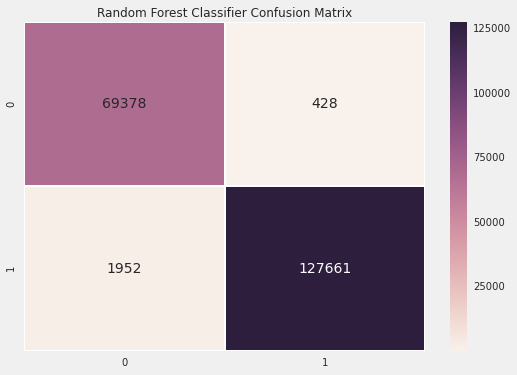

In [262]:
rfc_conf_matrix_tenure = metrics.confusion_matrix(y,y_pred)
sns.heatmap(rfc_conf_matrix_tenure, annot=True,  fmt='')
plt.title('Random Forest Classifier Confusion Matrix')

## okay so what are the features responsible for this??

In [236]:
np.shape(y_pred)

(199419,)

In [241]:
def kfold_cv2(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    k_fold = cross_validation.KFold(len(y), n_folds=n_folds, shuffle=shuffle)
    #y_pred = y.copy()
    kf_fits = []
    for ii, jj in k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        kf_fits.append(clf)
        #y_pred[jj] = clf.predict(X_test)
    return k_fold,kf_fits

In [263]:
kf_rfc,kf_fits = kfold_cv2(X,y,classifiers_list[-2])
print len(kf_fits)

10


In [278]:
kf_fits[0].get_params

<bound method RandomForestClassifier.get_params of RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)>

In [388]:
# function to plot feature_importances for RF
def plotFI(forest,featureNames=[]):
    featureImportances=forest.feature_importances_
    # sort the importances from biggest to least
    indices = np.argsort(featureImportances)[::-1]
    estimators = forest.estimators_
    # calculate the variance over the forest 
    
    std = np.std([tree.feature_importances_ for tree in estimators],axis=0)
    # print summary statement
    nfeatures = len(featureImportances)
    print("Number of Features: %d" % (nfeatures))
    print("Number of Trees: %d" %(len(estimators)))
    
    #print featureNames
    if len(featureNames)==0:
        featureNames = map(str,indices)
    
    fN2 = [featureNames[a] for a in indices]
    print("Feature ranking:")

    for f in range(len(indices)):
        print("%d. feature %d=%s (%f)" % (f + 1, indices[f], featureNames[indices[f]],featureImportances[indices[f]]))

    # Plot the feature importances of the forest
    # define a cutoff in terms of feature_importance
    if nfeatures <= 30:
        kfeatures = nfeatures # keep all if smaller than 30
    else:
        kfeatures = 30
        
    kindices = indices[:kfeatures]
    plt.title("Feature importances")
    plt.barh(range(len(kindices)), featureImportances[kindices],
       color="steelblue", xerr=std[kindices], align="center",ecolor='k')#,lw=2)
    plt.yticks(range(len(kindices)),fN2)
    #grid(True)
    c1 = 'value'
    c2 = 'std'
    tdata = np.vstack([featureImportances[indices],std[indices]])
    df = pd.DataFrame(data = tdata.T,index=fN2,columns=[c1,c2])
    return df
                      #indices, std
    #xticks(range(len(indices)), indices)
#xlim([-1, 10])

### push all of the feature importances to a data frame

Number of Features: 105
Number of Trees: 500
Feature ranking:
1. feature 22=FUNC_CNT (0.103656)
2. feature 47=HAVE_INS (0.085490)
3. feature 32=MIN_RT_ANNUAL (0.081681)
4. feature 103=MERIT1 (0.056290)
5. feature 15=EXT_FUNC_ID_SFI (0.055166)
6. feature 104=PERF1 (0.051948)
7. feature 14=EXTFUNC_CNT (0.045843)
8. feature 6=CUR_GRADE_MOS (0.030336)
9. feature 31=MAX_RT_ANNUAL (0.028577)
10. feature 42=SUPVCNT1 (0.027167)
11. feature 45=TOTAL_RPT_CNT (0.022220)
12. feature 5=CUR_FUNC_MOS (0.020009)
13. feature 4=CUR_EFUNC_MOS (0.019163)
14. feature 1=Age_years (0.019080)
15. feature 8=CUR_LOC_MOS (0.017754)
16. feature 7=CUR_JOB_MOS (0.017676)
17. feature 10=DIRECT_RPT_CNT (0.017420)
18. feature 102=SAL1 (0.016495)
19. feature 99=grade_code (0.016199)
20. feature 23=FUNC_ID_SFI (0.016073)
21. feature 3=CUR_DEPT_MOS (0.015746)
22. feature 100=job_fcode (0.015559)
23. feature 49=DEP_COUNT (0.014801)
24. feature 48=HAVE_DEP (0.014790)
25. feature 12=EFUNCCNT1 (0.014704)
26. feature 19=FTE (

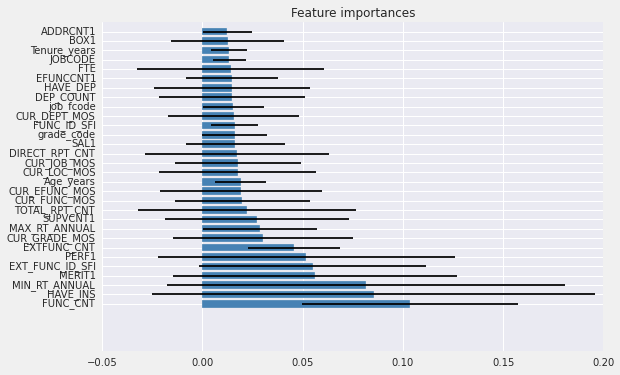

In [389]:
fivehund_5= plotFI(kf_fits500[5],df.columns)

In [390]:
fivehund_5.head()

,value,std
FUNC_CNT,0.103656,0.053966
HAVE_INS,0.085490,0.110451
MIN_RT_ANNUAL,0.081681,0.099089
MERIT1,0.056290,0.070869
EXT_FUNC_ID_SFI,0.055166,0.056572


Number of Features: 105
Number of Trees: 500
Feature ranking:
1. feature 22=FUNC_CNT (0.107459)
2. feature 32=MIN_RT_ANNUAL (0.084252)
3. feature 47=HAVE_INS (0.082011)
4. feature 15=EXT_FUNC_ID_SFI (0.062828)
5. feature 103=MERIT1 (0.054771)
6. feature 14=EXTFUNC_CNT (0.048168)
7. feature 104=PERF1 (0.047876)
8. feature 31=MAX_RT_ANNUAL (0.030456)
9. feature 6=CUR_GRADE_MOS (0.028716)
10. feature 10=DIRECT_RPT_CNT (0.023345)
11. feature 42=SUPVCNT1 (0.021829)
12. feature 45=TOTAL_RPT_CNT (0.021138)
13. feature 8=CUR_LOC_MOS (0.019315)
14. feature 5=CUR_FUNC_MOS (0.019211)
15. feature 49=DEP_COUNT (0.018209)
16. feature 1=Age_years (0.017832)
17. feature 99=grade_code (0.016750)
18. feature 23=FUNC_ID_SFI (0.016717)
19. feature 7=CUR_JOB_MOS (0.016654)
20. feature 100=job_fcode (0.016484)
21. feature 4=CUR_EFUNC_MOS (0.016237)
22. feature 48=HAVE_DEP (0.015760)
23. feature 102=SAL1 (0.015211)
24. feature 3=CUR_DEPT_MOS (0.014923)
25. feature 19=FTE (0.014821)
26. feature 12=EFUNCCNT1 (

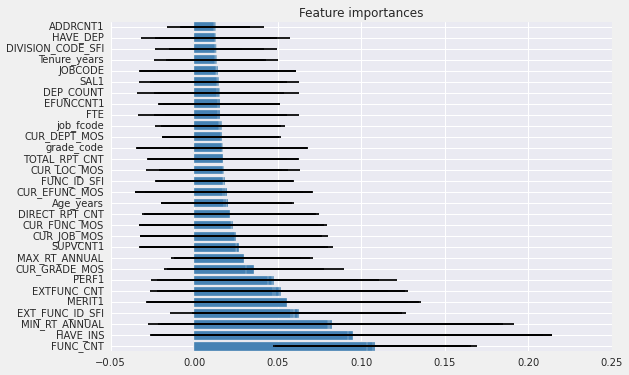

In [392]:
five_hundred_feature_importances = []
for mdl in kf_fits500:
    five_hundred_feature_importances.append(plotFI(mdl,df.columns))

In [394]:
fhfeature = pd.concat(five_hundred_feature_importances,axis=1)

In [397]:
fhfeature.columns = ['M1value','M1std','M2value','M2std','M3value','M3std','M4value','M4std','M5value','M5std',
                     'M6value','M6std','M7value','M7std','M8value','M8std','M9value','M9std','M10value','M10std']
fhfeature.head()

,M1value,M1std,M2value,M2std,M3value,M3std,M4value,M4std,M5value,M5std,M6value,M6std,M7value,M7std,M8value,M8std,M9value,M9std,M10value,M10std
ADDRCNT1,0.012404,0.012020,0.011831,0.010929,0.012623,0.012658,0.012162,0.011297,0.013073,0.012813,0.012543,0.012051,0.012720,0.012866,0.012581,0.011430,0.012443,0.012561,0.012060,0.012129
Age_years,0.017832,0.012136,0.017802,0.011668,0.019020,0.013054,0.018712,0.011921,0.018430,0.013063,0.019080,0.012863,0.018831,0.012772,0.018447,0.012300,0.018707,0.012302,0.017972,0.012014
BOX1,0.010597,0.022619,0.012981,0.028492,0.011496,0.023319,0.013296,0.028401,0.012765,0.028839,0.012630,0.028308,0.013227,0.028529,0.013244,0.030059,0.015335,0.030699,0.011382,0.024941
COMP_FREQUENCY,0.000279,0.000416,0.000323,0.000695,0.000330,0.000687,0.000404,0.001142,0.000290,0.000439,0.000316,0.000529,0.000339,0.000756,0.000352,0.000961,0.000362,0.000654,0.000312,0.000805
CUR_DEPT_MOS,0.014923,0.032911,0.015538,0.033690,0.015506,0.033874,0.014392,0.029179,0.016658,0.036035,0.015746,0.032641,0.015910,0.035233,0.015756,0.033226,0.015545,0.033813,0.015890,0.035049


In [404]:
value_columns = [x for x in fhfeature.columns if x.endswith('value')]
fhfeature[value_columns].mean(axis=1).order()

EMPL_CLASS_F        0.000000e+00
EMPL_CLASS_2        0.000000e+00
EEO1CODE_9          0.000000e+00
EMPL_CLASS_5        3.873897e-09
JOB_FUNCTION_PTM    1.405664e-08
EMPL_CLASS_P        2.193755e-08
EMPL_CLASS_G        3.192718e-08
EEO1CODE_8          3.721105e-08
EMPL_CLASS_O        8.264844e-07
EMPL_CLASS_X        1.281851e-06
EMPL_CLASS_4        1.531293e-06
EMPL_TYPE_X         2.182936e-06
JOB_FUNCTION_PTJ    6.861880e-06
JOB_FUNCTION_PTL    7.614133e-06
EEO1CODE_L          7.888600e-06
...
Age_years          0.018483
CUR_JOB_MOS        0.020122
DIRECT_RPT_CNT     0.020495
CUR_FUNC_MOS       0.020820
TOTAL_RPT_CNT      0.021734
SUPVCNT1           0.023403
MAX_RT_ANNUAL      0.028552
CUR_GRADE_MOS      0.029861
EXTFUNC_CNT        0.046582
PERF1              0.050290
MERIT1             0.051024
EXT_FUNC_ID_SFI    0.058471
MIN_RT_ANNUAL      0.079642
HAVE_INS           0.088842
FUNC_CNT           0.105125
Length: 105, dtype: float64

In [411]:
fhfeature[value_columns].max()

M1value     0.107459
M2value     0.108282
M3value     0.106113
M4value     0.104673
M5value     0.104638
M6value     0.103656
M7value     0.103098
M8value     0.107125
M9value     0.102933
M10value    0.103272
dtype: float64

In [417]:
for mx in value_columns:
    print fhfeature[fhfeature[mx] == fhfeature[mx].max()].index

Index([u'FUNC_CNT'], dtype='object')
Index([u'FUNC_CNT'], dtype='object')
Index([u'FUNC_CNT'], dtype='object')
Index([u'FUNC_CNT'], dtype='object')
Index([u'FUNC_CNT'], dtype='object')
Index([u'FUNC_CNT'], dtype='object')
Index([u'FUNC_CNT'], dtype='object')
Index([u'FUNC_CNT'], dtype='object')
Index([u'FUNC_CNT'], dtype='object')
Index([u'FUNC_CNT'], dtype='object')


In [420]:
df.HAVE_INS.value_counts()

0    116286
1     83133
dtype: int64

In [421]:
empl_active.HAVE_INS.value_counts(), empl_sep.HAVE_INS.value_counts()

(1    58123
 0    11683
 dtype: int64, 0    104603
 1     25010
 dtype: int64)

In [469]:
[kf_fits500[a].predict_proba(activX[1]) for a in xrange(0,len(kf_fits500))]

[array([[ 0.99,  0.01]]),
 array([[ 0.994,  0.006]]),
 array([[ 0.994,  0.006]]),
 array([[ 0.99,  0.01]]),
 array([[ 0.992,  0.008]]),
 array([[ 0.994,  0.006]]),
 array([[ 0.996,  0.004]]),
 array([[ 1.,  0.]]),
 array([[ 0.996,  0.004]]),
 array([[ 0.998,  0.002]])]

In [470]:
[kf_fits500[a].predict_proba(separX[1]) for a in xrange(0,len(kf_fits500))]

[array([[ 0.,  1.]]),
 array([[ 0.,  1.]]),
 array([[ 0.,  1.]]),
 array([[ 0.,  1.]]),
 array([[ 0.,  1.]]),
 array([[ 0.,  1.]]),
 array([[ 0.,  1.]]),
 array([[ 0.,  1.]]),
 array([[ 0.,  1.]]),
 array([[ 0.,  1.]])]

#### does a great job of predicitng the classes

In [375]:
kf_fits500[5].feature_importances_[indxa]

array([  1.03656106e-01,   8.54900741e-02,   8.16809271e-02,
         5.62903493e-02,   5.51656651e-02,   5.19482301e-02,
         4.58426009e-02,   3.03358801e-02,   2.85770612e-02,
         2.71672106e-02,   2.22200725e-02,   2.00094428e-02,
         1.91625045e-02,   1.90798369e-02,   1.77538752e-02,
         1.76757522e-02,   1.74200130e-02,   1.64953473e-02,
         1.61993334e-02,   1.60731365e-02,   1.57461540e-02,
         1.55591918e-02,   1.48010391e-02,   1.47902955e-02,
         1.47038462e-02,   1.41454142e-02,   1.35131840e-02,
         1.34055310e-02,   1.26297986e-02,   1.25429182e-02,
         1.18438315e-02,   9.63510825e-03,   9.42156058e-03,
         9.08262320e-03,   7.48854661e-03,   7.01517416e-03,
         6.77841553e-03,   6.27367509e-03,   6.02249730e-03,
         2.91125084e-03,   2.49883314e-03,   1.93463030e-03,
         1.84125492e-03,   1.68181772e-03,   1.63907372e-03,
         1.59160675e-03,   1.49835915e-03,   1.49655250e-03,
         1.48781054e-03,

In [252]:
def rf_feature_importances(forest,column_names):
    importances= forest.feature_importances_
    importances_std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    feature_names = column_names[indices].tolist()
    return 

Number of Features: 105
Number of Trees: 10
Feature ranking:
1. feature 22=FUNC_CNT (0.113631)
2. feature 47=HAVE_INS (0.108297)
3. feature 103=MERIT1 (0.095534)
4. feature 32=MIN_RT_ANNUAL (0.090427)
5. feature 15=EXT_FUNC_ID_SFI (0.083138)
6. feature 14=EXTFUNC_CNT (0.047178)
7. feature 6=CUR_GRADE_MOS (0.033358)
8. feature 8=CUR_LOC_MOS (0.032507)
9. feature 49=DEP_COUNT (0.028725)
10. feature 104=PERF1 (0.026266)
11. feature 101=BOX1 (0.022017)
12. feature 31=MAX_RT_ANNUAL (0.020568)
13. feature 23=FUNC_ID_SFI (0.018528)
14. feature 1=Age_years (0.018103)
15. feature 99=grade_code (0.017860)
16. feature 10=DIRECT_RPT_CNT (0.016249)
17. feature 5=CUR_FUNC_MOS (0.014912)
18. feature 100=job_fcode (0.013645)
19. feature 7=CUR_JOB_MOS (0.013533)
20. feature 0=ADDRCNT1 (0.012671)
21. feature 46=Tenure_years (0.012635)
22. feature 28=JOBCODE (0.011566)
23. feature 11=DIVISION_CODE_SFI (0.010849)
24. feature 42=SUPVCNT1 (0.010818)
25. feature 97=loc_descr (0.010476)
26. feature 44=TELE_MO

(array([ 22,  47, 103,  32,  15,  14,   6,   8,  49, 104, 101,  31,  23,
          1,  99,  10,   5, 100,   7,   0,  46,  28,  11,  42,  97,  44,
          3,   4,  45, 102,   9,  12,  27,  21,  81,  48,  17,  25,  98,
         36,  84,  59,  18,  56,  60,  82,  24,  13,  54,  80,  37,  43,
         19,  87,  61,  85,  86,  69,  39,  50,  34,  41,  58,  29,  16,
         79,  88,  35,  26,  62,  83,  40,  30,   2,  52,  38,  33,  92,
         89,  90,  51,  63,  91,  20,  53,  94,  66,  95,  55,  93,  96,
         67,  57,  78,  77,  71,  76,  75,  70,  64,  65,  73,  68,  72,  74]),
 array([  1.74411616e-02,   1.08859078e-02,   1.80438551e-04,
          4.46787950e-03,   4.66118937e-03,   8.69819342e-03,
          5.77195260e-02,   7.17060746e-03,   6.03268499e-02,
          9.85447152e-03,   2.21043549e-02,   9.19364177e-03,
          1.16411572e-02,   2.79122478e-04,   2.15757352e-02,
          6.58941535e-02,   4.23917625e-04,   3.16672484e-03,
          1.29839765e-03,   1.0575013

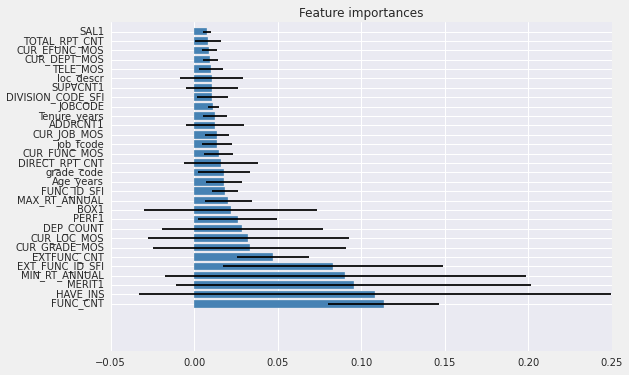

In [264]:
plotFI(kf_fits[0],df.columns)
    

Number of Features: 105
Number of Trees: 10
Feature ranking:
1. feature 32=MIN_RT_ANNUAL (0.150333)
2. feature 47=HAVE_INS (0.124328)
3. feature 22=FUNC_CNT (0.100025)
4. feature 103=MERIT1 (0.067248)
5. feature 14=EXTFUNC_CNT (0.045350)
6. feature 42=SUPVCNT1 (0.037397)
7. feature 15=EXT_FUNC_ID_SFI (0.034111)
8. feature 3=CUR_DEPT_MOS (0.030774)
9. feature 45=TOTAL_RPT_CNT (0.028266)
10. feature 5=CUR_FUNC_MOS (0.028214)
11. feature 23=FUNC_ID_SFI (0.027321)
12. feature 104=PERF1 (0.024460)
13. feature 100=job_fcode (0.020058)
14. feature 31=MAX_RT_ANNUAL (0.019817)
15. feature 6=CUR_GRADE_MOS (0.016447)
16. feature 4=CUR_EFUNC_MOS (0.015559)
17. feature 44=TELE_MOS (0.015141)
18. feature 102=SAL1 (0.013211)
19. feature 0=ADDRCNT1 (0.013019)
20. feature 1=Age_years (0.012115)
21. feature 21=FUNCCNT1 (0.012073)
22. feature 28=JOBCODE (0.011635)
23. feature 46=Tenure_years (0.011426)
24. feature 7=CUR_JOB_MOS (0.011420)
25. feature 99=grade_code (0.011305)
26. feature 11=DIVISION_CODE_

(array([ 32,  47,  22, 103,  14,  42,  15,   3,  45,   5,  23, 104, 100,
         31,   6,   4,  44, 102,   0,   1,  21,  28,  46,   7,  99,  11,
          8, 101,   9,  97,  25,  27,  10,  12,  48,  98,  81,  49,  17,
         24,  56,  29,  36,  80,  82,  59,  85,  37,  84,  13,  19,  43,
         18,  54,  60,  58,  34,  83,  39,  50,  79,  86,  41,  88,  16,
         69,  35,   2,  62,  26,  52,  61,  30,  38,  33,  51,  40,  87,
         92,  90,  20,  89,  63,  91,  53,  95,  94,  66,  93,  55,  57,
         73,  78,  77,  76,  75,  74,  71,  72,  70,  68,  67,  65,  96,  64]),
 array([  1.26157134e-02,   5.19929186e-03,   2.82024736e-04,
          5.75919685e-02,   1.88899943e-02,   5.10673765e-02,
          8.08613963e-03,   6.58578836e-03,   4.66863812e-03,
          1.70274507e-02,   4.63909620e-03,   8.30840010e-03,
          3.41961928e-03,   2.65563637e-04,   1.88144562e-02,
          1.84509456e-02,   1.58232311e-04,   9.02738716e-04,
          4.07789672e-04,   8.3935739

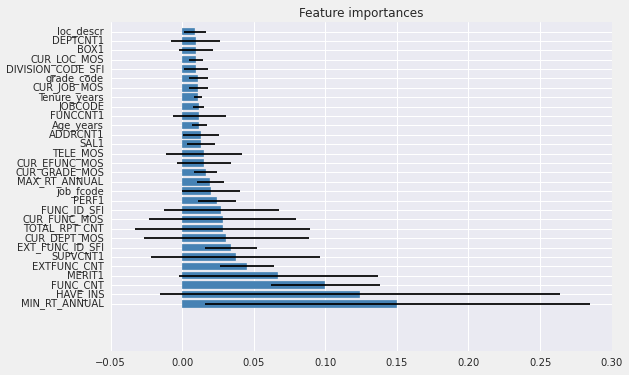

In [266]:
plotFI(kf_fits[1],df.columns)

Number of Features: 105
Number of Trees: 10
Feature ranking:
1. feature 47=HAVE_INS (0.112247)
2. feature 32=MIN_RT_ANNUAL (0.097442)
3. feature 22=FUNC_CNT (0.080588)
4. feature 103=MERIT1 (0.074896)
5. feature 14=EXTFUNC_CNT (0.053834)
6. feature 15=EXT_FUNC_ID_SFI (0.047783)
7. feature 31=MAX_RT_ANNUAL (0.034045)
8. feature 104=PERF1 (0.033322)
9. feature 45=TOTAL_RPT_CNT (0.032940)
10. feature 10=DIRECT_RPT_CNT (0.026660)
11. feature 1=Age_years (0.025199)
12. feature 42=SUPVCNT1 (0.021466)
13. feature 12=EFUNCCNT1 (0.020311)
14. feature 6=CUR_GRADE_MOS (0.019155)
15. feature 28=JOBCODE (0.018568)
16. feature 36=RELO_STATE_CNT_SFI (0.018414)
17. feature 7=CUR_JOB_MOS (0.017716)
18. feature 48=HAVE_DEP (0.017230)
19. feature 102=SAL1 (0.016675)
20. feature 99=grade_code (0.015706)
21. feature 100=job_fcode (0.014899)
22. feature 8=CUR_LOC_MOS (0.013591)
23. feature 23=FUNC_ID_SFI (0.013452)
24. feature 5=CUR_FUNC_MOS (0.012421)
25. feature 0=ADDRCNT1 (0.012051)
26. feature 40=SHIFT 

(array([ 47,  32,  22, 103,  14,  15,  31, 104,  45,  10,   1,  42,  12,
          6,  28,  36,   7,  48, 102,  99, 100,   8,  23,   5,   0,  40,
          3,  49,   4,  46,   9,  44, 101,  25,  97,  11,  81,  27,  85,
         37,  98,  21,  54,  17,  19,  60,  18,  80,  24,  56,  82,  58,
         41,  59,  13,  43,  86,  84,  39,  50,  34,  35,  29,  52,  83,
         69,  61,  88,  79,  26,  16,  87,  62,  38,  33,   2,  30,  51,
         92,  90,  89,  91,  20,  94,  93,  55,  63,  53,  95,  70,  66,
         96,  77,  76,  75,  74,  73,  68,  57,  78,  71,  67,  64,  65,  72]),
 array([  1.28200824e-02,   1.76318130e-02,   1.25852837e-04,
          6.79496251e-03,   5.28254156e-03,   2.43512536e-03,
          1.48184170e-02,   9.83807831e-03,   1.85217816e-02,
          1.44683189e-02,   6.19468220e-02,   3.51217845e-03,
          2.81859869e-02,   2.13373908e-04,   2.95640002e-02,
          3.02406661e-02,   1.48791112e-04,   8.06977626e-04,
          1.56839067e-03,   3.3447500

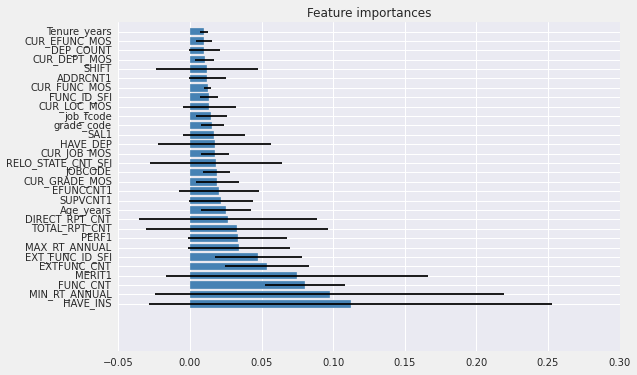

In [276]:
plotFI(kf_fits[2],df.columns)

In [ ]:
y_prob = np.zeros((len(y),2))
for ii, jj in kf:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_prob[jj] = clf.predict_proba(X_test)
        # so the prediction for the jj_th row is the prediction against the other set.
    return y_prob

In [280]:
y_prob = np.zeros((len(y),2))
for idx,(ii, jj) in enumerate(kf_rfc):
    #print len(ii), len(jj)#, idx
    X_train, X_test = X[ii],X[jj]
    #y_train = y[ii]
    print idx,"\t",kf_fits[idx].score(X_test,y[jj])
    y_prob[jj] = kf_fits[idx].predict_proba(X_test)

0 	0.988616989269
1 	0.988015244208
2 	0.986661317822
3 	0.98806538963
4 	0.98982047939
5 	0.988616989269
6 	0.991074114933
7 	0.988867716377
8 	0.98921873433
9 	0.989719673035


In [286]:
def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = metrics.roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = metrics.auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [271]:
10*(len(jj)+1)-1 == len(df)

True

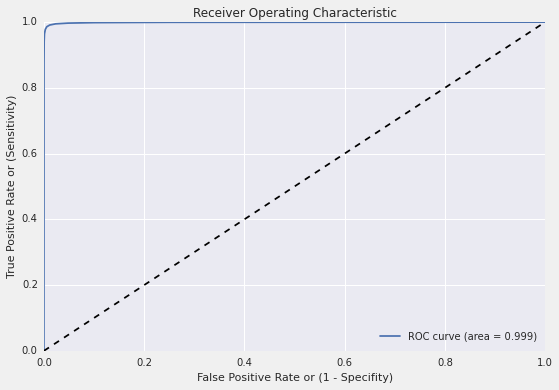

In [287]:
plot_roc_curve(y,y_prob)

In [296]:
empl_active.shape, df.shape

((69806, 108), (199419, 105))

In [328]:
empl_sep  =empl3[empl3.status == 1].copy()
empl_sep.shape

(129613, 108)

In [450]:
#separX = empl_sep[df.columns].as_matrix().astype(np.float) # DONT" DO THIS I scaled X first; use the following assignment
separX = X[empl_sep.index,:]
activX = X[empl_active.index,:]

In [298]:
#activX = empl_active[df.columns].as_matrix().astype(np.float)
activy = y[empl_active.index]# = df.as_matrix().astype(np.float)

In [451]:
kf_fits[1].predict_proba(activX)[:,0]

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [453]:
kf_fits[1].predict_proba(separX)[:,0]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [368]:
kf_rfc500,kf_fits500 = kfold_cv2(X,y,classifiers_list[-2],n_jobs=30,n_estimators=500)
print len(kf_fits500)

10


In [434]:
%%time
kf_rfc1k,kf_fits1k= kfold_cv2(X,y,classifiers_list[-2],n_jobs=50,n_estimators=1000)
print len(kf_fits1k)

10
CPU times: user 3h 59min 36s, sys: 1min 9s, total: 4h 46s
Wall time: 6min 8s


0 	0.992578477585
1 	0.992026877946
2 	0.992377895898
3 	0.992026877946
4 	0.992077023368
5 	0.992227459633
6 	0.992227459633
7 	0.993280513489
8 	0.992929495537
9 	0.992678401284
__________________________


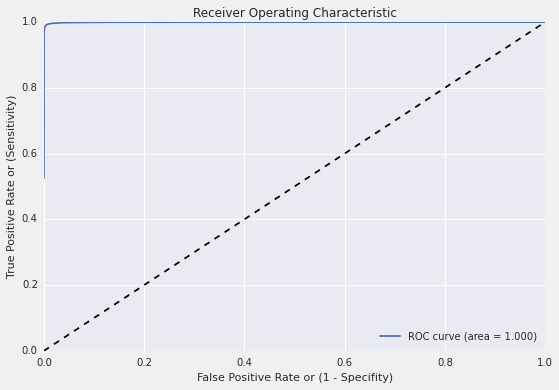

In [435]:
y_prob_1k = np.zeros((len(y),2))
for idx,(ii, jj) in enumerate(kf_rfc1k):
    #print len(ii), len(jj)#, idx
    X_train, X_test = X[ii],X[jj]
    #y_train = y[ii]
    print idx,"\t",kf_fits1k[idx].score(X_test,y[jj])
    y_prob_1k[jj] = kf_fits1k[idx].predict_proba(X_test)
print "__________________________"
plot_roc_curve(y,y_prob_1k)

## for 1000 trees, get feature importances

Number of Features: 105
Number of Trees: 1000
Feature ranking:
1. feature 22=FUNC_CNT (0.102413)
2. feature 47=HAVE_INS (0.087936)
3. feature 32=MIN_RT_ANNUAL (0.078050)
4. feature 15=EXT_FUNC_ID_SFI (0.059360)
5. feature 104=PERF1 (0.052136)
6. feature 103=MERIT1 (0.051391)
7. feature 14=EXTFUNC_CNT (0.047292)
8. feature 6=CUR_GRADE_MOS (0.031738)
9. feature 31=MAX_RT_ANNUAL (0.027645)
10. feature 42=SUPVCNT1 (0.023458)
11. feature 5=CUR_FUNC_MOS (0.022896)
12. feature 7=CUR_JOB_MOS (0.020596)
13. feature 45=TOTAL_RPT_CNT (0.020352)
14. feature 10=DIRECT_RPT_CNT (0.019907)
15. feature 1=Age_years (0.018707)
16. feature 4=CUR_EFUNC_MOS (0.018660)
17. feature 8=CUR_LOC_MOS (0.017838)
18. feature 23=FUNC_ID_SFI (0.016711)
19. feature 99=grade_code (0.016221)
20. feature 102=SAL1 (0.016218)
21. feature 100=job_fcode (0.016088)
22. feature 49=DEP_COUNT (0.015622)
23. feature 12=EFUNCCNT1 (0.014666)
24. feature 3=CUR_DEPT_MOS (0.014560)
25. feature 48=HAVE_DEP (0.014036)
26. feature 19=FTE 

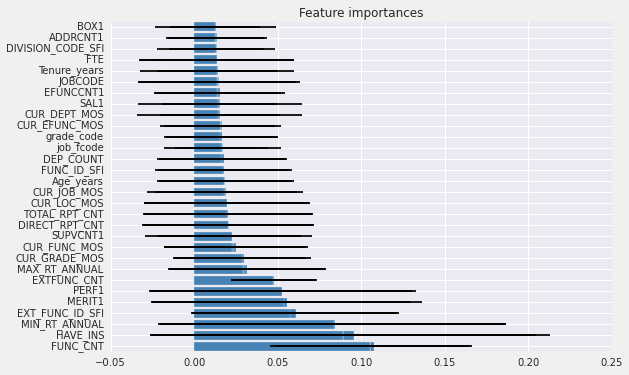

In [436]:
feature_importances_list_1k= []
for mdl in kf_fits1k:
    feature_importances_list_1k.append(plotFI(mdl,df.columns))
fi_1k_df = pd.concat(feature_importances_list_1k,axis=1)
fi_1k_df.columns = fhfeature.columns

In [438]:
df.MIN_RT_ANNUAL.head()

0    39500.00
1    22400.90
2        0.00
3    24882.50
4    31045.35
Name: MIN_RT_ANNUAL, dtype: float64

### Look at the most important feature: 'FUNC_CNT'
* this is the number of employees with the same give function
* index # is 52
* range shown below
* plot the unscaled versus scaled
* plot histogram of values in active vs inactive

In [474]:
fc_index = list(fi_1k_df.index).index('FUNC_CNT')

In [478]:
print fc_index, fi_1k_df.ix[fc_index].name
X[:,52].min(), X[:,52].max()

 52 FUNC_CNT


(-0.25223942327138027, 3.9644873391861077)

In [479]:
fc_scaled_range = [X[:,fc_index].min(),X[:,fc_index].max()]
fc_unscaled_range = [df['FUNC_CNT'].min(),df['FUNC_CNT'].max()]
#:,fc_index].min(),X[:,fc_index].max()]
print fc_scaled_range, fc_unscaled_range

[-0.25223942327138027, 3.9644873391861077] [-1.0, 37745.0]


In [484]:
len(X[:,fc_index])
len(df['FUNC_CNT'].values)

199419

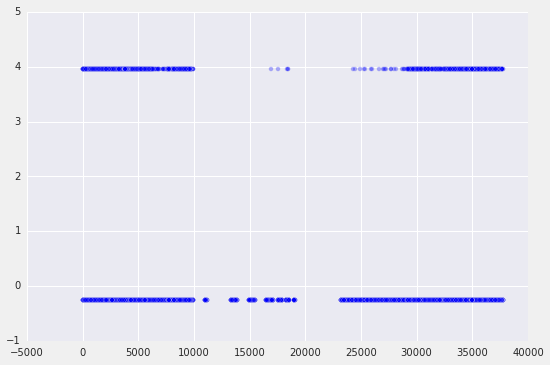

In [487]:
plt.scatter(df['FUNC_CNT'].values,X[:,fc_index],alpha=0.3)

### what??

(array([ 6.61348257,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.50104054]),
 array([-0.25223942, -0.11168186,  0.02887569,  0.16943325,  0.30999081,
         0.45054837,  0.59110593,  0.73166349,  0.87222105,  1.01277861,
         1.15333616,  1.29389372,  1.43445128,  1.57500884,  1.7155664 ,
         1.85612396,  1.99668152,  2.13723908,  2.27779663,  2.41835419,
         2.55891175,  2.69946931,  2.84002687,  2.98058443,  3.12114199,
         3.26169955,  3.4022571 ,  3.54281466,  3.68337222,  3.82392978,
         3.96448734]),
 <a list of 30 Patch objects>)

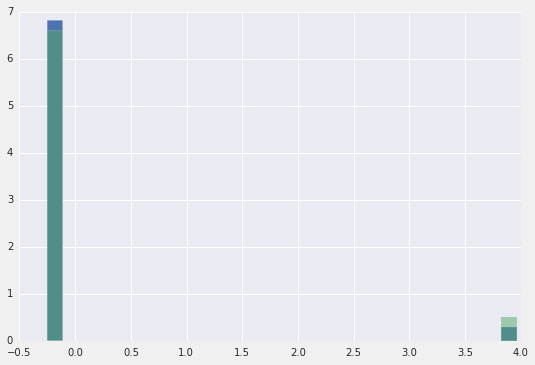

In [491]:
plt.hist(activX[:,52],range=fc_scaled_range,normed=True,bins=30)
plt.hist(separX[:,52],range=fc_scaled_range,normed=True,alpha=0.5,bins=30)

## try applying all models to the test case and checking result.
* predict is a nX1 array; value of 0 means class 0, value of 1 means class 1.
* predict proba is a nX2 array; 1st column is prediction for class 0.
* average over this value


In [454]:
class0_pred = [rf_model.predict(activX) for rf_model in kf_fits]
avg_class0_pred_active = np.mean(np.vstack(class0_pred).T, axis=1)

In [455]:
class0_pred_sep = [rf_model.predict(separX) for rf_model in kf_fits]
avg_class0_pred_sep = np.mean(np.vstack(class0_pred_sep).T, axis=1)

In [456]:
min_class0_pred_sep = np.min(np.vstack(class0_pred_sep).T, axis=1)
min_class0_pred_sep.sum()

127769.0

In [457]:
class0_pred_sep

[array([ 1.,  1.,  1., ...,  1.,  1.,  1.]),
 array([ 1.,  1.,  1., ...,  1.,  1.,  1.]),
 array([ 1.,  1.,  1., ...,  1.,  1.,  1.]),
 array([ 1.,  1.,  1., ...,  1.,  1.,  1.]),
 array([ 1.,  1.,  1., ...,  1.,  1.,  1.]),
 array([ 1.,  1.,  1., ...,  1.,  1.,  1.]),
 array([ 1.,  1.,  1., ...,  1.,  1.,  1.]),
 array([ 1.,  1.,  1., ...,  1.,  1.,  1.]),
 array([ 1.,  1.,  1., ...,  1.,  1.,  1.]),
 array([ 1.,  1.,  1., ...,  1.,  1.,  1.])]

In [352]:
empl_sep['status'].head()

0    1
2    1
3    1
5    1
6    1
Name: status, dtype: int64

In [458]:
np.min(avg_class0_pred_sep)

0.29999999999999999

(array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          5.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          9.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.40000000e+01,   0.00000000e+00,   0.00000000e+00,
          9.90000000e+01,   0.00000000e+00,   0.00000000e+00,
          3.50000000e+02,   0.00000000e+00,   0.00000000e+00,
          1.35500000e+03,   0.00000000e+00,   1.27769000e+05]),
 array([ 0.        ,  0.03333333,  0.06666667,  0.1       ,  0.13333333,
         0.16666667,  0.2       ,  0.23333333,  0.26666667,  0.3       ,
         0.33333333,  0.36666667,  0.4       ,  0.43333333,  0.46666667,
         0.5       ,  0.53333333,  0.56666667,  0.6       ,  0.63333333,
         0.66666667,  0.7       ,  0.73333333,  0.76666667,  0.8       ,
         0.83

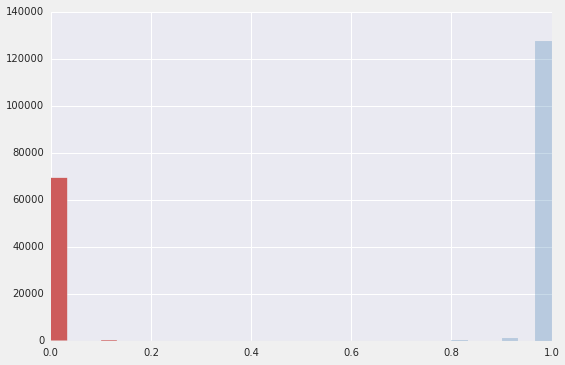

In [459]:
min_val = np.min([np.min(avg_class0_pred_active),np.min(avg_class0_pred_sep)])
max_val = np.max([np.max(avg_class0_pred_active),np.max(avg_class0_pred_sep)])
plt.hist(avg_class0_pred_active,bins=30,range=[min_val,max_val],color='indianred')
plt.hist(avg_class0_pred_sep,bins=30,range=[min_val,max_val],color='steelblue',alpha= 0.3)

## AH THIS IS WHAT I EXPECTED -- clear separation between the active and retired (see above figure)

# May 14, 2015
## Repeat RF with unscaled data

In [499]:
df.shape, empl.shape, empl2.shape, empl3.shape

((199419, 105), (199419, 202), (199419, 180), (199419, 108))

In [500]:
u = empl3.status.as_matrix().astype(np.int)
df = empl3.drop(['status','sep_status','retired'],axis=1).copy()
V = df.as_matrix().astype(np.float)

In [501]:
%%time
rf1k_kfold,rf1k_kfoldfits= kfold_cv2(V,u,classifiers_list[-2],n_jobs=50,n_estimators=1000)
print len(rf1k_kfold)

10
CPU times: user 3h 56min 41s, sys: 1min 16s, total: 3h 57min 58s
Wall time: 6min 10s


### Plot ROC curve and get AUC

In [502]:
def return_kfold_proba(X,y,kfold_mdl,kfold_fits):
    y_proba = np.zeros((len(y),2))
    for idx,(ii,jj) in enumerate(kfold_mdl):
        X_train, X_test = X[ii],X[jj]
        print idx, "\t", kfold_fits[idx].score(X_test,y[jj])
        y_proba[jj] = kfold_fits[idx].predict_proba(X_test)
    print "++++++++++++++++++++++++++++++"
    return y_proba

0 	0.993230368067
1 	0.992327750476
2 	0.991876441681
3 	0.991224551198
4 	0.99242804132
5 	0.992127168789
6 	0.993180222646
7 	0.992127168789
8 	0.992879350115
9 	0.992327365729
++++++++++++++++++++++++++++++


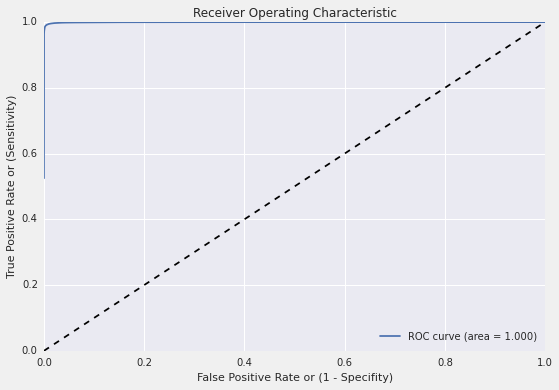

In [504]:
u_prob_1k = return_kfold_proba(V,u, rf1k_kfold,rf1k_kfoldfits)

plot_roc_curve(u,u_prob_1k)

Number of Features: 105
Number of Trees: 1000
Feature ranking:
1. feature 22=FUNC_CNT (0.104400)
2. feature 47=HAVE_INS (0.089043)
3. feature 32=MIN_RT_ANNUAL (0.075726)
4. feature 15=EXT_FUNC_ID_SFI (0.056683)
5. feature 104=PERF1 (0.054384)
6. feature 103=MERIT1 (0.051828)
7. feature 14=EXTFUNC_CNT (0.047467)
8. feature 6=CUR_GRADE_MOS (0.029235)
9. feature 31=MAX_RT_ANNUAL (0.028300)
10. feature 42=SUPVCNT1 (0.023118)
11. feature 5=CUR_FUNC_MOS (0.023056)
12. feature 7=CUR_JOB_MOS (0.020713)
13. feature 45=TOTAL_RPT_CNT (0.019883)
14. feature 10=DIRECT_RPT_CNT (0.019428)
15. feature 1=Age_years (0.019130)
16. feature 8=CUR_LOC_MOS (0.017826)
17. feature 23=FUNC_ID_SFI (0.017150)
18. feature 49=DEP_COUNT (0.016915)
19. feature 4=CUR_EFUNC_MOS (0.016638)
20. feature 99=grade_code (0.016055)
21. feature 102=SAL1 (0.015824)
22. feature 100=job_fcode (0.015804)
23. feature 3=CUR_DEPT_MOS (0.015307)
24. feature 12=EFUNCCNT1 (0.014825)
25. feature 19=FTE (0.014642)
26. feature 28=JOBCODE (

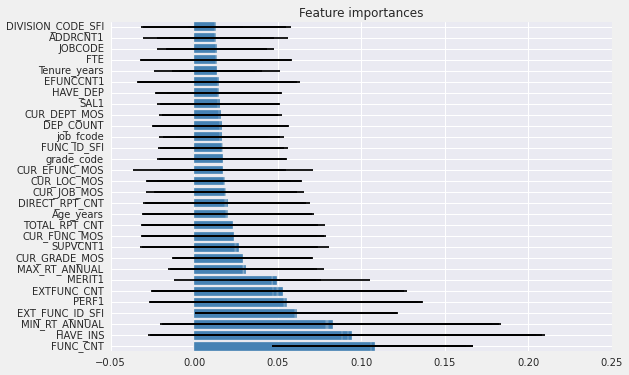

In [505]:
fi_1knew_list = []
for mdl in rf1k_kfoldfits:
    fi_1knew_list.append(plotFI(mdl,df.columns))
    
# join these together
fi_1krf_df = pd.concat(fi_1knew_list,axis=1)
fi_1krf_df.columns = fhfeature.columns

In [507]:
activV = V[empl_active.index,:]
separV = V[empl_sep.index,:]

In [510]:
df.FUNC_CNT.describe()

count    199419.000000
mean      17277.908956
std       15086.856922
min          -1.000000
25%        2334.000000
50%        8303.000000
75%       34937.000000
max       37745.000000
dtype: float64

In [515]:
empl3[empl3.FUNC_CNT == 1].status.value_counts()

1    10
0     1
dtype: int64

(array([ 0.00079479,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([ -1.00000000e+00,   1.25720000e+03,   2.51540000e+03,
          3.77360000e+03,   5.03180000e+03,   6.29000000e+03,
          7.54820000e+03,   8.80640000e+03,   1.00646000e+04,
          1.13228000e+04,   1.25810000e+04,   1.38392000e+04,
          1.50974000e+04,   1.63556000e+04,   1.76138000e+04,
          1.88720000e+04,   2.01302000e+04,   2.13884000e+04,
          2.26466000e+04,   2.39048000e+04,   2.51630000e+04,
          2.64212000e+04,   2.76794000e+04,   2.89376000e+04,
          3.01958000e+04,   3.14540000e+04,   3.27122000e+04,
  

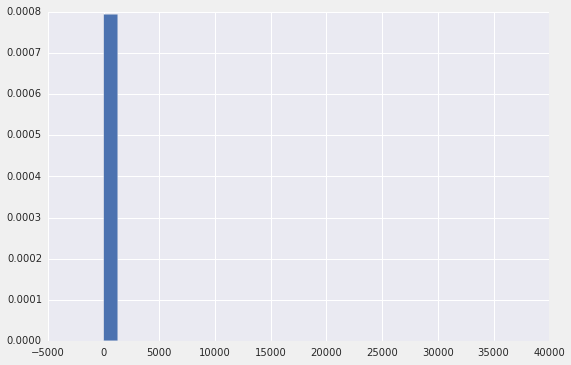

In [509]:
#plt.hist(activV[:,52],range=fc_unscaled_range,normed=True,bins=30)
#plt.hist(separV[:,52],range=fc_unscaled_range,normed=True,alpha=0.5,bins=30)

### try omitting FUNC_CNT and EXTFUNC_CNT

In [516]:
df3 = empl3.drop(['status','sep_status','retired','FUNC_CNT','EXTFUNC_CNT'],axis=1).copy()
Z = df3.as_matrix().astype(np.float)

In [517]:
%%time
rf500new,rf500fits= kfold_cv2(Z,u,classifiers_list[-2],n_jobs=50,n_estimators=500)
#print len(rf1k_kfold)

CPU times: user 1h 45min 29s, sys: 41.7 s, total: 1h 46min 11s
Wall time: 2min 49s


0 	0.981396048541
1 	0.978337177816
2 	0.979741249624
3 	0.977284123959
4 	0.978638050346
5 	0.979891685889
6 	0.979189649985
7 	0.978387323237
8 	0.977534851068
9 	0.979690085753
++++++++++++++++++++++++++++++


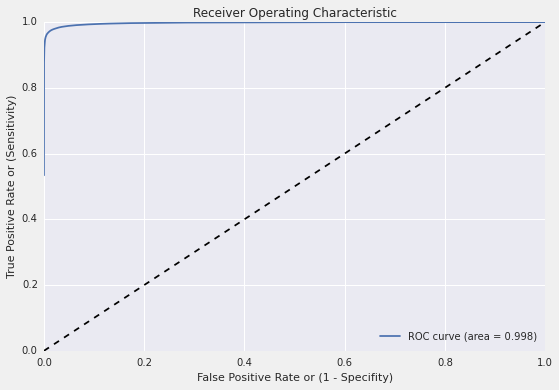

In [518]:
u_prob500n = return_kfold_proba(Z,u, rf500new, rf500fits)

plot_roc_curve(u,u_prob500n)

Number of Features: 103
Number of Trees: 500
Feature ranking:
1. feature 45=HAVE_INS (0.100759)
2. feature 30=MIN_RT_ANNUAL (0.092743)
3. feature 102=PERF1 (0.061892)
4. feature 14=EXT_FUNC_ID_SFI (0.060418)
5. feature 101=MERIT1 (0.060098)
6. feature 6=CUR_GRADE_MOS (0.039051)
7. feature 29=MAX_RT_ANNUAL (0.035703)
8. feature 40=SUPVCNT1 (0.031970)
9. feature 7=CUR_JOB_MOS (0.028265)
10. feature 1=Age_years (0.027906)
11. feature 5=CUR_FUNC_MOS (0.027461)
12. feature 43=TOTAL_RPT_CNT (0.026569)
13. feature 8=CUR_LOC_MOS (0.022844)
14. feature 3=CUR_DEPT_MOS (0.022115)
15. feature 10=DIRECT_RPT_CNT (0.021902)
16. feature 4=CUR_EFUNC_MOS (0.021363)
17. feature 44=Tenure_years (0.020402)
18. feature 100=SAL1 (0.019569)
19. feature 97=grade_code (0.017912)
20. feature 98=job_fcode (0.016832)
21. feature 46=HAVE_DEP (0.016266)
22. feature 0=ADDRCNT1 (0.015719)
23. feature 12=EFUNCCNT1 (0.015567)
24. feature 47=DEP_COUNT (0.015030)
25. feature 21=FUNC_ID_SFI (0.014249)
26. feature 99=BOX1 (

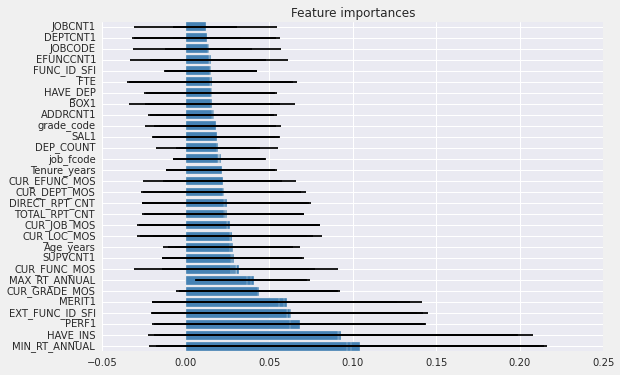

In [519]:
fi_500new_list = []
for mdl in rf500fits:
    fi_500new_list.append(plotFI(mdl,df3.columns))
    
# join these together
rffi_500n_df = pd.concat(fi_500new_list,axis=1)
rffi_500n_df.columns = fhfeature.columns

In [776]:
emplxtra_df.GRADE.value_counts()

PA2    21799
RB2    17648
PA1    13791
PA3    12882
SF4    10770
SF3     7386
MA3     6790
RA2     6165
RA3     6087
MG3     5615
RB1     4471
MA2     4443
C3      4353
MA1     3870
PA4     3804
...
IS3    2
ISM    2
AT7    2
IE4    2
IE3    1
L1     1
AT6    1
AT8    1
AT1    1
AT2    1
AT4    1
IM4    1
IS1    1
IOO    1
ZFL    1
Length: 164, dtype: int64

In [525]:
rffi_500n_df[value_columns].sort([value_columns[0]],ascending=False).head(20)

,M1value,M2value,M3value,M4value,M5value,M6value,M7value,M8value,M9value,M10value
HAVE_INS,0.100759,0.097085,0.086639,0.094171,0.090508,0.085599,0.089846,0.092772,0.096193,0.091422
MIN_RT_ANNUAL,0.092743,0.090000,0.092496,0.088985,0.095720,0.104171,0.095697,0.099245,0.091883,0.096721
PERF1,0.061892,0.061993,0.059677,0.060168,0.060671,0.051295,0.058916,0.062336,0.060835,0.062342
EXT_FUNC_ID_SFI,0.060418,0.061480,0.063916,0.061266,0.062929,0.062510,0.062738,0.068747,0.059057,0.060733
MERIT1,0.060098,0.058494,0.061352,0.059248,0.064189,0.063354,0.056793,0.057855,0.061029,0.055947
CUR_GRADE_MOS,0.039051,0.041695,0.042204,0.040217,0.043707,0.043687,0.043432,0.041645,0.043928,0.043216
MAX_RT_ANNUAL,0.035703,0.038853,0.037724,0.037132,0.036979,0.036863,0.041013,0.035965,0.039295,0.036978
SUPVCNT1,0.031970,0.026731,0.030368,0.027606,0.029890,0.026831,0.028192,0.025099,0.028478,0.026940
CUR_JOB_MOS,0.028265,0.027790,0.025055,0.027897,0.024567,0.021880,0.026840,0.027200,0.027520,0.024666
Age_years,0.027906,0.026341,0.027006,0.027043,0.027343,0.026299,0.027614,0.026707,0.026675,0.026740


In [527]:
rffi_500n_df[value_columns].mean(axis=1).order().tail(20)

job_fcode          0.017455
grade_code         0.018875
SAL1               0.020028
Tenure_years       0.021027
CUR_DEPT_MOS       0.021375
CUR_EFUNC_MOS      0.021492
DIRECT_RPT_CNT     0.023413
TOTAL_RPT_CNT      0.024360
CUR_LOC_MOS        0.024394
CUR_JOB_MOS        0.026168
Age_years          0.026968
SUPVCNT1           0.028210
CUR_FUNC_MOS       0.028285
MAX_RT_ANNUAL      0.037650
CUR_GRADE_MOS      0.042278
MERIT1             0.059836
PERF1              0.060012
EXT_FUNC_ID_SFI    0.062379
HAVE_INS           0.092499
MIN_RT_ANNUAL      0.094766
dtype: float64

### so apply time-shift.

In [531]:
temporal_cols_indices = [list(rffi_500n_df.index).index(tc) for tc in temporal_cols]
[(tc, list(rffi_500n_df.index).index(tc)) for tc in temporal_cols]

[('CUR_DEPT_MOS', 4),
 ('CUR_EFUNC_MOS', 5),
 ('CUR_FUNC_MOS', 6),
 ('CUR_GRADE_MOS', 7),
 ('CUR_JOB_MOS', 8),
 ('CUR_LOC_MOS', 9),
 ('TELE_MOS', 95),
 ('Age_years', 1),
 ('Tenure_years', 97)]

In [533]:
for idx,tci in enumerate(temporal_cols_indices):
    print temporal_cols[idx],Z[:,tci].min(),Z[:,tci].max()

CUR_DEPT_MOS -0.0322581 323.967742
CUR_EFUNC_MOS -0.0322581 323.967742
CUR_FUNC_MOS -0.0322581 303.0
CUR_GRADE_MOS -0.0322581 323.709677
CUR_JOB_MOS -0.0322581 323.935484
CUR_LOC_MOS 0.0 7.0
TELE_MOS 0.0 33.0
Age_years 15.263831564 98.1977727126
Tenure_years 0.0 163.0


In [534]:
activZ = Z[empl_active.index,:]


In [537]:
temporal_cols_indices[:6]

[4, 5, 6, 7, 8, 9]

In [554]:
## time shift rules
tdelta = 3.0
p3_actZ = activZ
p3_actZ[:,temporal_cols_indices[:6]] = activZ[:,temporal_cols_indices[:6]]+12.0*tdelta
p3_actZ[:,[1,97]] = p3_actZ[:,[1,97]]+tdelta

In [542]:

u_act = u[empl_active.index]


In [ ]:
u_active_pred3_a = rf500fits[0].pr

In [543]:
u_active_pred_a = rf500fits[0].predict(p1_actZ)

In [545]:
sum(u_active_pred_a)

1411

In [556]:
[rf500fits[a].predict_proba(p3_actZ[400])[:,0] for a in xrange(0,len(rf500fits))]

[array([ 0.87]),
 array([ 0.806]),
 array([ 0.862]),
 array([ 0.838]),
 array([ 0.864]),
 array([ 0.842]),
 array([ 0.858]),
 array([ 0.828]),
 array([ 0.85]),
 array([ 0.87])]

In [557]:
[rf500fits[a].predict_proba(activZ[400])[:,0] for a in xrange(0,len(rf500fits))]

[array([ 0.87]),
 array([ 0.806]),
 array([ 0.862]),
 array([ 0.838]),
 array([ 0.864]),
 array([ 0.842]),
 array([ 0.858]),
 array([ 0.828]),
 array([ 0.85]),
 array([ 0.87])]

In [558]:
## to combine the CV folds use , min, max, avg, median?
def generate_probabilies(X,model_list,my_class=0,method='avg'):
    class_proba = [mdl.predict_proba(X)[:,my_class] for mdl in model_list]
    gp_class_proba= np.vstack(class_proba).T
    if method == 'avg':
        agg_proba = np.mean(gp_class_proba,axis=1)
    elif method == 'max':
        agg_proba = np.max(gp_class_proba,axis=1)
    elif method == 'min':
        agg_proba = np.min(gp_class_proba,axis=1)
    elif method == 'median':
        agg_proba = np.median(gp_class_proba,axis=1)
    else:
        print "The method {0} has not been implemented yet".format(method)
        return 0
    return agg_proba


In [559]:
act_avg_1yr = generate_probabilies(p1_actZ,rf500fits)

In [563]:
act_avg_3yr = generate_probabilies(p3_actZ,rf500fits)

In [560]:
act_avg_0yr = generate_probabilies(activZ,rf500fits)

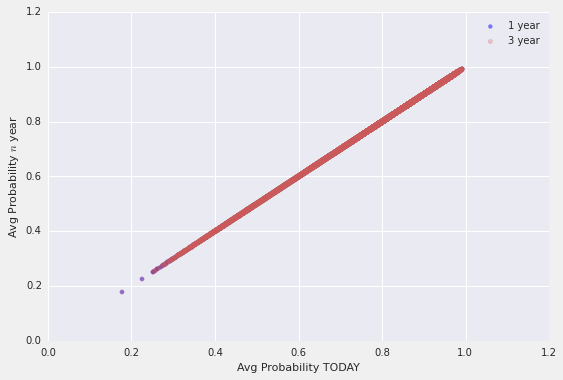

In [565]:
plt.scatter(act_avg_0yr,act_avg_1yr,label='1 year',alpha=0.5)
plt.scatter(act_avg_0yr,act_avg_3yr,label='3 year',color='indianred',alpha=0.3)
plt.xlabel('Avg Probability TODAY')
plt.ylabel('Avg Probability $n$ year')
plt.legend()

# some questions
1. how many people leave in a given year -- what is the turnover rate?
2. can I post-date the temporal components to create a validation set for a model I've made?
3. can I create a view of the predicted probability of remaining as a function of time?
    - is this just a poor-mans survival analysis?
4. what is the effect of restricting the feature space to mostly temporal features?

### get hire year and termination year -- to look at turnover rates
* need to read in extra columns (pre-procesed) from employee_dataframe8.tsv and check that they match

In [569]:
emplxtra_df = pd.read_csv('employee_dataframe8.tsv',sep='\t')
emplxtra_df.shape

/opt/anaconda/2.1.0/lib/python2.7/site-packages/pandas/io/parsers.py:1139: DtypeWarning: Columns (182) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


(199419, 184)

In [570]:
sum(emplxtra_df.Age_years - empl3.Age_years) #confirms that the difference in age is zero

0.0

In [571]:
emplxtra_df.HIRE_DT.head()


0    1967-09-25 00:00:00
1    2014-06-09 00:00:00
2    1977-10-31 00:00:00
3    1975-09-11 00:00:00
4    2012-12-10 00:00:00
Name: HIRE_DT, dtype: object

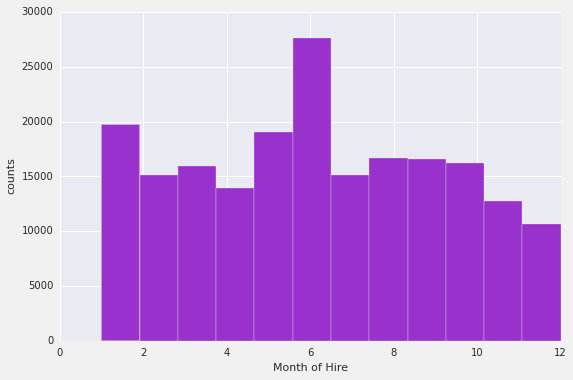

In [574]:
emplxtra_df['hire_month'] = emplxtra_df['HIRE_DT'].apply(lambda x: int(str(x)[5:7]))
emplxtra_df['hire_month'].hist(bins=12,color='darkorchid')
plt.xlabel('Month of Hire')
plt.ylabel('counts')

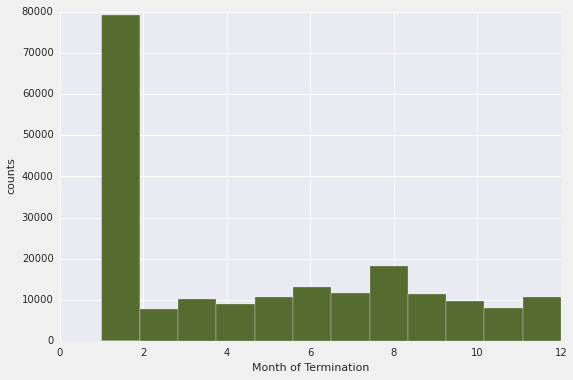

In [579]:
emplxtra_df['term_month'] = emplxtra_df['TERMINATION_DT'].apply(lambda x: int(str(x)[5:7]))
emplxtra_df['term_month'].hist(bins=12,color='darkolivegreen')
plt.xlabel('Month of Termination')
plt.ylabel('counts')

count    199419.000000
mean       1994.719264
std          12.530784
min        1933.000000
25%        1988.000000
50%        1995.000000
75%        2004.000000
max        2014.000000
dtype: float64

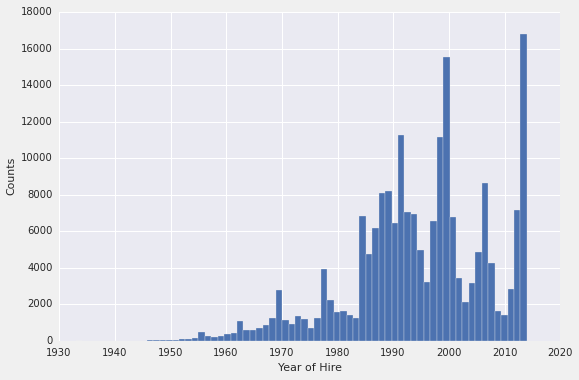

In [575]:
emplxtra_df['hire_year'] = emplxtra_df['HIRE_DT'].apply(lambda x: int(str(x)[:4]))
emplxtra_df.hire_year.hist(bins=70)
plt.xlabel('Year of Hire')
plt.ylabel('Counts')
emplxtra_df.hire_year.describe()

In [577]:
### Construct a dataframe of # active employees given the end of the month
monthly_range_terminations = pd.date_range(emplxtra_df.TERMINATION_DT.min(),emplxtra_df.TERMINATION_DT.max(),freq='M')


In [578]:
monthly_range_terminations

<class 'pandas.tseries.index.DatetimeIndex'>
[1980-01-31, ..., 2014-12-31]
Length: 420, Freq: M, Timezone: None

In [591]:
sum(emplxtra_df['HIRE_DT'].apply(lambda x: pd.to_datetime(x)) < monthly_range_terminations[0])

23445

In [593]:
# ccreate listing where they are timestamps for comparisions
empl_dates = pd.DataFrame()
empl_dates[['hire_tstmp','term_tstmp']] = emplxtra_df[['HIRE_DT','TERMINATION_DT']].apply(lambda x: pd.to_datetime(x))

In [595]:
len(empl_dates[(empl_dates.hire_tstmp < monthly_range_terminations[0]) & (empl_dates.term_tstmp > monthly_range_terminations[0])])

23444

In [626]:
monthly_range_terminations[0]-1

Timestamp('1979-12-31 00:00:00', offset='M')

In [629]:
nactive = []
nsep2 = []
nhired = []
prev_date = monthly_range_terminations[0]-1
#nsep.append(0.0)
for idx, my_date in enumerate(monthly_range_terminations):
    nactive.append( len(empl_dates[(empl_dates.hire_tstmp < my_date) &(empl_dates.term_tstmp > my_date)]))
    if idx == 0:
        nsep2.append(len(empl_dates[(empl_dates.term_tstmp <= my_date) & (empl_dates.hire_tstmp < my_date)]))
        nhired.append( len(empl_dates[(empl_dates.hire_tstmp <= my_date) &(empl_dates.hire_tstmp > prev_date)]))
    else:
        nsep2.append(len(empl_dates[(empl_dates.term_tstmp <= my_date) & (empl_dates.hire_tstmp < my_date) &( empl_dates.term_tstmp > monthly_range_terminations[idx-1])]))
        nhired.append( len(empl_dates[(empl_dates.hire_tstmp <= my_date) &(empl_dates.hire_tstmp > monthly_range_terminations[idx-1])]))
        
    #    nsep.append(sum(empl_dates.term_tstmp <= my_date) - nsep[idx-1]) 
            #ntermed = sum (empl_dates.term

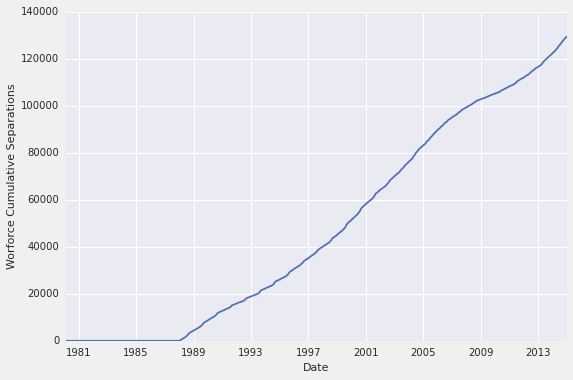

In [620]:
plt.plot(monthly_range_terminations,nsep)
plt.xlabel('Date')
plt.ylabel('Worforce Cumulative Separations')

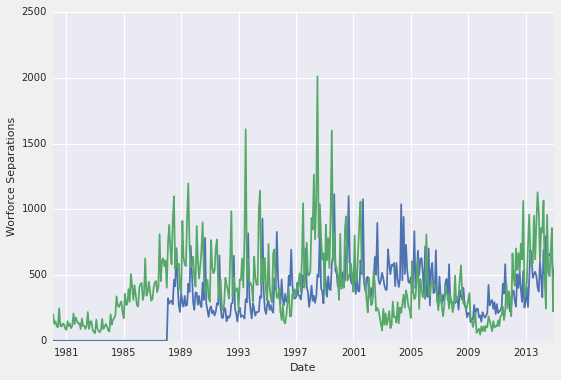

In [630]:
plt.plot(monthly_range_terminations,nsep2)
plt.plot(monthly_range_terminations,nhired)
plt.xlabel('Date')
plt.ylabel('Worforce Separations')

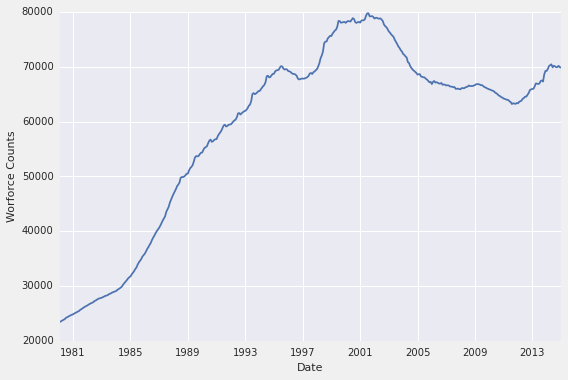

In [616]:
plt.plot(monthly_range_terminations,nactive)
plt.xlabel('Date')
plt.ylabel('Worforce Counts')

In [631]:
workforce= pd.DataFrame(data =nactive,index=monthly_range_terminations,columns=['Active'])
delta = workforce.diff()
workforce['netChange'] = delta
workforce['Separations'] = nsep2
workforce['Hires'] = nhired
workforce.head()

,Active,netChange,Separations,Hires
1980-01-31,23444,NaN,1,200
1980-02-29,23574,130,0,129
1980-03-31,23694,120,0,147
1980-04-30,23829,135,0,109
1980-05-31,23934,105,0,104


In [636]:
workforce.Active.head(12)

1980-01-31    23444
1980-02-29    23574
1980-03-31    23694
1980-04-30    23829
1980-05-31    23934
1980-06-30    24168
1980-07-31    24292
1980-08-31    24402
1980-09-30    24534
1980-10-31    24659
1980-11-30    24753
1980-12-31    24835
Freq: M, Name: Active, dtype: int64

In [632]:
workforce[workforce.Separations > 1].head()

,Active,netChange,Separations,Hires
1988-01-31,47221,424,323,744
1988-02-29,47657,436,283,882
1988-03-31,48217,560,301,702
1988-04-30,48500,283,303,582
1988-05-31,48885,385,277,910


In [635]:
annualwf = pd.DataFrame()
annualwf = workforce[['Separations','Hires']].resample('A',how='sum')#.plot()
annualwf['Active'] =workforce['Active'].resample('A',how='last')
annualwf.head()

,Separations,Hires,Active
1980-12-31,1,1591,24835
1981-12-31,0,1615,26451
1982-12-31,0,1411,27862
1983-12-31,0,1230,29086
1984-12-31,0,2678,31746


In [638]:
annualwf['NetChange'] = annualwf.Active.diff()

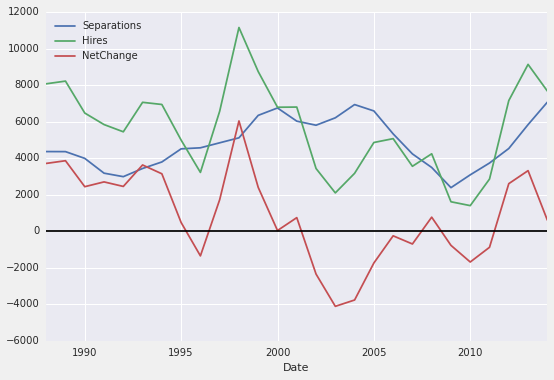

In [646]:
## restrict to after 1987
annualwf.ix['1988-1-31':,[0,1,3]].plot()
plt.xlabel('Date')
plt.axhline(0,color='k')

In [647]:
annualwf['TurnoverRate'] = annualwf['Separations']/annualwf['Active']*100.

## Working on post-dating my dataset
plan is to take a snapshot from year-end 2013 (so I know the outcome of status after 1 year) and apply my model to this to test predictive accuracy.
* Requires:
    1. elimination of employees who started (HIRE_DT) after 2013-12-31
    2. subtraction of temporal feaures by 1 year for those remaining.
* use the date information loaded for annualwf above.

In [667]:
test_date1 = pd.to_datetime('2014-01-01')
set2014active_idx = empl_dates[(empl_dates.hire_tstmp < test_date1) &(empl_dates.term_tstmp > test_date1)].index

In [668]:
emplxtra_df.ix[set2014active_idx].status.value_counts()

0    63561
1     5703
dtype: int64

In [673]:
zz_active_true = empl3.ix[set2014active_idx].status.as_matrix().astype(np.int)
#u = empl3.status.as_matrix().astype(np.int)
#y = empl3['Tenure_years'].values.astype(np.float)

In [675]:
ZZ = Z[set2014active_idx,:]
zz_active_predproba0 = rf500fits[0].predict_proba(ZZ)

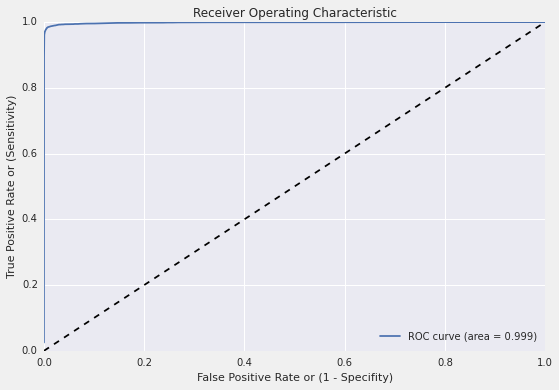

In [676]:
plot_roc_curve(zz_active_true,zz_active_predproba0)

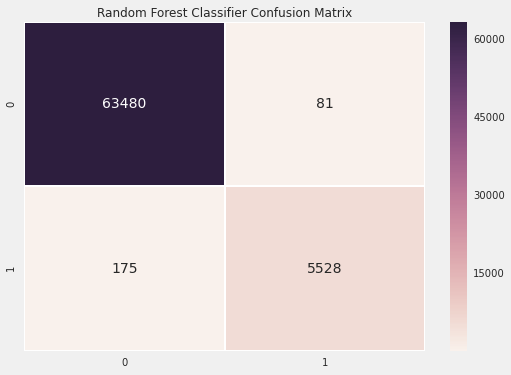

In [680]:
zz_active_pred0 = rf500fits[0].predict(ZZ)
my_conf_matrix_2014 = metrics.confusion_matrix(zz_active_true,zz_active_pred0)
sns.heatmap(my_conf_matrix_2014, annot=True,  fmt='')
plt.title('Random Forest Classifier Confusion Matrix')

In [682]:
metrics.matthews_corrcoef(zz_active_true, zz_active_pred0), metrics.accuracy_score(zz_active_true, zz_active_pred0)

(0.97539692352988683, 0.99630399630399635)

In [688]:
print (metrics.classification_report(zz_active_true, zz_active_pred0,target_names=['current','separated']))

             precision    recall  f1-score   support

    current       1.00      1.00      1.00     63561
  separated       0.99      0.97      0.98      5703

avg / total       1.00      1.00      1.00     69264



In [685]:
empl3.ix[set2014active_idx].status.value_counts()

0    63561
1     5703
dtype: int64

             precision    recall  f1-score   support

          0       0.92      1.00      0.96     63561
          1       0.00      0.00      0.00      5703

avg / total       0.84      0.92      0.88     69264



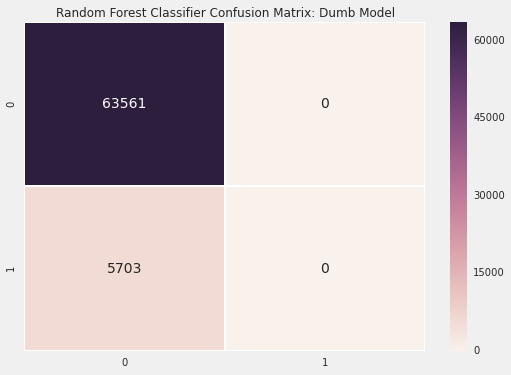

In [690]:
#dumb-classifier
zz_all_stay = np.zeros(len(zz_active_true))
print (metrics.classification_report(zz_active_true,zz_all_stay))
sns.heatmap(metrics.confusion_matrix(zz_active_true,zz_all_stay), annot=True,  fmt='')
plt.title('Random Forest Classifier Confusion Matrix: Dumb Model')

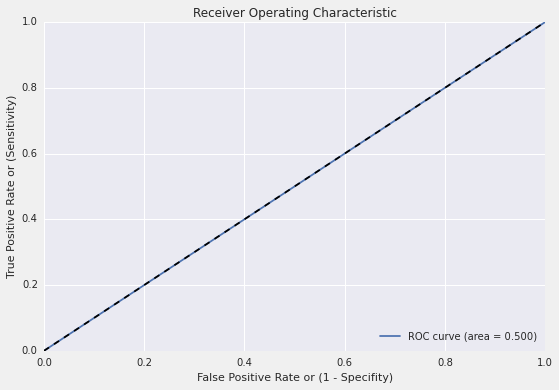

In [691]:
plot_roc_curve(zz_active_true,np.vstack([zz_all_stay,np.ones(len(zz_all_stay))]).T)

In [698]:
print [mdl.score(ZZ,zz_active_true) for mdl in rf500fits]
np.mean([mdl.score(ZZ,zz_active_true) for mdl in rf500fits])

[1.0, 0.99587087087087089, 0.99620293370293367, 0.99568318318318316, 0.99585643335643337, 0.99607299607299604, 0.99601524601524605, 0.99589974589974595, 0.99591418341418336, 0.99604412104412099]


0.99635597135597143

## combining these estimators


In [357]:
def combine_rf_estimators(rf_a,rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a

In [695]:
rf500combo = reduce(combine_rf_estimators,rf500fits) # create a combined RF model

In [697]:
rf500combo.score(ZZ,zz_active_true)

1.0

In [703]:
zz_sep_indx = np.where(zz_active_true == 1)[0]

(array([ 1664.,   758.,   537.,   512.,   518.,   484.,   448.,   369.,
          291.,   122.]),
 array([ 0.    ,  0.0441,  0.0882,  0.1323,  0.1764,  0.2205,  0.2646,
         0.3087,  0.3528,  0.3969,  0.441 ]),
 <a list of 10 Patch objects>)

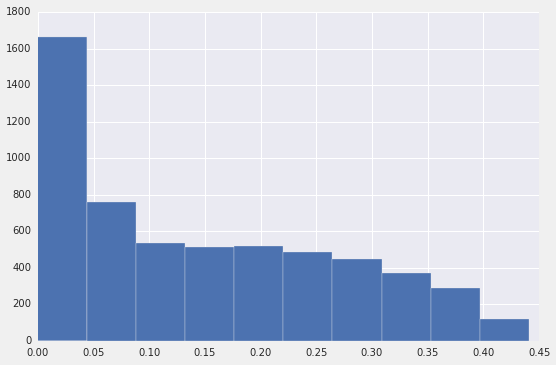

In [705]:
plt.hist(rf500combo.predict_proba(ZZ)[zz_sep_indx,0])

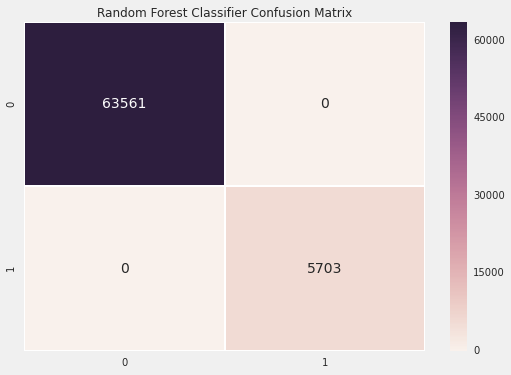

In [706]:
zz_active_pred_combo = rf500combo.predict(ZZ)
my_CM = metrics.confusion_matrix(zz_active_true,zz_active_pred_combo)
sns.heatmap(my_CM, annot=True,  fmt='')
plt.title('Random Forest Classifier Confusion Matrix')

## I legitimately fear overfitting
Let me try to reduce my dataset to employees prior to 2011, reset their status, train a model and then predict on employees from 2011 to present.

In [724]:
test_date2 = pd.to_datetime('2010-01-01')
#test_date1 = pd.to_datetime('2014-01-01')
before2010_idx = empl_dates[(empl_dates.hire_tstmp < test_date2)].index# &(empl_dates.term_tstmp > test_date2)].index
after2010_idx = list(set((empl3.index))-set(before2010_idx))
print len(before2010_idx), len(after2010_idx)
print " this amounts to a hold-out fraction of {0}".format(len(after2010_idx)/float(len(empl3)))
#len(empl3.ix[~before2011_idx])

171186 28233
 this amounts to a hold-out fraction of 0.141576279091


In [726]:
# split into test-train split
train_df = empl3.ix[before2010_idx].copy()
test_df = empl3.ix[after2010_idx].copy()


In [730]:
# reset the status of train_df if term_tstmp > test-date; also fix tenure/age, etc.
indices_to_fix = empl_dates[(empl_dates.hire_tstmp < test_date2) & (empl_dates.term_tstmp >= test_date2)].index
len(indices_to_fix)

65909

In [733]:
print empl3.status.value_counts(),
print empl3.ix[before2010_idx].status.value_counts()
print empl3.ix[indices_to_fix].status.value_counts()

1    129613
0     69806
dtype: int64 1    121072
0     50114
dtype: int64
0    50114
1    15795
dtype: int64


In [736]:
train_df.loc[indices_to_fix,'status'] = 0
train_df.status.value_counts()

1    105277
0     65909
dtype: int64

In [744]:
empl_dates.ix[46]

hire_tstmp   2008-04-07
term_tstmp   2010-08-13
Name: 46, dtype: datetime64[ns]

## try to clean up time-sensitive data in train_df
* leave MOS; just change Tenure & Age

In [743]:
train_df[['Tenure_years','Age_years']].ix[indices_to_fix]

,Tenure_years,Age_years
5,19.321410,47.379481
6,18.573961,44.693594
11,39.332772,57.638418
12,20.074334,46.993436
13,25.670616,49.739557
16,14.817553,57.578184
27,9.820872,32.589307
28,23.179121,48.849737
35,22.584995,48.222756
46,2.349124,33.511982


In [745]:
y_train = train_df.status.as_matrix().astype(np.int)
df = train_df.drop(['status','sep_status','retired'],axis=1).copy()
V = df.as_matrix().astype(np.float)

In [746]:
%%time 
rfc_500trees = ensemble.RandomForestClassifier(n_estimators=500,n_jobs=50)
CVscores = cross_validation.cross_val_score(rfc_500trees, V, y_train, cv=10)
print CVscores
CVscores.mean()

[ 0.98627256  0.98709037  0.98673988  0.98738244  0.98808342  0.98738244
  0.98890122  0.98708961  0.98831639  0.98691359]
CPU times: user 1h 25min 46s, sys: 36.3 s, total: 1h 26min 22s
Wall time: 2min 28s


In [754]:
myRFC = rfc_500trees.fit(V,y_train)

In [755]:
y_test = test_df.status.as_matrix().astype(np.int)
V_test = test_df.drop(['status','sep_status','retired'],axis=1).as_matrix().astype(np.float)

In [756]:
## apply this to the test-set
v_test_pred = rfc_500trees.predict(V_test)
v_test_predproba = rfc_500trees.predict_proba(V_test)

In [763]:
## apply this to the test-set
v_test_pred1 = myRFC.predict(V_test)
v_test_predproba1 = myRFC.predict_proba(V_test)

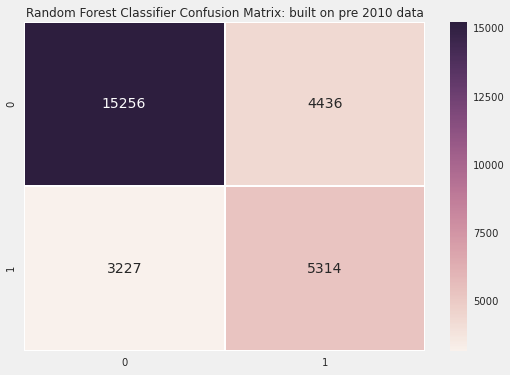

In [764]:
my_conf_matrix = metrics.confusion_matrix(y_test,v_test_pred1)
sns.heatmap(my_conf_matrix, annot=True,  fmt='')
plt.title('Random Forest Classifier Confusion Matrix: built on pre 2010 data')

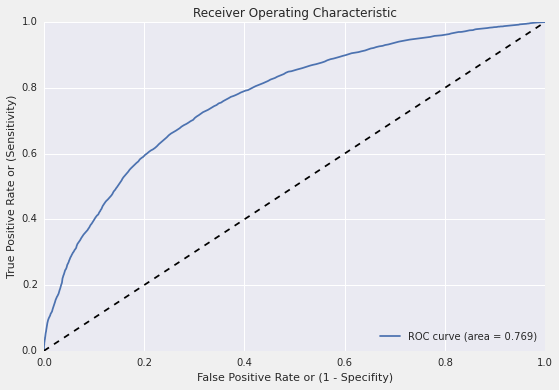

In [765]:
plot_roc_curve(y_test,v_test_predproba1)

In [766]:
myRFC.score(V_test,y_test)

0.72858003046080833

Number of Features: 105
Number of Trees: 500
Feature ranking:
1. feature 47=HAVE_INS (0.097608)
2. feature 32=MIN_RT_ANNUAL (0.089789)
3. feature 104=PERF1 (0.070429)
4. feature 6=CUR_GRADE_MOS (0.070233)
5. feature 22=FUNC_CNT (0.037541)
6. feature 14=EXTFUNC_CNT (0.036436)
7. feature 102=SAL1 (0.035384)
8. feature 46=Tenure_years (0.034828)
9. feature 49=DEP_COUNT (0.033964)
10. feature 31=MAX_RT_ANNUAL (0.031646)
11. feature 45=TOTAL_RPT_CNT (0.030548)
12. feature 48=HAVE_DEP (0.029925)
13. feature 5=CUR_FUNC_MOS (0.028851)
14. feature 7=CUR_JOB_MOS (0.026444)
15. feature 99=grade_code (0.025059)
16. feature 15=EXT_FUNC_ID_SFI (0.023977)
17. feature 8=CUR_LOC_MOS (0.023309)
18. feature 19=FTE (0.022986)
19. feature 10=DIRECT_RPT_CNT (0.021933)
20. feature 103=MERIT1 (0.019213)
21. feature 100=job_fcode (0.018211)
22. feature 4=CUR_EFUNC_MOS (0.017448)
23. feature 1=Age_years (0.017161)
24. feature 36=RELO_STATE_CNT_SFI (0.016012)
25. feature 97=loc_descr (0.014969)
26. feature 101=B

,value,std
HAVE_INS,9.760819e-02,1.396282e-01
MIN_RT_ANNUAL,8.978943e-02,1.299675e-01
PERF1,7.042924e-02,1.189865e-01
CUR_GRADE_MOS,7.023304e-02,9.006396e-02
FUNC_CNT,3.754096e-02,1.865742e-02
EXTFUNC_CNT,3.643570e-02,2.090081e-02
SAL1,3.538383e-02,7.255686e-02
Tenure_years,3.482783e-02,5.571856e-02
DEP_COUNT,3.396400e-02,7.038928e-02
MAX_RT_ANNUAL,3.164637e-02,3.978351e-02


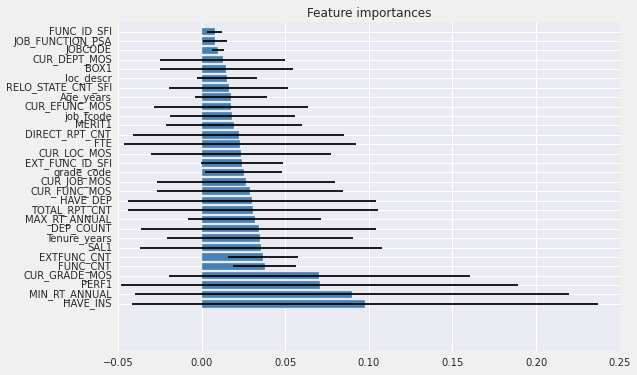

In [767]:
plotFI(myRFC,df.columns)

In [768]:
metrics.matthews_corrcoef(y_test,v_test_pred1)

0.38344110411361049

In [771]:
print(metrics.classification_report(y_test,v_test_pred1))

             precision    recall  f1-score   support

          0       0.83      0.77      0.80     19692
          1       0.55      0.62      0.58      8541

avg / total       0.74      0.73      0.73     28233



### how to combine the estimators

In [358]:
kf_fits_combo = reduce(combine_rf_estimators,kf_fits)

In [360]:
kf_fits_combo.score(X,y)

0.99998495629804585

In [460]:
np.sum(kf_fits_combo.predict(separX))

129610.0

In [461]:
class0_proba = [rf_model.predict_proba(activX)[:,0] for rf_model in kf_fits]

In [462]:
class0_proba_sep = [rf_model.predict_proba(separX)[:,0] for rf_model in kf_fits]
avg_sep_proba = np.mean(np.vstack(class0_proba_sep).T,axis=1)

In [463]:
avg_proba = np.mean(np.vstack(class0_proba).T,axis=1)
avg_proba

array([ 1.   ,  0.989,  0.988, ...,  1.   ,  1.   ,  1.   ])

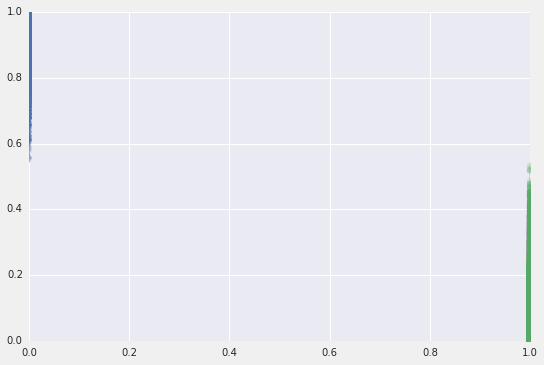

In [464]:
plt.plot(activy,avg_proba, marker='d',alpha=0.3)
plt.plot(y[empl_sep.index],avg_sep_proba,marker='h',alpha=0.2)

## I either need to retrain using the un-transformed (scaled) data or get the scaling transformation and apply it to the time-altered data

In [466]:
temporal_cols_indices = [list(fi_1k_df.index).index(tc)) for tc in temporal_cols]
[(tc, list(fi_1k_df.index).index(tc)) for tc in temporal_cols]

[('CUR_DEPT_MOS', 4),
 ('CUR_EFUNC_MOS', 5),
 ('CUR_FUNC_MOS', 6),
 ('CUR_GRADE_MOS', 7),
 ('CUR_JOB_MOS', 8),
 ('CUR_LOC_MOS', 9),
 ('TELE_MOS', 97),
 ('Age_years', 1),
 ('Tenure_years', 99)]

In [ ]:
for idx,tci in enumerate(temporal_cols_indices):
    print temporal_cols[idx],X[:,tci].min(),X[:,tci].max()

In [468]:
X[:,4].min(), X[:,4].max()

(-0.63938908020532603, 4.7048597194599004)

In [ ]:
### check the probability distrib for different models
def plot_class_probability_distribution(clf,inputX,my_class=0):
    pred_proba_mdl = clf.predict_proba(inputX)
    plt.hist(pred_proba_mdl[:,my_class],bins=30

In [334]:
pred_proba_mdl0 = kf_fits[0].predict_proba(X)


In [336]:
np.shape(pred_proba_mdl0)

(199419, 2)

(array([ 120035.,       0.,       0.,    6371.,       0.,       0.,
           1826.,       0.,       0.,     782.,       0.,       0.,
            324.,       0.,       0.,     228.,       0.,       0.,
            235.,       0.,       0.,     524.,       0.,       0.,
           1691.,       0.,       0.,    7105.,       0.,   60298.]),
 array([ 0.        ,  0.03333333,  0.06666667,  0.1       ,  0.13333333,
         0.16666667,  0.2       ,  0.23333333,  0.26666667,  0.3       ,
         0.33333333,  0.36666667,  0.4       ,  0.43333333,  0.46666667,
         0.5       ,  0.53333333,  0.56666667,  0.6       ,  0.63333333,
         0.66666667,  0.7       ,  0.73333333,  0.76666667,  0.8       ,
         0.83333333,  0.86666667,  0.9       ,  0.93333333,  0.96666667,  1.        ]),
 <a list of 30 Patch objects>)

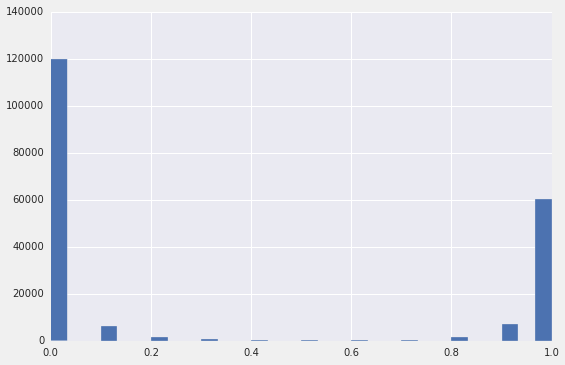

In [337]:
plt.hist(pred_proba_mdl0[:,0],bins=30)

In [326]:
np.mean([0.5, 0.5, 0.6, 0.1, 0.3, 0.5, 0.3, 0.5, 0.3, 0.2])

0.38

In [317]:
[x.T for x in class0_proba]

[array([ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5]),
 array([ 0.5,  0.4,  0.2, ...,  0.3,  0.2,  0.5]),
 array([ 0.6,  0.4,  0.1, ...,  0.3,  0.1,  0.3]),
 array([ 0.1,  0.3,  0.3, ...,  0.2,  0.3,  0.2]),
 array([ 0.3,  0.3,  0.3, ...,  0.3,  0.4,  0.4]),
 array([ 0.5,  0.4,  0.5, ...,  0.4,  0.4,  0.4]),
 array([ 0.3,  0.5,  0.5, ...,  0.4,  0.3,  0.4]),
 array([ 0.5,  0.1,  0.5, ...,  0.1,  0.4,  0.1]),
 array([ 0.3,  0.1,  0.1, ...,  0.1,  0.2,  0.1]),
 array([ 0.2,  0.1,  0.1, ...,  0.1,  0.2,  0.1])]

In [311]:
avg_pred

[0.48978454574105379,
 0.30066613185113022,
 0.21715755092685443,
 0.20519153081397015,
 0.34001231985789188,
 0.42987852047101971,
 0.37529868492679713,
 0.3224565223619747,
 0.19427413116351033,
 0.14700312294072143]

In [288]:
#from sklearn.cross_validation import cross_val_score
rfc_500trees = ensemble.RandomForestClassifier(n_estimators=500,n_jobs=30)
CVscores = cross_validation.cross_val_score(rfc_500trees, X, y, cv=10)
CVscores

array([ 0.99162613,  0.99172642,  0.99237828,  0.99167586,  0.99212717,
        0.99313008,  0.99317988,  0.99247781,  0.99242766,  0.99292914])

In [292]:
CVscores.mean()

0.99236784316347337

In [ ]:
[(clf,metrics.accuracy_score(y,kfold_cv(X,y,clf))) for clf in classifiers_list]

In [ ]:
### Gradient Boosted Trees

In [206]:
ensemble.GradientBoostingClassifier?
#r(n_estimators=100, max_depth=3, loss='ls')

### define classes as [0,1,2,3,4,5,6-10,11-15,over]

In [195]:
y_tenure_class = pd.cut(empl2.Tenure_years,[-1,0,1,2,3,4,5,10,15,200],labels=False)#,labels=[1,2,3,4,5,6,7,8])#.values
y_tenure_class

array([8, 1, 8, ..., 7, 7, 8])

In [187]:
df = empl2.drop(['Tenure_years','status','sep_status','retired'],axis=1).copy()
X = df.as_matrix().astype(np.float)
y_tenure_class.shape, X.shape

((199419,), (199419, 176))

In [197]:
tenure_classes = list(set(list(y_tenure_class)))
print tenure_classes
[(x,list(y_tenure_class).count(x)) for x in tenure_classes]
#list(y_tenure_class).count(1)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


[(0, 175),
 (1, 34396),
 (2, 21244),
 (3, 15082),
 (4, 9552),
 (5, 6376),
 (6, 29536),
 (7, 18399),
 (8, 64659)]

In [75]:
from sklearn import cross_validation
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics

In [88]:
def kfold_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    k_fold = cross_validation.KFold(len(y), n_folds=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    for ii, jj in k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

In [76]:
def kfold_cv_proba(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    k_fold = cross_validation.KFold(len(y), n_folds=n_folds, shuffle=shuffle)
    y_prob = np.zeros((len(y),2))
    for ii, jj in k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_prob[jj] = clf.predict_proba(X_test)
    return y_prob

In [97]:
print('Dump Classifier: {:.2f}'.format(metrics.accuracy_score(y_tenure_class, [0 for ii in y_tenure_class.tolist()])))

Dump Classifier: 0.17


In [204]:
%%time
print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(y_tenure_class, kfold_cv(X, y_tenure_class, neighbors.KNeighborsClassifier))))

K Nearest Neighbor Classifier: 0.72
CPU times: user 19min 27s, sys: 847 ms, total: 19min 28s
Wall time: 19min 27s


In [207]:
k_neighbors_conf_matrix = metrics.confusion_matrix(y_tenure_class, kfold_cv(X, y_tenure_class, neighbors.KNeighborsClassifier))

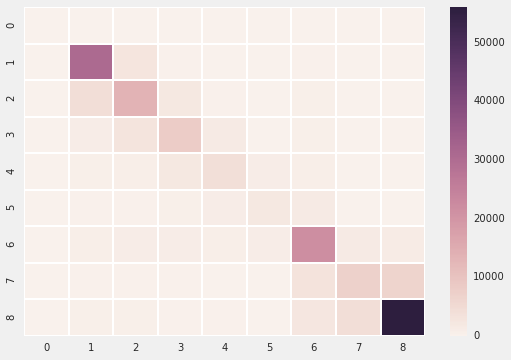

In [210]:
sns.heatmap(k_neighbors_conf_matrix, annot=False)

In [217]:
# truth: 
[(a,sum(y_tenure_class==a)) for a in tenure_classes]

[(0, 175),
 (1, 34396),
 (2, 21244),
 (3, 15082),
 (4, 9552),
 (5, 6376),
 (6, 29536),
 (7, 18399),
 (8, 64659)]

In [218]:
pred_tenure_class = kfold_cv(X,y_tenure_class, neighbors.KNeighborsClassifier)
len(pred_tenure_class)

199419

In [222]:
np.shape(k_neighbors_conf_matrix)

(9, 9)

In [223]:
k_neighbors_conf_matrix[:,0]

array([ 7, 11,  1,  2,  0,  0,  4,  0,  1])

In [224]:
k_neighbors_conf_matrix

array([[    7,   164,     2,     1,     0,     0,     1,     0,     0],
       [   11, 30714,  2769,   351,   115,    43,   248,    40,   105],
       [    1,  4238, 13649,  2262,   263,    94,   452,    81,   204],
       [    2,  1158,  2990,  8314,  1620,   185,   532,    75,   206],
       [    0,   634,   743,  2213,  4109,   889,   688,    84,   192],
       [    0,   375,   362,   528,  1306,  1995,  1557,    95,   158],
       [    4,   867,   939,   882,   833,  1265, 21676,  1725,  1345],
       [    0,   372,   359,   262,   213,   159,  3207,  7214,  6613],
       [    1,   502,   555,   421,   270,   169,  2530,  4180, 56031]])

## well this is OK, but not great

In [ ]:
print('K Nearest Neighbor Classifier:\n {}\n'.format(metrics.classification_report(y_tenure_class, kfold_cv(X, y_tenure_class, neighbors.KNeighborsClassifier))))

In [ ]:
#y_tenure = empl2.Tenure_years.apply(lambda x: np.round(x,0))
#y_tenure.value_counts()

### since the goal is to determine number of separation in a future time point, maybe I should create a target that is the number of tenure years.

## first test is to predict on separation at all (status)

In [ ]:
y = empl.status.as_matrix().astype(np.int)
df = empl.drop(['status','sep_status','retired'],axis=1).copy()
X = df.as_matrix().astype(np.float)

In [ ]:
y.shape, X.shape

So I have 199419 instances and 203 features

####Next scale them by removing mean and dividing by standar deviation.

In [ ]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)


In [ ]:
from sklearn import cross_validation

In [ ]:
cross_validation.KFold?

### use K-fold Cross-validation --> my classes are not too unbalanced

In [ ]:
def kfold_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    k_fold = cross_validation.KFold(len(y), n_folds=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    for ii, jj in k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

In [ ]:
np.shape(y)

In [ ]:
kf = cross_validation.KFold(len(y),n_folds =10,shuffle=True)


In [ ]:
kfold_cv(X,y,linear_model.PassiveAggressiveClassifier)

In [ ]:
from sklearn import cross_validation
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics

In [ ]:
print('Passive Aggressive Classifier: {:.2f}'.format(metrics.accuracy_score(y, kfold_cv(X, y, linear_model.PassiveAggressiveClassifier))))
print('Gradient Boosting Classifier:  {:.2f}'.format(metrics.accuracy_score(y, kfold_cv(X, y, ensemble.GradientBoostingClassifier))))
print('Support vector machine(SVM):   {:.2f}'.format(metrics.accuracy_score(y, kfold_cv(X, y, svm.SVC))))
print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(y, kfold_cv(X, y, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(y, kfold_cv(X, y, neighbors.KNeighborsClassifier))))
print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y, kfold_cv(X, y, linear_model.LogisticRegression))))

In [ ]:
print('Dump Classifier: {:.2f}'.format(metrics.accuracy_score(y, [0 for ii in y.tolist()])))

## Confusion Matrix

In [ ]:
pass_agg_conf_matrix = metrics.confusion_matrix(y,kfold_cv(X, y, linear_model.PassiveAggressiveClassifier))
grad_ens_conf_matrix = metrics.confusion_matrix(y, kfold_cv(X, y, ensemble.GradientBoostingClassifier))
decision_conf_matrix = metrics.confusion_matrix(y, kfold_cv(X, y, tree.DecisionTreeClassifier))
ridge_clf_conf_matrix = metrics.confusion_matrix(y, kfold_cv(X, y, linear_model.RidgeClassifier))
svm_svc_conf_matrix = metrics.confusion_matrix(y, kfold_cv(X, y, svm.SVC))
random_forest_conf_matrix = metrics.confusion_matrix(y, kfold_cv(X, y, ensemble.RandomForestClassifier))
k_neighbors_conf_matrix = metrics.confusion_matrix(y, kfold_cv(X, y, neighbors.KNeighborsClassifier))
logistic_reg_conf_matrix = metrics.confusion_matrix(y, kfold_cv(X, y, linear_model.LogisticRegression))
dumb_conf_matrix = metrics.confusion_matrix(y, [0 for ii in y.tolist()]); # ignore the warning as they are all 0

conf_matrix = {
                1: {
                    'matrix': pass_agg_conf_matrix,
                    'title': 'Passive Aggressive',
                   },
                2: {
                    'matrix': grad_ens_conf_matrix,
                    'title': 'Gradient Boosting',
                   },
                3: {
                    'matrix': decision_conf_matrix,
                    'title': 'Decision Tree',
                   },
                4: {
                    'matrix': ridge_clf_conf_matrix,
                    'title': 'Ridge',
                   },
                5: {
                    'matrix': svm_svc_conf_matrix,
                    'title': 'Support Vector Machine',
                   },
                6: {
                    'matrix': random_forest_conf_matrix,
                    'title': 'Random Forest',
                   },
                7: {
                    'matrix': k_neighbors_conf_matrix,
                    'title': 'K Nearest Neighbors',
                   },
                8: {
                    'matrix': logistic_reg_conf_matrix,
                    'title': 'Logistic Regression',
                   },
                9: {
                    'matrix': dumb_conf_matrix,
                    'title': 'Dumb',
                   },
}

In [ ]:
fix, ax = plt.subplots(figsize=(16, 12))
plt.suptitle('Confusion Matrix of Various Classifiers')
for ii, values in conf_matrix.items():
    matrix = values['matrix']
    title = values['title']
    plt.subplot(3, 3, ii) # starts from 1
    plt.title(title);
    sns.heatmap(matrix, annot=True,  fmt='');

## get hire year

In [ ]:
atime = empl_bene['HIRE_DT'].ix[0]
str(atime)

In [ ]:
str(atime)[5:7]

## how many are there if we require hire_date > some date?


In [ ]:
empl_bene.HIRE_DT.ix[0]

In [ ]:
test_hire_date = pd.to_datetime('2002-11-30') #datetime(2002,11,30)
test_hire_date

In [ ]:
emplB = empl_bene[empl_bene.HIRE_DT > test_hire_date].copy()
print len(emplB)
print emplB.status.value_counts()
print emplB.sep_status.value_counts()


In [ ]:
#test_term_date = #test_hire_date
test_term_date = pd.to_datetime('2002-12-31')
emplC= empl[empl.TERMINATION_DT > test_term_date].copy()
print len(emplC)
print emplC.status.value_counts()
print emplC.sep_status.value_counts()

In [ ]:
emplC.RATE1.value_counts()

In [ ]:
def split_rate_column(x):
    list_of_defined_values = ['R1C1','R1C2','R1C3',
                              'R2C1','R2C2','R2C3',
                              'R3C1','R3C2','R3C3']
    #rcol=[]
    #ccol=[]
    if x in list_of_defined_values:
        rval = int(x[1])#col.append(x[1])
        cval = int(x[3]) #col.append(x[3])
        #print x[1],x[3]
    else:
        #rcol.append(0)
        #ccol.append(0)
        rval = 0
        cval = 0
    return rval,cval

In [ ]:
#rcol,ccol = 
input_column = 'RATE1'
rval = [x[0] for x in emplC[input_column].apply(lambda(x): split_rate_column(x)).as_matrix()]
cval = [x[1] for x in emplC[input_column].apply(lambda(x): split_rate_column(x)).as_matrix()]

In [ ]:
emplC[input_column+'_R'] = rval
emplC[input_column+'_C'] = cval
emplC[['RATE1','RATE1_R','RATE1_C']].head()

In [ ]:
def convert_rate_column(df,input_column):
    rval = [x[0] for x in df[input_column].apply(lambda(x): split_rate_column(x)).as_matrix()]
    cval = [x[1] for x in df[input_column].apply(lambda(x): split_rate_column(x)).as_matrix()]
    df[input_column+'_R'] = rval
    df[input_column+'_C'] = cval
    df.drop(input_column,inplace=True,axis=1)
    return df

In [ ]:
### convert the RATINGS columns
for col in ['RATE1','RATE2','RATE3','RATE4','RATE5','RATE6','RATE7','RATE8','RATE9','RATE10']:
    print col
    emplC = convert_rate_column(emplC,col)

In [ ]:
emplC.shape

## begin to Standardize some of these other columns



In [ ]:
empltbl3.EMPL_CLASS.value_counts(), empltbl3.EMPL_CLASS.unique()

In [ ]:
empltbl3.EMPL_TYPE.value_counts()

In [ ]:
pd.crosstab(empltbl3.EMPL_TYPE,empltbl3.EMPL_CLASS)

In [ ]:
pd.crosstab(empl.COMPANY,empl.EMPL_TYPE)

In [ ]:
pd.crosstab(empl.COMPANY,empl.EMPL_CLASS)

In [ ]:
pd.crosstab(emplC.COMPANY,emplC.EMPL_CLASS)

In [ ]:
empl[empl.COMPANY=='049'].LOC_STATE.value_counts()

In [ ]:
empl.COMPANY.value_counts()

In [ ]:
sdfC[sdfC.arity>4].sort('arity')

In [ ]:
print len(empltbl3.LEGACY_DEPT_SFI.unique())

In [ ]:
empltbl3.LEGACY_DEPT_SFI.value_counts()

In [ ]:
sdfC[sdfC['arity']<40000].sort('arity',ascending=False)

In [ ]:
len(empltbl3.LOCATION.unique()

In [ ]:
Bcolumns_without_missing_values = list(sdfB[sdfB.x_missing == 0].Column.values)
Bcolumns_with_missing_values = list(sdfB[sdfB.x_missing > 0].Column.values)
print len(Bcolumns_with_missing_values), len(sdfB)

In [ ]:
sdfB.sort('x_missing',ascending=False)

In [ ]:
sdf2 = summarize_dataframe2(empl)

In [ ]:
sdf2['x_missing'] = sdf2['nmissing']/len(empl)
sdf2.sort('x_missing',ascending=False)

In [ ]:
columns_with_missing_values2 = list(sdf2[sdf2.x_missing>0].Column.values)
len(columns_with_missing_values2)

In [ ]:
sdf2[(sdf2.x_missing>0) & (sdf2.datatype != 'float64')]#.datatype.unique()

In [ ]:
print len(empl.RATE1.unique()), 
print empl.RATE1.unique()

In [ ]:
empl.RATE1.value_counts()

In [ ]:
len(empl[empl.RATE1 == 'R3C1'])

In [ ]:
empl[empl.RATE1 == 'COMM']['TERMINATION_DT'].describe()#max()#[['hire_year','TERMINATION_DT','status','sep_status']]

In [ ]:
print sum(empl_bene.MAR_STATUS_DT.isnull())
empl_bene[empl_bene.MAR_STATUS_DT.isnull()][['HIRE_DT','TERMINATION_DT','MAR_STA_SNAME_SFI']]

In [ ]:

#empl_bene.drop('STATE',axis=1,inplace=True)
#pd.crosstab(empl_bene['STATE'],empl_bene['LOC_STATE'])

In [ ]:
set(columns_with_missing_values)-set(Bcolumns_with_missing_values)

In [ ]:
# look at these distributions
plt.figure(figsize=(12,8))
emplC[emplC.status==0].Age_years.hist(bins=70,range=[15,84],color='darkred',label='current',alpha=0.8,normed=True)
emplC[emplC.status==1].Age_years.hist(bins=70,range=[15,84],color='dodgerblue',label='former',alpha=0.5,normed=True)
plt.legend()
plt.xlabel('Age in years')
plt.ylabel('Normed Counts')
plt.title('Distribution of Worforce Ages')

In [ ]:
# look at these distributions
plt.figure(figsize=(12,8))
emplB[emplB.status==0].Tenure_years.hist(bins=36,range=[0,35],color='darkred',label='current',alpha=0.8,normed=True)
emplB[emplB.status==1].Tenure_years.hist(bins=36,range=[0,35],color='dodgerblue',label='former',alpha=0.5,normed=True)
plt.legend()
plt.xlabel('Age in years')
plt.ylabel('Normed Counts')
plt.title('Distribution of Worforce Ages')

In [ ]:
empl_bene.zip5.value_counts()

In [ ]:
empl_bene.COMP_FREQUENCY.head()

In [ ]:
##
empl_bene['COMP_FREQ_ANNUAL'] = 1
empl_bene.loc[empl_bene['COMP_FREQUENCY']=='H','COMP_FREQ_ANNUAL'] = 0
empl_bene.drop('COMP_FREQUENCY',axis=1,inplace=True)

## Save this dataframe as a tab separated file

In [ ]:
outfile1 = 'employee_dataframe.tsv'
save_dataframe_file = True
if save_dataframe_file:
    empltbl3.to_csv(outfile1,sep='\t')

## convert datetime64[ns] format to a string ---> YYYY-MM-DD 
use date_columns

In [ ]:
for c in date_columns:
    empltbl3[c]= empltbl3[c].apply(lambda x: str(x).split(' ')[0])

In [ ]:
for col in empltbl3.columns:
    my_dtype = empltbl3[col].dtype
    if my_dtype != 'object' and my_dtype != 'float64' and my_dtype != 'int64':
        print col, "\t", empltbl3[col].dtype, "\t",empltbl3[col].ix[8] 

In [ ]:
### try converting the timedeltas to floats
empltbl3['Age_tdelta'].ix[3].astype('float')/(60*60*24*10**9)

In [ ]:
nano2days = 60.*60.*24.*10**9
empltbl3['Age_days'] = empltbl3['Age_tdelta'].apply(lambda x: x.astype('float')/(nano2days))
empltbl3['Tenure_days'] = empltbl3['Tenure_tdelta'].apply(lambda x: x.astype('float')/(nano2days))

In [ ]:
empltbl3.drop(['Age_tdelta','Tenure_tdelta'], axis=1,inplace=True)
empltbl3.shape

In [ ]:
len(empltbl3.Age_days.unique()), len(empltbl3.Tenure_days.unique())

In [ ]:
empltbl.Age_years.ix[:10].apply(lambda x: int(np.round(x,0)))

In [ ]:
# Keep just the year
empltbl_dates = empltbl[date_columns].copy() # save the dates.
for c in date_columns:
    #print c
    if c.endswith('DT'):
        c2 = c[:-2]+'YEAR'
    else:
        c2 = c[:-4]+'_YEAR'
    #print c2
    empltbl[c2]= empltbl[c].apply(lambda x: x[:4])

In [ ]:
empltbl.drop(date_columns,axis=1,inplace=True)

In [ ]:
empltbl['Age_year_int'] = empltbl['Age_years'].apply(lambda x: int(np.round(x,0)))
empltbl['Tenure_year_int'] = empltbl['Tenure_months'].apply(lambda x: int(np.round(x/12,0)))

In [ ]:
len(empltbl.Age_year_int.unique()), len(empltbl.Tenure_year_int.unique())

In [ ]:
empltbl.Tenure_year_int.value_counts().plot(kind='bar',color='darkslateblue')

In [ ]:
#now save this version for H2O
outfile2 = 'employee_dataframe2.ssv'
save_dataframe_file = True
if save_dataframe_file:
    empltbl.to_csv(outfile2,sep=';')

In [ ]:
empltbl.shape

In [ ]:
# duplicated employee keys:
#[empltbl.KEY.value_counts() > 1]
dup_empl_keys = []
empltblKEYcounts = empltbl.KEY.value_counts()
for a in empltblKEYcounts[empltblKEYcounts>1].index:
    print a
    dup_empl_keys.append(a)

for empkey in dup_empl_keys:
    print empltbl[empltbl.KEY == empkey]

## Continue to Refine the input data

In [ ]:
sum(empltbl3.zip5.isnull())

In [ ]:
empltbl3[empltbl3.zip5=='SW18 '].values

In [ ]:
empltbl3[empltbl3['STATE'].isnull()][['POSTAL_SFI','zip5','LOC_STATE','ADDRESS1']]

In [ ]:
sdf = summarize_dataframe2(empltbl3)

## Examine cleaning up the different feature (covariate) columns for anylysis on them.


### restrict the dataframe to do linear-regression on.
* first attempt is _ad hoc_ reduction of 185 columns
    * keep age_years, tenure_months, status, sex for sure
* look at cases where there is 'significant' correlation between columns:
    * for example JOBCNTx, LOCCNTx, DEPTCNTx, ...

In [ ]:
# define the set of columns that have missing values smaller than some threshold 
sdf['x_missing'] = sdf['nmissing']/len(empltbl3)
len(sdf[sdf['x_missing'] > 0]), len(sdf)

In [ ]:
sdf['y_arity'] = sdf['arity']/len(empltbl)
sdf['y_arity'].hist(bins=30,color='deepskyblue')

In [ ]:
sdf['x_missing'].hist(bins=30,color='deeppink')

In [ ]:
sdf.to_csv('employee_table_summary_3.csv')
# save to file

In [ ]:
len(sdf)

In [ ]:
# now apply some logic to these columns for keeping and not
columns_to_fix_missing = []
columns_to_fix_NY = []
columns_to_omit = []

In [ ]:
mgrA_sf_df['managers']

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_mgr1=KaplanMeierFitter()

kmf_mgr1.fit(vc_empl4[mgrA].Tenure_months, timeline=tenure_month_range, event_observed=vc_empl4[mgrA].status,label='managers')
mgrA_sf_df = pd.DataFrame(kmf_mgr1.survival_function_)
ax = fig.add_subplot(111)
kmf_mgr1.plot(ax=ax,c='darkgreen')
kmf_mgr1.fit(vc_empl4[~mgrA].Tenure_months, timeline=tenure_month_range,event_observed=vc_empl4[~mgrA].status,label='non-managers')
kmf_mgr1.plot(ax=ax,color='darkslategray')
mgrA_sf_df = pd.concat([mgrA_sf_df,kmf_mgr1.survival_function_],axis=1)
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
mgrA_surv_prob = calc_future_survival_proba(vc_empl4,mgrA,mgrA_sf_df['managers'],future_years_list)

In [ ]:
plt.plot(future_years_list,mgrA_surv_prob.sum()/len(mgrA_surv_prob),'*:',color='steelblue')

In [ ]:
mgrA_surv_prob.sum()/len(mgrA_surv_prob)

In [ ]:
ues = vc_empl4.GRADE=='UES'
print sum(ues)

In [ ]:
pd.crosstab(vc_empl4.GRADE,vc_empl4.status)

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_ues=KaplanMeierFitter()

kmf_ues.fit(vc_empl4[ues].Tenure_months, timeline=tenure_month_range, event_observed=vc_empl4[ues].status,label='UES')
tmp_df = pd.DataFrame(kmf_ues.survival_function_)
ax = fig.add_subplot(111)
kmf_ues.plot(ax=ax,c='darkorange')
kmf_ues.fit(vc_empl4[~ues].Tenure_months, timeline=tenure_month_range,event_observed=vc_empl4[~ues].status,label='non-UES')
kmf_ues.plot(ax=ax,color='darkslategray')
tmp_df = pd.concat([tmp_df,kmf_ues.survival_function_],axis=1)
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
tmp_df.head()

In [ ]:
vc_empl4[ues][vc_empl4['status']==0].head()

In [ ]:
len(tmp_df)

In [ ]:
#kmf_grade.survival_function_
#tmp_df = pd.DataFrame(kmf_grade.survival_function_)
ues_surv_prob = calc_future_survival_proba(vc_empl4,ues,tmp_df['UES'],future_years_list)
ues_surv_prob.sum()/len(vc_empl4[ues][vc_empl4.status==0])

In [ ]:
ues_surv_prob.sum()/sum(ues)

In [ ]:
empltbl4.columns

In [ ]:
vc_empl4.columns

In [ ]:
# encode the VOLINVOL column as ['INVOLUNTARY':2,'VOLUNTARY':1,'NOT':0,'
empltbl4['sep_status'] = empltbl4['VOLINVOL'].replace({'NOT':0,'VOLUNTARY':1,'INVOLUNTARY':2,'OTHER':3,'UNKNOWN':3})
empltbl4.sep_status.value_counts()

In [ ]:
pd.crosstab(empltbl4.status,empltbl4.sep_status)

## Explore differences between voluntary/involuntary and Not 

In [ ]:
volunt = empltbl3[empltbl3.VOLINVOL=='VOLUNTARY'].copy()
current = empltbl3[empltbl3.VOLINVOL=='NOT'].copy()
involu = empltbl3[empltbl3.VOLINVOL=='INVOLUNTARY'].copy()
empl_df_list = [current,volunt,involu]
print [len(a) for a in empl_df_list]

In [ ]:
len(empltbl3[(empltbl3.VOLINVOL=='VOLUNTARY') |(empltbl3.VOLINVOL=='NOT')])

In [ ]:
empl_df_list_colors =['indianred','steelblue','darkkhaki']
empl_df_list_alphas =[1.0,0.7,0.4]
empl_df_list_label = ['current','voluntary','involuntary']

In [ ]:
## define histogram bin ranges
tenure_year_bin_range = [0,59]
age_year_bin_range = [15,84]

In [ ]:
plt.figure(figsize=(12,8))
for idx in xrange(0,len(empl_df_list)):
    my_color = empl_df_list_colors[idx]
    my_alpha = empl_df_list_alphas[idx]
    empl_df_list[idx].Age_years.hist(bins=70,range=age_year_bin_range,color=my_color,alpha=my_alpha,normed=True,label=empl_df_list_label[idx])
    plt.legend()
    plt.xlabel('Age in Years')
    plt.ylabel('Normed Counts')
    plt.title('Distribution of Workforce Ages')

In [ ]:
len(empltbl3[(empltbl3.VOLINVOL=='VOLUNTARY') & (empltbl3.Age_years > 54)])

In [ ]:
plt.figure(figsize=(12,8))
for idx in xrange(0,len(empl_df_list)):
    my_color = empl_df_list_colors[idx]
    my_alpha = empl_df_list_alphas[idx]
    empl_df_list[idx].Tenure_years.hist(bins=60,range=tenure_year_bin_range,color=my_color,alpha=my_alpha,normed=True,label=empl_df_list_label[idx])
    plt.legend()
    plt.xlabel('Tenure in Years')
    plt.ylabel('Normed Counts')
    plt.title('Distribution of Workforce Tenures')

In [ ]:
empltbl3.DIVISION_CODE_SFI.value_counts()

In [ ]:
pd.crosstab(empltbl3.DIVISION_CODE_SFI,empltbl3.COMPANY)#.value_counts()

In [ ]:
empltbl3[empltbl2.INTERN=='Y'].Tenure_months.hist(color='darkslategray',bins=80,normed=True)
empltbl3[empltbl2.INTERN=='N'].Tenure_months.hist(color='darkturquoise',bins=80,alpha=0.5, normed=True)

## Look at how many have missing SKEY
* only one in the current table.

In [ ]:
#len(current[current.SKEY.isnull()][['Age_years','Tenure_months','COMPANY','GRADE','ANNUAL_RT','KEY']])
ceo_key = current[current.SKEY.isnull()].KEY.values[0]
print ceo_key
print current[current.SKEY.isnull()][['Age_years','Tenure_months','COMPANY','GRADE','ANNUAL_RT','KEY']]

In [ ]:
len(empltbl3.KEY.unique()), len(empltbl3.SKEY.unique()),len(current.SKEY.unique())

In [ ]:
## How many are missing SKEY in retired.
sum(empltbl3[empltbl3.status==1].SKEY.isnull())

# do survival analysis for each GRADE
* column == 'GRADE' 
* arity = 164
* Define a min-threshold of GRADE to look at.


In [ ]:
empltbl3.GRADE.value_counts().hist(color='forestgreen',bins=30)

In [ ]:
## start with top 20 grades:
empltbl3.GRADE.value_counts()[:20]

## Survival analysis

In [ ]:
#use lifelines
from lifelines import KaplanMeierFitter
kmf0 = KaplanMeierFitter()

In [ ]:

plt.figure(figsize=(14,6))

kmf0.fit(empltbl3.Tenure_months, event_observed=empltbl3.status)
kmf0.plot(color='darkslategray')
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure months')
plt.title('KaplanMeier Survival: ALL employees')

In [ ]:
## define the range so all are on the same scale
min_tenure_months= empltbl3.Tenure_months.min()
max_tenure_months = empltbl3.Tenure_months.max()
print min_tenure_months, max_tenure_months
tenure_month_range = np.linspace(min_tenure_months,max_tenure_months,66)
len(tenure_month_range)

In [ ]:
empltbl3.GRADE.value_counts()[:40]

In [ ]:
## replace nan with 'XXX'
empltbl3.GRADE.fillna('XXX',inplace=True)

In [ ]:
mg_codes = [x for x in list(empltbl3.GRADE.unique()) if  str(x).startswith('MG')]

In [ ]:
mg_codes = [x for x in list(empltbl3.GRADE.unique()) if  str(x).startswith('MG')]
clvl_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('C')]
ra_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RA')]
re_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RE')]
rd_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RD')]
pa_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('PA')]
pb_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('PB')]
ma_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('MA')]
sf_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('SF')]
rb_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RB')]
rc_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RC')]
pc_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('PC')]
l_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('L')]
fa_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('FA')]
u_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('U')]
i_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('I')]
a_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('A')]
b_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('B')]
#ri_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RI')]
# assign missing and non to non_codes
non_codes = ['NON','XXX']
m_codes = ['M1N','M2N','M3N','M10']
rx_codes = ['RF1', 'RF2', 'RF3', 'RG1', 'RG2', 'RG3', 'RG4', 'RH1', 'RH2', 'RH3', 'RH4', 
            'RI2', 'RI3', 'RJ2', 'RJ3', 'RJ4', 'RK3','RL1', 'RL2', 'RL3', 'RL4', 'RM2']
# combine
two_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('2')]
t_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('T')]
oth_codes = i_codes+two_codes+t_codes+a_codes
oth_codes.append('ZFL')


In [ ]:
grade_groupings_list_A = [mg_codes,clvl_codes,ma_codes,pa_codes,pb_codes,sf_codes, ra_codes,rd_codes,re_codes, rb_codes, rc_codes,
                          pc_codes,l_codes,fa_codes, u_codes,b_codes,non_codes,m_codes,rx_codes,oth_codes]
len(grade_groupings_list_A)


In [ ]:
e3_grade_function_crosstab = pd.crosstab(empltbl3.GRADE,empltbl3.JOB_FUNCTION)
e3_grade_function_crosstab.MGT 

In [ ]:
e3_grade_function_crosstab[e3_grade_function_crosstab.MGT>0] 

In [ ]:
e3_grade_function_crosstab[e3_grade_function_crosstab.PTB>0] 

In [ ]:
for g in grade_groupings_list_A:
    print sum(empltbl3.GRADE.isin(g)), g

In [ ]:
from itertools import chain
used_grades = list(chain.from_iterable(grade_groupings_list_A))
sum(empltbl3.GRADE.isin(used_grades)), len(empltbl3)

In [ ]:
sorted([x for x in empltbl3.GRADE.unique() if x.startswith('R')])

In [ ]:
empltbl3[~empltbl3.GRADE.isin(used_grades)].GRADE.value_counts()

In [ ]:
empltbl3.GRADE.value_counts()[40:85]

## now look at each of the top 10 grades:

In [ ]:
# create a dataFrame of these survival functions.


fig = plt.figure(figsize=(12.5,5))
#figsize(16,8)

top10grades = list(empltbl3.GRADE.value_counts()[:85].index)
kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3.Tenure_months, timeline=tenure_month_range, event_observed=empltbl3.status,label='ALL')
grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax=fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkslategray')
for grade in top10grades:
    
    #plt.figure(figsize=(20,10))
    em_grade = empltbl3[empltbl3.GRADE == grade]
    kmf_grade.fit(em_grade.Tenure_months, timeline=tenure_month_range,event_observed=em_grade.status,label=grade)
    if grade.startswith('MG'):
        kmf_grade.plot(ax=ax)
    grade_sf_df = pd.concat([grade_sf_df,kmf_grade.survival_function_],axis=1)
#kmf_gender.fit(female.Tenure_months,  timeline=tenure_month_range,event_observed=female.status)
#kmf_gender.plot(ax=ax, c='deeppink',label='Female')

plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')


In [ ]:
grade_sf_df.columns

In [ ]:
mgr = ((empltbl3.GRADE == 'MG2') |(empltbl3.GRADE == 'MG3') | (empltbl3.GRADE == 'MG4'))
sum(mgr)

In [ ]:
mgr = empltbl3.GRADE.isin(mg_codes)
sum(mgr)

In [ ]:
from lifelines.statistics import logrank_test
summary, p_value, test_results = logrank_test(empltbl3[mgr].Tenure_months, empltbl3[~mgr].Tenure_months, empltbl3[mgr].status, empltbl3[~mgr].status, alpha=.99 )
print summary

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[mgr].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[mgr].status,label='managers')
mgr_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~mgr].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~mgr].status,label='non-managers')
kmf_grade.plot(ax=ax,color='darkslategray')
mgr_sf_df = pd.concat([mgr_sf_df,kmf_grade.survival_function_],axis=1)
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

## BIGGER QUESTION IS whether this tenure is descriptive or proscriptive


In [ ]:
empltbl3[mgr].Tenure_months.hist(normed=True,alpha=0.3)
empltbl3[mgr][empltbl3.status==0].Tenure_months.hist(normed=True,color='indianred',alpha=.3)

## Take the set of employees that don't leave and calculate out their survival function in the future
* look at [1,10] years in the future for each.
* sum over all
* also get lower CL and upper CL
* divide sum by count to get % remaining.


In [ ]:
mgr_sf_df.head(), len(mgr_sf_df)

In [ ]:
mgr_df = pd.DataFrame(empltbl3[mgr].Tenure_months)

In [ ]:
[x for x in empltbl3[mgr][empltbl3.status==0].Tenure_months+12.0]

In [ ]:
mgr_sf_df.ix[:339.36].index[-1], mgr_sf_df.ix[339.36:].index[0]

In [ ]:
locate_closest_indices(mgr_sf_df, 339.36)

In [ ]:
def locate_closest_indices(df,index_to_find):
    my_min = df.ix[:index_to_find].index[-1]
    my_max = df.ix[index_to_find:].index[0]
    #.index <= index_to_find
    #my_max = df.index >=index_to_find
    print index_to_find, my_min, my_max
    return my_min,my_max

In [ ]:
def lin_interpolate(df,index_to_find,ycol):
    #x1,x2 = locate_closest_indices(df,x)
    my_min = df.ix[:index_to_find].index[-1]
    my_max = df.ix[index_to_find:].index[0]
    deltax = my_max-my_min
    #print my_min, my_max
    y_1 = df[ycol].ix[my_min]
    y_2 = df[ycol].ix[my_max]
    #print y_1, y_2
    
    deltay=df[ycol].ix[my_max]- y_1
    slope = deltay/deltax
    #print slope, deltax, deltay
    my_value = y_1+slope*(index_to_find-my_min)
    return my_value

In [ ]:
mgr_sf_df.ix[mgr_sf_df.ix[:339.36].index[-1]:mgr_sf_df.ix[339.36:].index[0]]#.plot()#.interpolate()

In [ ]:
lin_interpolate(mgr_sf_df,339.36,'managers')

In [ ]:
index_to_find = 371.1

my_min = df['A'] <= value_to_find
Max = df['A'] >= value_to_find
idx_Min = df.ix[Min, 'A'].idxmax()
idx_Max = df.ix[Max, 'A'].idxmin()
df.ix[idx_Min:idx_Max, ['A','B']]

In [ ]:
# add 1 to 10 years in to future
future_years_list = np.arange(1,11)
future_years_list*12.0

In [ ]:
plus_1yr = [lin_interpolate(mgr_sf_df,x,'managers') for x in empltbl3[mgr][empltbl3.status==0].Tenure_months+12.0]

In [ ]:
len(plus_1yr)

In [ ]:
current_mgr.Tenure_months.values

In [ ]:
future_year

In [ ]:
## define a new data frame to hold the information
current_mgr = empltbl3[mgr][empltbl3.status==0].Tenure_months.copy()
#current_mgr.columns='Current_tenure'#,inplace=True)
new_df = pd.DataFrame()
for future_year in future_years_list:
    cname = 'plus_'+str(future_year)+'yr'
    survival_prob = [lin_interpolate(mgr_sf_df,x,'managers') for x in current_mgr.values+future_year*12.0]
    a_df = pd.DataFrame(survival_prob,columns=[cname])
    new_df = pd.concat([new_df,a_df],axis=1)
    
print new_df.shape

In [ ]:
new_df.head()

In [ ]:
new_df.sum()/len(new_df)

In [ ]:
hold_df = mgr_sf_df.copy()

In [ ]:
clvl_codes

In [ ]:
clvl = empltbl3.GRADE.isin(clvl_codes)
sum(clvl)

In [ ]:
sum(empltbl3[clvl].status==0)

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[clvl].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[clvl].status,label='C-Level')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~clvl].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~clvl].status,label='non C-level')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

### look at different PA/RA

In [ ]:
ra = empltbl3.GRADE.isin(ra_codes)
print sum(ra), ra_codes

In [ ]:
rd = empltbl3.GRADE.isin(rd_codes)
print sum(rd), rd_codes
for code in rd_codes:
    print code,sum(empltbl3.GRADE == code)

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[ra].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[ra].status,label='RA')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~ra].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~ra].status,label='non RA')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[rd].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[rd].status,label='RD')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~rd].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~rd].status,label='non RD')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
re = empltbl3.GRADE.isin(re_codes)
print sum(re), re_codes

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[re].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[re].status,label='RE')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~re].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~re].status,label='non RE')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
pa = empltbl3.GRADE.isin(pa_codes)
print sum(pa), pa_codes

In [ ]:
ma_codes

In [ ]:
empltbl3[empltbl3.GRADE=='MG2'].JOBCODE.value_counts()

In [ ]:
empltbl3.JOBCODE.value_counts()

In [ ]:
empltbl3[empltbl3['status'==1]].

In [ ]:
empltbl3.JOB_FUNCTION.value_counts()

In [ ]:
empl[empl.GRADE_MA1==1].status.value_counts()

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[pa].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[pa].status,label='PA')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~pa].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~pa].status,label='non PA')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
pb = empltbl3.GRADE.isin(pb_codes)
print sum(pb), pb_codes

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[pb].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[pb].status,label='PB')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~pb].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~pb].status,label='non PB')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
sf = empltbl3.GRADE.isin(sf_codes)
print sum(sf), sf_codes

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[sf].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[sf].status,label='SF')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~sf].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~sf].status,label='non SF')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
sf_codes

In [ ]:
ma = empltbl3.GRADE.isin(ma_codes)
print sum(ma), ma_codes

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[ma].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[ma].status,label='MA')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~ma].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~ma].status,label='non MA')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [ ]:
pa = empltbl3.GRADE.isin(pa_codes)
print sum(pa), pa_codes

In [ ]:
grade_sf_df.columns

In [ ]:
### More directly look at these 20 groupings:
# create a dataFrame of these survival functions.


fig = plt.figure(figsize=(12.5,5))
#figsize(16,8)

#grade_groups = #list(empltbl3.GRADE.value_counts()[:85].index)
kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3.Tenure_months, timeline=tenure_month_range, event_observed=empltbl3.status,label='ALL')
gp_grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax=fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkslategray')
for g in grade_groupings_list_A:
    
    #plt.figure(figsize=(20,10))
    gem_grade = empltbl3.GRADE.isin(g)
    kmf_grade.fit(empltbl3[gem_grade].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[gem_grade].status)#,label=grade)
    #if grade.startswith('MG'):
    kmf_grade.plot(ax=ax)
    gp_grade_sf_df = pd.concat([gp_grade_sf_df,kmf_grade.survival_function_],axis=1)
#kmf_gender.fit(female.Tenure_months,  timeline=tenure_month_range,event_observed=female.status)
#kmf_gender.plot(ax=ax, c='deeppink',label='Female')

plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

#print sum(empltbl3.GRADE.isin(g)), g

In [ ]:
gp_grade_sf_df.columns=['ALL','MG','C','MA','PA','PB','SF','RA','RD','RE','RB','RC','PC','L','FA', 'U', 'B', 'NON','M','R*','OTHR']#,inplace=True)
                               #mg_codes,clvl_codes,ma_codes,pa_codes,pb_codes,sf_codes, ra_codes,rd_codes,re_codes, rb_codes, rc_codes,
                          #pc_codes,l_codes,fa_codes, u_codes,b_codes,non_codes,m_codes,rx_codes,oth_codes

gp_grade_sf_df.head()

In [ ]:
gp_grade_sf_df.iloc[1].plot(kind='bar',color='steelblue')
plt.title('Survival Propensity at 1 year')
plt.ylabel('Survival Distribution')
plt.xlabel('Grouped Grade code')

In [ ]:
np.where(gp_grade_sf_df.ALL.values <=0.50)[0][0]

In [ ]:
gp_grade_sf_df[gp_grade_sf_df['ALL']<=0.50].index[0]/12.


In [ ]:
### Function to return the time when distribution falls to 50%
def find_Npct_survival(x,npct=0.50):
    first_index = np.where(x <=npct)[0][0]
    #ten_years = 
    print first_index, x.iloc[first_index], x.index[first_index]#.timeline
    #first_index-1
    #, x.iloc[first_index-1]
    return x.index[first_index]

In [ ]:
gp_grade_sf_df['ALL'].index[12]

In [ ]:
cnames = []
fiftyPCT = []
for c in gp_grade_sf_df.columns:
    cnames.append(c)
    fiftyPCT.append(find_Npct_survival(gp_grade_sf_df[c])/12.)#.apply(lambda x: find_Npct_survival(x))

In [ ]:
xvals= xrange(len(cnames))
h = plt.bar(xvals,fiftyPCT,color='steelblue')
plt.ylabel('Number of Tenure Years where SF <= 50%')
#plt.xlim(0,21)
plt.xlabel('Grouped Grades')
plt.title('Job Grades impact on SF fraction.')

xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos,cnames,rotation='vertical')
plt.grid(True)
plt.xlim(0,21)

## TRY To look at how age effects sF
* bin this?

In [ ]:
empltbl3.Age_years.hist(bins=70,range=[15,84],color='darkorchid')

In [ ]:
empltbl3.Age_years.describe()

In [ ]:
empltbl3.Age_years.head()

In [ ]:
empltbl3['AgeGroup'] = pd.cut(empltbl3.Age_years,[0,24.5,34.5,44.5,54.5,64.5,100],labels=['0','1','2','3','4','5'])

In [ ]:
age_group_labels = ['0','1','2','3','4','5']
fig = plt.figure(figsize=(12.5,5))
kmf_agp = KaplanMeierFitter()
kmf_agp.fit(empltbl3.Tenure_months, timeline=tenure_month_range, event_observed=empltbl3.status,label='ALL')
    
age_gp_sf_df = pd.DataFrame(kmf_agp.survival_function_)
ax=fig.add_subplot(111)
kmf_agp.plot(ax=ax,c='darkslategray')

for ag in age_group_labels:
    age_group = empltbl3[empltbl3.AgeGroup == ag]
    print ag, len(age_group)
    
    
        
    kmf_agp.fit(age_group.Tenure_months, timeline=tenure_month_range,event_observed=age_group.status,label=ag)
    
    kmf_agp.plot(ax=ax)
    age_gp_sf_df = pd.concat([age_gp_sf_df,kmf_grade.survival_function_],axis=1)

plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')
plt.title('Survival for various age groups')

#print sum(empltbl3.GRADE.isin(g)), g

In [ ]:
age_gp_sf_df.columns = ['ALL','0to25','25to35','35to45','45to55','55to65','65to100']#+=age_group_labels
age_gp_sf_df.head()

In [ ]:
age_grp_types = empltbl3.AgeGroup.unique()
kmf= KaplanMeierFitter()
fig = plt.figure(figsize=(16,9))

for i,agp_type in enumerate(age_grp_types):
    ax = plt.subplot(2,3,i+1)
    ix = empltbl3['AgeGroup'] == agp_type
    kmf.fit( empltbl3[ix].Tenure_months, empltbl3[ix].status, label=age_gp_sf_df.columns[i+1])
    kmf.plot(ax=ax, legend=False)
    plt.title(age_gp_sf_df.columns[i+1])
    plt.xlim(0,500)
    if i==0:
        plt.ylabel('Frac. Working after $n$ months')
    if i == 3:
        plt.xlabel("Tenure in Months")
plt.tight_layout()

In [ ]:
sdf[sdf.Column.isin(cols_to_categorical)]

## this was descriptive, how to make it predictive?

Try using `AalenAdditiveFitter`

In [ ]:
from lifelines import AalenAdditiveFitter
import patsy

In [ ]:
X = patsy.dmatrix('Age_years + COMPANY + INTERN + SEX',empltbl4, return_type='dataframe')
X.columns


In [ ]:
aaf = AalenAdditiveFitter(penalizer=1.0, fit_intercept=True)
X['T'] = empltbl4['Tenure_years']
X['E'] = empltbl4['status']

In [ ]:
aaf.fit(X,'T','E')

In [ ]:
aaf.plot()

In [ ]:
aaf.cumulative_hazards_.loc[40:]

In [ ]:
aaf.

In [ ]:
#X = patsy.dmatrix('SEX + AgeGroup + INTERN + DIVISION_CODE_SFI -1', empltbl3, return_type='dataframe')
X = patsy.dmatrix('AgeGroup + INTERN -1', empltbl3, return_type='dataframe')
X.columns

In [ ]:
aaf = AalenAdditiveFitter(penalizer=1.0, fit_intercept=True)
X['T'] = empltbl3['Tenure_years']
X['E'] = empltbl3['status']

In [ ]:
aaf.fit(X,'T','E')

In [ ]:
aaf.cumulative_hazards_.head()

### Plot the Estimates of cumulative $\beta_i$

In [ ]:
aaf.plot( columns=[ 'AgeGroup[0]','AgeGroup[1]','AgeGroup[2]','INTERN[T.Y]', 'baseline' ], ix=slice(1,35) )

## try to predict someone's tenure

In [ ]:
ix = (empltbl3['AgeGroup'] == '0')
ib = (empltbl3['AgeGroup'] == '2')
#harper = X[ix,:][-1,:][None,:]
#harper[0,-1] = 2003
#print "Harper's unique data point"

In [ ]:
X[ix].iloc[[0,2],0:-2]

In [ ]:
X[ib].iloc[20:25]#,0:-2]

In [ ]:
test1 = X[ix].iloc[0] 
test2 = X[ix].iloc[2]

In [ ]:
test2.values

In [ ]:
aaf.predict_survival_function(X[ix].iloc[[0,2],0:-2]).plot()
plt.xlim(0,10)
aaf.predict_survival_function(X[ib].iloc[[20,21],0:-2]).plot()
plt.xlim(0,10)

In [ ]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(2,1,1)
aaf.predict_cumulative_hazard(test1.values).plot(ax=ax)

In [ ]:
[x for x in sdf.Column if x.startswith('JOB')]

In [ ]:
sdf[sdf.Column == 'GRADE']

In [ ]:
current.GRADE.value_counts()

# Construct a graph out of the active employees
* use the index from the dataframe as the node number

In [ ]:
import networkx as nx
G=nx.DiGraph()


In [ ]:
#initialize with the ceo index
#initialize with the ceo index
#initialize with the ceo index
ceo_index = list(current[current.KEY==ceo_key].index)[0]
print ceo_index,ceo_key
G.add_node(ceo_index)
G.graph

In [ ]:
def id_dependents(

In [ ]:
# now apply some logic to these columns for keeping and not
columns_to_fix_missing = []
columns_to_fix_NY = []
columns_to_omit = []

In [ ]:
columns_to_fix_missing

In [ ]:
len(sdf[sdf['datatype']=='object'])

In [ ]:
sdf[(sdf['datatype']=='object') & (sdf['x_missing']<=missing_threshold) & (sdf['x_missing'] > 0)]

In [ ]:
empltbl3[empltbl3.STATE == 'NB'][['status','LOC_STATE','LOC_CITY','JOB_FUNCTION']]#,'zip5']]

In [ ]:
sdf.head()

In [ ]:
empltbl[empltbl.POSTAL_SFI.isnull()].zip5

In [ ]:
empltbl.ACTRES1.tail()

In [ ]:
# omit those that have more than 40% missing:
columns_to_omit = sdf[sdf['x_missing'] > missing_threshold].Column.values
print len(columns_to_omit)
columns_to_omit

In [ ]:
pd.crosstab(empltbl['HUBIND'],empltbl['SUPV_DIFF_LOC'])

In [ ]:
empltbl.FLSA_STATUS.value_counts()

In [ ]:
empltbl.JOB_FAMILY.value_counts()[empltbl.JOB_FAMILY.value_counts()>100]

In [ ]:
sort(columns_to_keep)

In [ ]:
reduced_tbl = empltbl[columns_to_keep].copy()
reduced_tbl.shape

In [ ]:
## drop those that are not VOL or NOT in VOLINVOL column
sum(reduced_tbl.isin({'VOLINVOL':['NOT','VOLUNTARY']}))

In [ ]:
for cat_col in cols_to_categorical:
    reduced_tbl[cat_col] = reduced_tbl[cat_col].astype('category')


In [ ]:
reduced_summary_df = summarize_dataframe2(red_tbl)

In [ ]:
reduced_tbl.head()

In [ ]:
reduced_tbl.columns

In [ ]:
pd.crosstab(reduced_tbl['REMOTE'],reduced_tbl['HUBIND'])

In [ ]:
pd.crosstab(reduced_tbl['FTPTCNT1'],reduced_tbl['PTFTCNT1'])

In [ ]:
reduced_tbl.FULL_PART_TIME.value_counts()

In [ ]:
## further reduce by removing
FULL_PART_TIME, ACTRES1, KEY, 

In [ ]:
len(reduced_tbl.JOB_FAMILY.unique()), len(reduced_tbl.JOB_FUNCTION.unique()), len(reduced_tbl.GRADE.unique()),len(reduced_tbl.JOBCODE.unique())

In [ ]:
reduced_tbl.JOB_FUNCTION.value_counts().plot(kind='bar',color='burlywood')

In [ ]:
reduced_tbl.GRADE.value_counts().plot(kind='bar',color='burlywood')

In [ ]:
#sum(reduced_tbl.MAX_RT_ANNUAL==0)
reduced_tbl[reduced_tbl.ANNUAL_RT!=0].ANNUAL_RT.hist(bins=40,color='darkorchid')

In [ ]:
sum(reduced_tbl.ANNUAL_RT==0)

In [ ]:
reduced_tbl['JOB_FUNCTION'].unique()

In [ ]:
initial_columns_list = ['SEX','INTERN','FULL_PART_TIME']#,'COMPANY','VOLINVOL']#'JOB_FUNCTION','COMPANY','HUBIND','VOLINVOL']
sum(reduced_tbl[initial_columns_list].isnull())

In [ ]:
jf_hold = reduced_tbl.JOB_FUNCTION.astype('object')
jf_hold.fillna('XXX',inplace=True)
reduced_tbl['JOB_FUNCTION'] = jf_hold
reduced_tbl['JOB_FUNCTION'] = reduced_tbl['JOB_FUNCTION'].astype('category')

In [ ]:
initial_columns_list = ['SEX','Age_years','INTERN','FULL_PART_TIME','JOB_FUNCTION','COMPANY','HUBIND','VOLINVOL']
sum(reduced_tbl[initial_columns_list].isnull())

In [ ]:
#pull out the reduced columns
fill_flag = True
reduced2 = reduced_tbl[initial_columns_list].copy()
for c in reduced2.columns:
    nmissing = sum(reduced2[c].isnull())
    datatype = reduced2[c].dtype
    if nmissing > 0 and fill_flag:
        if datatype=='category':
            reduced2[c].fillna('XNA',inplace=True)
    
        
    print c, reduced2[c].dtype

In [ ]:
reduced2 = reduced_tbl[initial_columns_list].copy()
reduced2.shape

In [ ]:
dummy_columns_list1 = list(reduced2.columns) #['SEX','INTERN','FULL_PART_TIME','JOB_FUNCTION','COMPANY','HUBIND','VOLINVOL']

In [ ]:
# create a dummified dataframe.
reduced_dummies = pd.get_dummies(reduced2[dummy_columns_list1])
print reduced_dummies.shape    

In [ ]:
dummy_column_list2 = list(reduced_dummies.columns)

In [ ]:
dummy_col_to_drop = []
for col in dummy_columns_list1:
    dclist = [x for x in dummy_column_list2 if x.startswith(col)]
    print dclist
    dummy_col_to_drop.append(dclist[0])

dummy_col_to_keep = list(set(dummy_column_list2) - set(dummy_col_to_drop))

reduced3 = reduced_dummies[dummy_col_to_keep].copy()
#add the non-categorical back in
#reduced3[initial_columns_list[1]] = reduced2[initial_columns_list[1]]
reduced3.shape

In [ ]:
## add in status and time
reduced3['Age'] = empltbl['Age_years']
reduced3['status'] = empltbl['status']
reduced3['Tenure'] = empltbl['Tenure_months']

## Aalen's Additive model

In [ ]:
from lifelines import AalenAdditiveFitter
reduced3.head()

In [ ]:
reduced3.columns

In [ ]:
aaf_tenure = AalenAdditiveFitter(penalizer=1.0,fit_intercept=True)

In [ ]:
aaf_tenure.fit(reduced3,'Tenure',event_col='status')

In [ ]:
aaf_tenure.plot(columns=['FULL_PART_TIME_P','Age','SEX_M','baseline'])

In [ ]:
aaf_tenure_b = AalenAdditiveFitter(penalizer=1.0,fit_intercept=True)

In [ ]:
aaf_tenure_b.fit(reduced3,'Tenure',event_col='status')

## CoxPH

In [ ]:
from lifelines import CoxPHFitter

In [ ]:
cf_tenure = CoxPHFitter()
cf_tenure.fit(reduced3,'Tenure',event_col='status')


In [ ]:
cf_tenure.summary()

In [ ]:
cf_tenure.plot(columns=['FULL_PART_TIME_P','Age','SEX_M','baseline'])

In [ ]:
cf_tenure.hazards_

In [ ]:
cf_tenure.baseline_cumulative_hazard_.plot()

In [ ]:
cf_tenurereenure.base

In [ ]:
reduced3.index = np.arange(0,len(reduced3))

In [ ]:
# k-fold

from lifelines.utils import k_fold_cross_validation

#regression_dataset = load_regression_dataset()
cf = CoxPHFitter()
scores = k_fold_cross_validation(cf, reduced3, 'Tenure', event_col='status', k=5)
print scores
print scores.mean()
print scores.std()

In [ ]:
import patsy

In [ ]:
X = patsy.dmatrix('SEX + JOB_FUNCTION + Age_years + INTERN + COMPANY + VOLINVOL + HUBIND - 1', reduced2, return_type='dataframe')

In [ ]:
patsy.__version__

In [ ]:
# now use lifelines
from lifelines import KaplanMeierFitter

In [ ]:
figsize(14,6)
kmf = KaplanMeierFitter()
kmf.fit(empltbl.Tenure_months, event_observed=empltbl.status)
kmf.plot()
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure months')
plt.title('KaplanMeier Survival: ALL employees')

In [ ]:
kmf.survival_function_

### look at difference between M & F

In [ ]:
male = empltbl[empltbl['SEX'] =='M']
female = empltbl[empltbl['SEX'] =='F']
len(male),len(female)

In [ ]:
male.Tenure_months.describe(), female.Tenure_months.describe()

In [ ]:
min_tenure_months= empltbl.Tenure_months.min()
max_tenure_months = empltbl.Tenure_months.max()
print min_tenure_months, max_tenure_months
tenure_month_range = np.linspace(min_tenure_months,max_tenure_months,65)
len(tenure_month_range)

In [ ]:
male.Tenure_months.hist(normed=True,color='dodgerblue',bins=65,label='M')
female.Tenure_months.hist(normed=True,color='deeppink',alpha=0.5,bins=65,label='F')
plt.xlabel('Tenure_months')
plt.ylabel('Normed Distribution')
plt.legend()

In [ ]:
kmf_gender = KaplanMeierFitter()
#plt.figure(figsize=(20,10))
kmf_gender.fit(male.Tenure_months, timeline=tenure_month_range,event_observed=male.status)
ax = kmf_gender.plot(c='dodgerblue',label='Male')
kmf_gender.fit(female.Tenure_months,  timeline=tenure_month_range,event_observed=female.status)
kmf_gender.plot(ax=ax, c='deeppink',label='Female')
ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

## Hazard Function

In [ ]:
from lifelines import NelsonAalenFitter
#plt.figure(figsize=(12.5,8))
naf = NelsonAalenFitter()
naf.fit(male.Tenure_months,timeline=tenure_month_range, event_observed=male.status)
ax = naf.plot(c='dodgerblue',label='Male')
naf.fit(female.Tenure_months,  timeline=tenure_month_range,event_observed=female.status)
naf.plot(ax=ax, c='deeppink',label='Female')
#ylim(0,1.05)
plt.ylabel('Hazard Function')
plt.xlabel('Tenure Months')
#fit(male.Tenure_months,timeline=tenure_month_range, event_observed=male.status)

### Repeat using age in years as timeline

In [ ]:
empltbl.Age_years.describe()

In [ ]:
sum(empltbl.Age_years > 80)

In [ ]:
min_age = empltbl.Age_years.min()
max_age = empltbl.Age_years.max()
print min_age, max_age, max_age - min_age
delta_age= int(max_age - min_age)
age_range = np.linspace(min_age,max_age,delta_age)
len(age_range)

In [ ]:
kmf_age = KaplanMeierFitter()
kmf_age.fit(empltbl.Age_years, timeline=age_range,event_observed=empltbl.status)
kmf_age.plot(color='darkgoldenrod')
plt.ylabel('Survival Distribution Function')

In [ ]:
male.Age_years.hist(normed=True,color='dodgerblue',bins=82,alpha=0.7,label='M')
female.Age_years.hist(normed=True,color='deeppink',alpha=0.3,bins=82,label='F')
plt.xlabel('Age_years')
plt.ylabel('Normed Distribution')
plt.legend()

In [ ]:
kmf_gender_age = KaplanMeierFitter()
#plt.figure(figsize=(20,10))
kmf_gender_age.fit(male.Age_years, timeline=age_range,event_observed=male.status)
ax = kmf_gender_age.plot(c='dodgerblue',label='Male')
kmf_gender_age.fit(female.Age_years,  timeline=age_range,event_observed=female.status)
kmf_gender_age.plot(ax=ax, c='deeppink',label='Female')
ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Age (years)')
plt.title('Gender-split KM')

## Cox Proportional Hazard Regression


In [ ]:
from lifelines import CoxPHFitter

In [ ]:
plt.scatter(empltbl.FLOORCNT1,empltbl.DEPTCNT1,color='burlywood',alpha=0.3)

In [ ]:
#pd.crosstab(empltbl, index = 'JOBCNT1',columns =
#(empltbl, 
empltbl[['JOBCNT1','LOCCNT1','DEPTCNT1','GRADECNT1','FLOORCNT1','SUPVCNT1']].corr()

In [ ]:
c='EMPL_CLASS'
empltbl[c].value_counts()

In [ ]:

len(empltbl[c].unique())

In [ ]:
plt.scatter(empltbl.ANNUAL_RT,empltbl.SAL1,color='burlywood',alpha=0.3)
empltbl[['ANNUAL_RT','SAL1']].corr()

In [ ]:
len(empltbl[empltbl.ANNUAL_RT>0])

In [ ]:
np.log(empltbl.ANNUAL_RT+1).hist(bins=30)

In [ ]:
empltbl.SAL1.hist(bins=80)
empltbl.SAL1.describe()

In [ ]:
sum(empltbl.SAL1 == 0.0)

In [ ]:
empltbl.RELOCATE_ALL_SFI.value_counts()

In [ ]:
empltbl.LOCATION.value_counts().hist(bins=50)

In [ ]:
empltbl.LOC_STATE.unique()

## encode some of the categorical columns

## Per discussion with HR TEAM on April 22, 2015

In [ ]:
empl = empltbl4[empltbl4.sep_status<=2] # Remove the OTHER & UNKNOWN reasons

In [ ]:
empl.shape

In [ ]:
# look at the list of ACTRES1 for  ReTIREMENT
uniq_action_reasons_1 = empl.ACTRES1.unique()
print len(uniq_action_reasons_1)
#ret_action_reasons_1 = [x for x in uniq_action_reasons_1 if 'RETIREMENT' in x]
#print len(ret_action_reasons_1)

In [ ]:
temp_list = [x.split(';') for x in uniq_action_reasons_1]
from itertools import chain
act_reason_1_list = list(chain.from_iterable(temp_list))
print len(act_reason_1_list)

In [ ]:
act_reason_1_set = set(act_reason_1_list)

In [ ]:
len(act_reason_1_set)

In [ ]:
[x for x in act_reason_1_set if 'DISABI' in x]

In [ ]:
#possible_retire_codes = 
possible_retire_codes = [x for x in act_reason_1_set if ('RET' in x and  'RETURN' not in x) ]
possible_retire_codes.append('DISABILITY')
len(possible_retire_codes)

In [ ]:
possible_retire_codes.sort()

In [ ]:
possible_retire_codes

In [ ]:
t1 = empl.ACTRES1.ix[1]
[a for a in t1.split(';') if a in possible_retire_codes ]

In [ ]:
possible_retire_codes

In [ ]:
empl['disabled'] = empl.ACTRES1.apply(lambda x: len([a for a in x.split(';') if a == 'DISABILITY']))
empl[empl['disabled']!=0].Age_years.hist()

In [ ]:
sum(empl.disabled==1)

In [ ]:
empl.sep_status.value_counts()

In [ ]:
len(empl), len(empltbl4)

In [ ]:
empl[empl['retired']==1].Age_years.hist(bins=70,range=[16,85],color='darkorchid')
empl[empl['retired']==0].Age_years.hist(bins=70,range=[16,86],color='forestgreen',alpha=0.7)

In [ ]:
sum(empl.retired==1)

In [ ]:
pd.crosstab(empl.retired,empl.sep_status)

In [ ]:
empl[(empl.sep_status==0) & (empl.retired==1)]['KEY']

In [ ]:
print empltbl[empltbl.KEY=='185980322857378'][date_columns]
empltbl[empltbl.KEY=='185980322857378'].Age_years

In [ ]:
empltbl[empltbl.KEY=='185980322857378'][['ACTRES1','ACTRES2','ACTRES3','ACTRES4','ACTRES5','ACTRES6','ACTRES7','ACTRES9','ACTRES10']].values

In [ ]:
empl[empl['retired']==1].Age_years.hist(bins=70,range=[16,85],color='darkorchid',label='retired')
empl[(empl['retired']==0) & (empl.status==1)].Age_years.hist(bins=70,range=[16,86],color='forestgreen',alpha=0.7,label='separated')
empl[(empl['retired']==0) & (empl.status==0)].Age_years.hist(bins=70,range=[16,86],color='darkkhaki',alpha=0.7,label='current')
#empl[(empl['retired']==0) & (empl.status==1)].Age_years.hist(bins=70,range=[16,86],color='forestgreen',alpha=0.7)
plt.ylabel('Number of employees')
plt.xlabel('Age')
plt.legend()

In [ ]:
sum(empl.SAL1== 0.0)

In [ ]:
len(empl)

## April 27, 2015 
* need to categorize all data I can before loading into R

In [ ]:
empltbl4=pd.read_csv('employee_dataframe4.tsv',sep='\t',index_col=0,dtype={'EMPL_CLASS':np.str,'EMPL_TYPE':np.str})
empltbl4.shape

In [ ]:
sdf4 = summarize_dataframe2(empltbl4)

In [ ]:
sdf4[sdf4.datatype=='object']

In [ ]:
# convert ethnic_group to int
empltbl4['ETHNIC_GROUP'] = empltbl4['ETHNIC_GROUP'].apply(lambda x: int(x))

In [ ]:
empltbl4.STATE.value_counts()[empltbl4.STATE.value_counts()<50]

In [ ]:
empltbl4.LOC_STATE.value_counts()[empltbl4.LOC_STATE.value_counts()<50]

In [ ]:
empltbl4[empltbl4.STATE=='HH'][['status','LOC_STATE','STATE','KEY']]#in [11,29]]

In [ ]:
empltbl[empltbl.STATE=='BC'][['KEY','LOC_STATE','STATE','status','POSTAL_SFI','ADDRESS1','ADDRESS2','TERMINATION_DT','GRADE','LOCATION']]

In [ ]:
empltbl[empltbl.KEY=='811710100533306'].values
#empltbl[empltbl.KEY=='296979068916747'].values

In [ ]:
empltbl[empltbl.KEY=='811710100533306'][['ADDRESS1','ADDRESS2','LOCATION','POSTAL_SFI']]

In [ ]:
empltbl4.SEX.value_counts()
empltbl4['COMP_FREQ_ANNUAL'] = 1
empltbl4.loc[empltbl4['COMP_FREQUENCY']=='H','COMP_FREQ_ANNUAL'] = 0
#empltbl4.drop('COMP_FREQUENCY',axis=1,inplace=True)

# now deal with male,female
empltbl4.replace({'SEX':{'M': 1,'F':0}},inplace=True)
empltbl4[['COMP_FREQ_ANNUAL','SEX','SHIFT']].head()

In [ ]:
empltbl4.COMP_FREQ_ANNUAL.value_counts()

In [ ]:
empltbl4.drop('COMP_FREQUENCY',axis=1,inplace=True)
empltbl4.drop('STATE',axis=1,inplace=True)
empltbl4.shape


In [ ]:
# assign 1 to Y, 0 to N for the following columns
columns_to_fix_NY = ['INTERN','FULLPART1','RELOCATE_ALL_SFI','HUBIND','REMOTE','REMOTE_SUPV','SUPV_DIFF_LOC','PARTFULL1']
for acol in columns_to_fix_NY:
    empltbl4.replace({acol :{'Y':1,'N':0}},inplace=True) 

In [ ]:
cols_to_cat = ['FLSA_STATUS','FULL_PART_TIME','SHIFT','EMPL_TYPE','COMPANY','ETHNIC_GROUP','EEO1CODE','EMPL_CLASS','JOB_FUNCTION']

In [ ]:
sdf4.sort(['arity','datatype'],ascending =True)[sdf4.arity > 9]

In [ ]:
## convert HIRE_DT to HIRE_YEAR
[c for c in empltbl4.columns if c.endswith('DT')]

In [ ]:
empltbl4['retired'] = empltbl4.ACTRES1.apply(lambda x: identify_retired(x))
sum(empltbl4.retired==1)

In [ ]:
# encode the VOLINVOL column as ['INVOLUNTARY':2,'VOLUNTARY':1,'NOT':0,'
empltbl4['sep_status'] = empltbl4['VOLINVOL'].replace({'NOT':0,'VOLUNTARY':1,'INVOLUNTARY':2,'OTHER':3,'UNKNOWN':3})
empltbl4.sep_status.value_counts()

In [ ]:
empl = empltbl4.copy()

In [ ]:
empl = empltbl4.copy()
empl.drop(['VOLINVOL','ACTRES1','HIRE_DT'],axis=1,inplace=True)
empl.head()

In [ ]:
egrp, bc1 = create_factorized_df(empl,acol)

In [ ]:
sgrp, bc1 = create_factorized_dfrized_df(empl,'LOC_STATE')

In [ ]:
more_cols_to_cat = ['LOC_STATE','GRADE','EXT_FUNC_ID_SFI','JOB_FAMILY']

In [ ]:
## remove sep_status == 3
empl=empl[empl.sep_status<3].copy()
empl.shape

In [ ]:
for acol in more_cols_to_cat[:2]:
    print acol
    t_df,bc1 = create_factorized_df(empl,acol)
    # drop the original column
    empl.drop(acol,inplace=True,axis=1)
    # append the factorized categories
    empl = pd.concat([empl,t_df],axis=1)
    base_category_list.append(bc1)


In [ ]:
empl.shape

In [ ]:
## save this to a file
empl.drop(more_cols_to_cat[2:],axis=1,inplace=True)
empl.drop('KEY',axis=1,inplace=True)
empl.to_csv('employee_dataframe5.tsv',sep='\t',index =False)

#### create integers for times; required for CoxPH in H2O.

In [ ]:
empl[['Age','Tenure']] = empl[['Age_years','Tenure_years']].applymap(lambda x: int(round(x,0)))

In [ ]:
empl[['Age','Age_years']].head()

In [ ]:
empl.to_csv('employee_dataframe6.tsv',sep='\t',index =False)

In [ ]:
sdfB = summarize_dataframe2(empl)

In [ ]:
sdfB.sort('arity')

In [ ]:

#empl.FUNC_ID_SFI.value_counts()

In [ ]:
def convert_to_int(x):
    try:
        x=int(x)
    except:
        x=-1
    return x

empl.FUNC_ID_SFI = empl.FUNC_ID_SFI.apply(lambda x: convert_to_int(x))
len(empl.FUNC_ID_SFI.unique())

In [ ]:
len(empl)

In [ ]:
empl.drop(['LOCATION','LEGACY_DEPT_SFI','Tenure_months'],axis=1,inplace=True)

In [ ]:
empl.to_csv('employee_dataframe5.tsv',sep='\t',ignore_index =True)

In [ ]:
[c for c  in enumerate(list(empl.columns))]

In [ ]:
empl.loc[:2000,'status'].value_counts()

In [ ]:
empl.loc[:2000,'retired'].value_counts()

In [ ]:
sum(empl.retired==1)

In [ ]:
empl.loc[:4000,'retired'].value_counts()


In [ ]:
#X = patsy.dmatrix('Age_years + COMPANY + INTERN + SEX',empltbl4, return_type='dataframe')
#X.columns
aaf = AalenAdditiveFitter(penalizer=1.0, fit_intercept=True)
X['T'] = empltbl4['Tenure_years']
X['E'] = empltbl4['status']

In [ ]:
empl.Age_years

In [ ]:
Xft = patsy.dmatrix( 'Age_years +ANNUAL_RT+PERF1+INTERN+SEX',empl,return_type='dataframe')
Xft.shape

In [ ]:
Xft['T'] = empl.Tenure_years#empl.ix[:4010]['Tenure_years']
Xft['E']=empl.retired#empl.ix[:4010]['retired']

In [ ]:
aaf_ret = AalenAdditiveFitter(penalizer=1.0, fit_intercept=True)
aaf_ret.fit(Xft,'T','E')

In [ ]:
aaf_ret.plot(columns=['baseline','Age_years','INTERN','SEX','ANNUAL_RT'],ix=slice(1,15))

In [ ]:
from lifelines import CoxPHFitter
cf = CoxPHFitter()

In [ ]:
%%time 
cf.fit(Xft[Xft.columns[1:]],'T','E')

In [ ]:
cf.summary()

In [ ]:
few_columns1=['Age_years','ANNUAL_RT','PERF1','INTERN','SEX','Tenure_years','retired']
reduced1 = empl.loc[:,few_columns1].copy()
reduced1.shape

In [ ]:
%%time 
cf.fit(reduced1,'Tenure_years','retired')

In [ ]:
cf.summary()

In [ ]:
cf.confidence_intervals_.head()

In [ ]:
cf.hazards_.head()

In [ ]:
sum(aaf_ret.event_observed)

In [ ]:
from lifelines.utils import k_fold_cross_validation
xv_cf = CoxPHFitter()
cf_scores = k_fold_cross_validation(xv_cf, reduced1,duration_col='Tenure_years',event_col='retired',k=10)

In [ ]:
cf_scores.mean(), cf_scores.std()

In [ ]:
xv_cf.hazards_

In [ ]:
reduced1.ix[44]

In [ ]:
np.shape(reduced1.iloc[4:5,:-2].values)
retired_sf_avg = xv_cf.predict_survival_function(reduced1[reduced1.retired==1][reduced1.columns[:-2]].values).mean(axis=1)#.plot()#.iloc[34:35,:-2].values).plot()

In [ ]:
notretired_sf_avg = xv_cf.predict_survival_function(reduced1[reduced1.retired==0][reduced1.columns[:-2]].values).mean(axis=1)

In [ ]:
xv_cf.predict_survival_function(re

In [ ]:
retired_sf_avg.plot(label='retired')
notretired_sf_avg.plot(label='not-retired')
plt.xlabel('Tenure Years')
plt.ylabel('Predicted Survival Function')

In [ ]:
reduced1.iloc[24:25,:-2]

In [ ]:
cf.baseline_survival_.plot()

## examining relationships (correlations) between columns

In [ ]:
empl[['Tenure_years','hire_year']].corr()

In [ ]:
empl.plot(kind='scatter',x='Tenure_years',y='hire_year',
          alpha=0.3)

In [ ]:
empl.plot(kind='scatter',x='hire_year',y='Age_years',
          alpha=0.3)

In [ ]:
[x for x in empl.columns if x.endswith('MOS')]

In [ ]:
empl.plot(kind='scatter',x='CUR_LOC_MOS',y='CUR_DEPT_MOS',color='chartreuse',          alpha=0.3)

In [ ]:
pd.crosstab(empl.CUR_DEPT_MOS,empl.CUR_FUNC_MOS)

In [ ]:
empl.Tenure.describe()


In [ ]:
empl.Tenure.hist(bins=65,color='steelblue')

## EXPLORE more about some of these features.
* especially ones that may be missing or zeroed out
* SAL1, MIN_RT_ANNUAL

In [ ]:
empl.MIN_RT_ANNUAL.describe()

In [ ]:
sum(empl.MIN_RT_ANNUAL==0.0), sum(empl.MAX_RT_ANNUAL==0.0)

In [ ]:
empl[empl.MIN_RT_ANNUAL==0.0]['Tenure'].hist(range=[0,64],normed=True,bins=65)
empl[empl.MIN_RT_ANNUAL!=0.0]['Tenure'].hist(range=[0,64],normed=True,bins=65,alpha=0.6)

In [ ]:
empl[empl.MIN_RT_ANNUAL>0].MIN_RT_ANNUAL.hist(bins=30)

In [ ]:
empl[empl.MIN_RT_ANNUAL>1].MIN_RT_ANNUAL.describe()

In [ ]:
empl[empl.MAX_RT_ANNUAL>1].MAX_RT_ANNUAL.describe()

In [ ]:
print empl.TELE_MOS.describe()
empl.plot(kind='scatter', x='TELE_MOS',y='status')

In [ ]:
[c for c in empl.columns if c.startswith('JOB_FUNCTION')]
#pd.crosstab(empl.GRADE_MA1,empl.JOB_FUNCTION_OTH)

In [ ]:
pd.crosstab(empltbl4.GRADE,empltbl4.JOB_FUNCTION)